In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy
from gurobipy import *


In [2]:
import numpy as np
import pandas as pd

In [3]:
lower_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_lower")
upper_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_upper")

In [4]:
age_groups = ['age_group_0_9', 'age_group_10_19', 'age_group_20_29','age_group_30_39', 'age_group_40_49', 'age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
old_age_groups = ['age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
econ_activities = ['transport', 'leisure', 'other']
cont = [ 'S', 'E', 'I', 'R', 'N', 'Ia', 'Ips', \
           'Ims', 'Iss', 'Rq', 'H', 'ICU', 'D' ]

In [5]:
data = pd.read_csv("donnees-hospitalieres-classe-age-covid19-2020-10-28-19h00.csv", sep=";")
data.head()

reg  cl_age90        jour  hosp  rea  rad  dc
0    1         0  2020-03-18     0    0    0   0
1    1         9  2020-03-18     0    0    0   0
2    1        19  2020-03-18     0    0    0   0
3    1        29  2020-03-18     0    0    0   0
4    1        39  2020-03-18     0    0    0   0

In [6]:
google = pd.read_csv("2020_FR_Region_Mobility_Report.csv")
google = google[google['sub_region_1']=="Île-de-France"]
google = google[pd.isnull(google['sub_region_2'])]

In [7]:
initial_work = ((google["workplaces_percent_change_from_baseline"]+100)/100).values
google_days = [datetime.strptime(google["date"].values[i], '%Y-%m-%d').weekday() for i in range(len(google["date"]))]
new_work = []
for i in range(len(initial_work)):
    if google_days[i]<=4:
        new_work.append(initial_work[i])
    elif google_days[i]==5:
        numbers_for_mean = []
        for k in range(i-5,i):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        for k in range(i+2,i+7):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        new_work.append(np.mean(numbers_for_mean))
    elif google_days[i]==6:
        numbers_for_mean = []
        for k in range(i-6,i-1):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        for k in range(i+1,i+6):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        new_work.append(np.mean(numbers_for_mean))


In [8]:
google['work'] = new_work
google['transport'] = (google["transit_stations_percent_change_from_baseline"]+100)/100
google['other'] = 0.33*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+0.67*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
google['leisure'] = 0.33*(google["parks_percent_change_from_baseline"]+100)/100+0.67*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100
google = google.reset_index()
google.to_csv('smoothed.csv')



In [9]:
# Extract days 
data = data[data['jour']<='2020-10-21']
days = data[data['reg']==11][data['cl_age90']==0].jour.values

/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
data

reg  cl_age90        jour  hosp  rea  rad  dc
0        1         0  2020-03-18     0    0    0   0
1        1         9  2020-03-18     0    0    0   0
2        1        19  2020-03-18     0    0    0   0
3        1        29  2020-03-18     0    0    0   0
4        1        39  2020-03-18     0    0    0   0
...    ...       ...         ...   ...  ...  ...  ..
42961   94        59  2020-10-21     7    0   48   2
42962   94        69  2020-10-21     8    3   52   4
42963   94        79  2020-10-21    13    5   77  17
42964   94        89  2020-10-21    11    0   47  31
42965   94        90  2020-10-21     3    0   25  14

[42966 rows x 7 columns]

In [11]:
hosp_data = data['hosp']
icu_data = data['rea']



In [12]:
deaths_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].dc.values for i in range(0,9)
}
deaths_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].dc.values
deaths_real['total']=data[data['reg']==11][data['cl_age90']==0].dc.values


icus_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].rea.values for i in range(0,9)
}
icus_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].rea.values
icus_real['total']=data[data['reg']==11][data['cl_age90']==0].rea.values


beds_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].hosp.values-data[data['reg']==11][data['cl_age90']==10*i+9].rea.values for i in range(0,9)
}
beds_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].hosp.values - data[data['reg']==11][data['cl_age90']==90].rea.values
beds_real['total']=data[data['reg']==11][data['cl_age90']==0].hosp.values - data[data['reg']==11][data['cl_age90']==0].rea.values



/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/sergioacame

In [13]:
params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params", index_col = 0)
initial_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values,
    "lambda_ICU":params['lambda_ICU'].values,
    "lambda_H":params['lambda_H'].values,
    "p_death":params['p_death_cond_ss'].values,
    "p_recov":params['p_recov_cond_ss'].values,
    
}

params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_lower", index_col = 0)
lower_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}

params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_upper", index_col = 0)
upper_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}

In [14]:
results = []

penalty_coefs = [0,1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8]
may = '2020-05-01'

for k in range(len(age_groups)):
    for penalty_coef in penalty_coefs:
    
        ag = age_groups[k]
        deaths_vector = np.array([deaths_real[ag][i+1]-deaths_real[ag][i] for i in range(len(deaths_real[ag])-1) if days[i]<may] )
        icus_vector = np.array([icus_real[ag][i] for i in range(len(icus_real[ag])-1) if days[i]<may])
        beds_vector = np.array([beds_real[ag][i] for i in range(len(beds_real[ag])-1) if days[i]<may])
        prior = (initial_params['lambda_H_D'][k],initial_params['lambda_ICU_D'][k])

        def regression_error(v):
            coef_H = v[0]
            coef_ICU = coef_H*prior[1]/prior[0]
            error = np.mean((coef_H*beds_vector + coef_ICU*icus_vector - deaths_vector)**2)
            penalty = penalty_coef*((coef_H-prior[0])**2+(coef_ICU-prior[1])**2)
            total_error = error+penalty
            return total_error

        from scipy.optimize import minimize, Bounds, shgo, differential_evolution

        bounds = Bounds([0],[1])
        v0 = [prior[0]]

        result_opt = minimize(regression_error, v0, bounds = bounds)

        new_vector = [result_opt.x[0],result_opt.x[0]*prior[1]/prior[0]]
        rse = np.sqrt(np.mean((new_vector[0]*beds_vector + new_vector[1]*icus_vector - deaths_vector)**2))
        
        result = {
            "orig_lambda_H_D":prior[0],
            "orig_lambda_ICU_D":prior[1],
            "new_lambda_H_D":new_vector[0],
            "new_lambda_ICU_D":new_vector[1],
            "penalty":penalty_coef,
            "rse":rse,
            "age_group":ag
        }
        results.append(result)


In [15]:
(pd.DataFrame(results))


orig_lambda_H_D  orig_lambda_ICU_D  new_lambda_H_D  new_lambda_ICU_D  \
0          0.000402           0.000273        0.001555          0.001058   
1          0.000402           0.000273        0.001541          0.001048   
2          0.000402           0.000273        0.001428          0.000971   
3          0.000402           0.000273        0.000917          0.000624   
4          0.000402           0.000273        0.000488          0.000332   
..              ...                ...             ...               ...   
76         0.021151           0.014390        0.022013          0.014976   
77         0.021151           0.014390        0.022003          0.014969   
78         0.021151           0.014390        0.021908          0.014905   
79         0.021151           0.014390        0.021510          0.014634   
80         0.021151           0.014390        0.021208          0.014429   

        penalty        rse          age_group  
0           0.0   0.208939      age_group_0_9  
1          10.0   0.208940      age_group_0_9  
2         100.0   0.208985      age_group_0_9  
3        1000.0   0.210088      age_group_0_9  
4       10000.0   0.212135      age_group_0_9  
..          ...        ...                ...  
76      10000.0  37.985903  age_group_80_plus  
77     100000.0  37.985922  age_group_80_plus  
78    1000000.0  37.987457  age_group_80_plus  
79   10000000.0  38.020733  age_group_80_plus  
80  100000000.0  38.074586  age_group_80_plus  

[81 rows x 7 columns]

In [16]:
pd.DataFrame(results).to_csv("ridge_results_before_may.csv")

In [17]:
import yaml
from inspect import getsourcefile
import os.path
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import argparse
current_path = os.path.abspath(getsourcefile(lambda:0))
current_dir = os.path.dirname(current_path)
parentdir = os.path.dirname(current_dir)
sys.path.insert(0,parentdir) 
sys.path.insert(0, parentdir+"/heuristics")
sys.path.insert(0, parentdir+"/heuristics/LP-Models")
sys.path.insert(0, parentdir+"/fast_gradient")


from fast_group import FastDynamicalModel
from aux import *

%matplotlib inline

{'groups': 'all', 'params_to_try': {'delta_schooling': [0.5, 1, 5], 'xi': [0, 371990.3, 929975.75, 1859951.5, 3719903, 5579854.5], 'icus': [2000, 2300, 2600, 2900, 3200], 'tests': [[0, 0], [30000, 30000], [60000, 60000], [120000, 120000]], 'testing': ['homogeneous'], 'eta': [0, 0.1, 0.2]}}
{'groups': 'all', 'params_to_try': {'delta_schooling': [0.5, 1, 5], 'xi': [0, 371990.3, 929975.75, 1859951.5, 3719903, 5579854.5], 'icus': [2000, 2300, 2600, 2900, 3200], 'tests': [[0, 0], [30000, 30000], [60000, 60000], [120000, 120000]], 'testing': ['homogeneous'], 'eta': [0, 0.1, 0.2]}}


In [18]:
start_smooth = datetime.strptime("2020-09-01", '%Y-%m-%d')
end_smooth = datetime.strptime("2020-10-01", '%Y-%m-%d')
for ag in beds_real:
    new_series = []
    for i in range(len(beds_real[ag])):
        day = datetime.strptime(days[i], '%Y-%m-%d')
        lower = (day-start_smooth).days
        upper = (end_smooth-day).days
        if lower>=0 and upper>=0:
            n_days_before = min(lower,3)
            n_days_after = min(upper,3)
            avg_value = np.mean(beds_real[ag][(i-n_days_before):(i+1+n_days_after)])
            new_series.append(avg_value)
        else:
            new_series.append(beds_real[ag][i])
    beds_real[ag] = np.array(new_series)
        


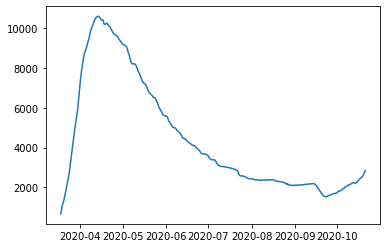

In [19]:

plt.figure(1)
plt.plot([datetime.strptime(d, '%Y-%m-%d') for d in days],beds_real["total"])


In [20]:
mult_deaths = np.sum(data[data['reg']==11][data['cl_age90']==0].hosp.values)/np.sum(data[data['reg']==11][data['cl_age90']==0].dc.values)
print(mult_deaths)
mult_icus = np.sum(data[data['reg']==11][data['cl_age90']==0].hosp.values)/np.sum(data[data['reg']==11][data['cl_age90']==0].rea.values)
print(mult_icus)


0.7791072263244828
7.194862933913178


/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
region = "Ile-de-France"

In [22]:
# Read group parameters
with open("../parameters/"+region+".yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)
    
# Read initialization
with open("../initialization/patient_zero.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    original_initialization = yaml.load(file, Loader=yaml.FullLoader)

# Read econ parameters
with open("../parameters/econ.yaml") as file:
    econ_params = yaml.load(file, Loader=yaml.FullLoader)

experiment_params = {
    'delta_schooling':0.5,
    'xi':0,
    'icus':3000,
}

In [23]:
date_1 = datetime.strptime("2020-03-17", '%Y-%m-%d')
date_2 = datetime.strptime("2020-05-11", '%Y-%m-%d')
date_3 = datetime.strptime("2020-06-01", '%Y-%m-%d')
date_4 = datetime.strptime("2020-07-01", '%Y-%m-%d')
date_5 = datetime.strptime("2020-09-01", '%Y-%m-%d')
final_date = datetime.strptime("2020-10-21", '%Y-%m-%d')

vacation_start = datetime.strptime("2020-04-01", '%Y-%m-%d')
vacation_end = date_5
days_vacation_start = (vacation_start - date_1).days
days_vacation_end = (vacation_end - date_1).days

first_day_google = datetime.strptime("2020-02-15", '%Y-%m-%d')
days_between_google = (date_1-first_day_google).days

In [24]:
(final_date-date_1).days+140

358

In [25]:
from copy import deepcopy

In [26]:
original_beta = universe_params['seir-groups']["age_group_0_9"]["parameters"]["beta"]
original_beta_vacation = original_beta
#original_beta_vacation = universe_params['seir-groups']["age_group_0_9"]["parameters"]["beta_vacation"]
t_days_beta = 730

for ag in universe_params['seir-groups']:
    universe_params['seir-groups'][ag]["parameters"]["beta"] = (
        [(original_beta if (t<days_vacation_start or t>= days_vacation_end) else original_beta_vacation) for t in range(t_days_beta) ]
    )


In [27]:
# Create model
mixing_method = {}
dynModel = FastDynamicalModel(universe_params, econ_params, experiment_params, 1, mixing_method, 1e9, 0, 0)


In [28]:
initial_params

{'mu': array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]),
 'sigma': array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]),
 'p_ICU': array([0.000444, 0.000444, 0.00069 , 0.002067, 0.003774, 0.00966 ,
        0.021868, 0.028137, 0.01792 ]),
 'p_H': array([0.001556, 0.001556, 0.00531 , 0.010933, 0.013226, 0.02534 ,
        0.049132, 0.084863, 0.30208 ]),
 'lambda_H_R': array([0.0665328 , 0.0665328 , 0.06619813, 0.06566265, 0.06472557,
        0.06258367, 0.05850067, 0.05287818, 0.04578313]),
 'lambda_H_D': array([0.00040161, 0.00040161, 0.00073628, 0.00127175, 0.00220884,
        0.00435074, 0.00843373, 0.01405622, 0.02115127]),
 'lambda_ICU_R': array([0.04526412, 0.04526412, 0.04503643, 0.04467213, 0.04403461,
        0.04257741, 0.03979964, 0.0359745 , 0.03114754]),
 'lambda_ICU_D': array([0.00027322, 0.00027322, 0.00050091, 0.00086521, 0.00150273,
        0.00295993, 0.0057377 , 0.00956284, 0.0143898 ]),
 'lambda_ICU': array([0.04553734, 0.04553734, 0.04553734, 0.0

In [29]:
lower_params

{'mu': array([0.22573363, 0.22573363, 0.22573363, 0.22573363, 0.22573363,
        0.22573363, 0.22573363, 0.22573363, 0.22573363]),
 'sigma': array([0.22321429, 0.22321429, 0.22321429, 0.22321429, 0.22321429,
        0.22321429, 0.22321429, 0.22321429, 0.22321429]),
 'p_ICU': array([0.000192, 0.000192, 0.000404, 0.001168, 0.0021  , 0.005565,
        0.012516, 0.016147, 0.01007 ]),
 'p_H': array([0.000235, 0.000235, 0.00268 , 0.00454 , 0.003655, 0.005502,
        0.00702 , 0.02185 , 0.160854]),
 'lambda_H_R': array([0.06442559, 0.06442559, 0.06422977, 0.06377285, 0.06285901,
        0.06070496, 0.05665796, 0.05104439, 0.04412533]),
 'lambda_H_D': array([0.00019582, 0.00019582, 0.00045692, 0.00097911, 0.00189295,
        0.00391645, 0.0078329 , 0.01325065, 0.02016971]),
 'lambda_ICU_R': array([0.04367257, 0.04367257, 0.04353982, 0.04323009, 0.04261062,
        0.04115044, 0.03840708, 0.03460177, 0.0299115 ]),
 'lambda_ICU_D': array([0.00013274, 0.00013274, 0.00030973, 0.00066372, 0.00128

In [30]:
initial_params

{'mu': array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]),
 'sigma': array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]),
 'p_ICU': array([0.000444, 0.000444, 0.00069 , 0.002067, 0.003774, 0.00966 ,
        0.021868, 0.028137, 0.01792 ]),
 'p_H': array([0.001556, 0.001556, 0.00531 , 0.010933, 0.013226, 0.02534 ,
        0.049132, 0.084863, 0.30208 ]),
 'lambda_H_R': array([0.0665328 , 0.0665328 , 0.06619813, 0.06566265, 0.06472557,
        0.06258367, 0.05850067, 0.05287818, 0.04578313]),
 'lambda_H_D': array([0.00040161, 0.00040161, 0.00073628, 0.00127175, 0.00220884,
        0.00435074, 0.00843373, 0.01405622, 0.02115127]),
 'lambda_ICU_R': array([0.04526412, 0.04526412, 0.04503643, 0.04467213, 0.04403461,
        0.04257741, 0.03979964, 0.0359745 , 0.03114754]),
 'lambda_ICU_D': array([0.00027322, 0.00027322, 0.00050091, 0.00086521, 0.00150273,
        0.00295993, 0.0057377 , 0.00956284, 0.0143898 ]),
 'lambda_ICU': array([0.04553734, 0.04553734, 0.04553734, 0.0

In [31]:
# Construct the windows for the parameters to move
windows = {}
# for p in initial_params:
#     windows[p] = (
#         np.min(upper_params[p]/initial_params[p]),
#         np.max(lower_params[p]/initial_params[p]),
#     )
    
windows['beta_mixing'] = (0.1,2.0)
windows['alpha_mixing'] = (0.1,2.0)
windows['gamma_mixing'] = (0.5,2.0)
windows['work_l'] = (0.2,0.3)
windows['other_l'] = (0,0.1)
windows['school_l'] = (0,0.1)
windows['leisure_l'] = (0,0.1)
windows['transport_l'] = (0.2,0.3)
windows['transmission'] = (0.5,2.0)

In [32]:
windows

{'beta_mixing': (0.1, 2.0),
 'alpha_mixing': (0.1, 2.0),
 'gamma_mixing': (0.5, 2.0),
 'work_l': (0.2, 0.3),
 'other_l': (0, 0.1),
 'school_l': (0, 0.1),
 'leisure_l': (0, 0.1),
 'transport_l': (0.2, 0.3),
 'transmission': (0.5, 2.0)}

In [33]:
# Generate samples
np.random.seed(0)
n_samples = 1
samples = 1+np.random.randn(n_samples,(final_date-date_1).days+150, 5)*0.05/2/np.sqrt(3)

In [34]:
import copy
import math
import matplotlib.dates as mdates
best_v = 0
best_error = float('inf')
validation_date = datetime.strptime("2020-10-21", '%Y-%m-%d')
icu_bound = 2950

def error(v):
    
    vector_upper_model_data_beds = []
    vector_upper_model_data_deaths = []
    vector_upper_model_data_icus = []
    vector_errors = []
    vector_deaths = []
    
    for n_sample in range(n_samples):
        days_ahead = v[0]
        alpha_mixing_home = v[1]
        alpha_mixing_work = v[1]
        alpha_mixing_transport = v[1]
        alpha_mixing_school = v[1]
        alpha_mixing_other = v[1]
        alpha_mixing_leisure = v[1]
        
        mix_1 = v[3]
        mix_2 = v[4]
        
        alphas_d = {
            'work':alpha_mixing_work,
            'transport':alpha_mixing_transport,
            'school':alpha_mixing_school,
            'other':alpha_mixing_other,
            'leisure':alpha_mixing_leisure,
            'home':alpha_mixing_home,
        }

        gamma_mixing_before = 1.0
        gamma_mixing_after = 1.0


        upper_bound_home = 1.0
        upper_bound_leisure = 1.0
        upper_bound_other = 1.0
        upper_bound_school = 1.0
        upper_bound_work = 1.0
        upper_bound_transport = 1.0

        school_lockdown = v[5]
        school_may = v[6]
        school_jun_jul_aug = v[7]
        school_sep_oct = v[8]

        beta_normal = original_beta
        beta_vacation = beta_normal*v[2]

        days_change_model = 0

        #         split_H_ICU_bef = v[9]
        #         change_lambda_H_bef = v[10]
        #         change_lambda_ICU_bef = v[11]
        #         change_p_death_bef = v[12]
        
        fraction_p_ICU = v[9]
        change_lambda_H_aft = v[10]
        change_lambda_ICU_aft = v[11]
        change_p_death_aft = v[12]
        

        
        days_change_rates = v[13]
        
        #         dynModel.sigma = initial_params["sigma"]*v[10]

        #         dynModel.lambda_H_R = initial_params["lambda_H_R"]*v[13]
        
        #         dynModel.lambda_ICU_R = initial_params["lambda_ICU_R"]*v[15]




        google['other'] = mix_1*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+(1-mix_1)*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
        google['leisure'] = mix_2*(google["parks_percent_change_from_baseline"]+100)/100+(1-mix_2)*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100


        # Number of days
        days_before_date_1 = int(days_ahead)
        days_between_dates_1_2 = (date_2-date_1).days
        days_between_dates_2_3 = (date_3-date_2).days
        days_between_dates_3_4 = (date_4-date_3).days
        days_between_dates_4_5 = (date_5-date_4).days
        days_after_date_5 = (final_date-date_5).days
        total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5+ days_after_date_5
        days_denom = days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4+days_between_dates_4_5


        # Some additional calculations
        validation_days = days_before_date_1 + (validation_date-date_1).days
        vacation_start_days = days_before_date_1 + (vacation_start-date_1).days
        vacation_end_days = days_before_date_1 + (vacation_end-date_1).days


        # Construct initialization
        initialization = copy.deepcopy(original_initialization)
        for i,group in enumerate(age_groups):
            if group == "age_group_40_49":
                initialization[group]["I"] = initialization[group]["I"] + 1
                initialization[group]["S"] = initialization[group]["S"] - 1
            initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]


        # Alphas
        a_before_google = {
            'home':upper_bound_home,
            'leisure':upper_bound_leisure,
            'other':upper_bound_other,
            'school':upper_bound_school,
            'transport':upper_bound_transport,
            'work':upper_bound_work
        }



        # Determine mixing method
        #     mixing_method_before = {
        #         "name":"mult",
        #         "param_alpha":alpha_mixing_before,
        #         "param_beta":alpha_mixing_before,
        #     }

        #     # Determine mixing method
        #     mixing_method_after = {
        #         "name":"mult",
        #         "param_alpha":alpha_mixing_after,
        #         "param_beta":alpha_mixing_after,
        #     }
        #dynModel.mixing_method = mixing_method_after




        # Calculate alphas
        alphas_vec = []
        for t in range(days_before_date_1-days_between_google):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = a_before_google
            alphas_vec.append(alphas)

        counter = 0
        for t in range(days_between_google):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':1.0,
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_1_2):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_lockdown*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_2_3):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_may*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_3_4):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_may*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_4_5):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_jun_jul_aug*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_after_date_5):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_sep_oct*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)
            counter += 1




        #     mixing_vec = []
        #     for t in range(int(vacation_start_days+days_change_model)):
        #         mixing_vec.append(mixing_method_before)
        #     for t in range(int(vacation_start_days+days_change_model),total_days):
        #         mixing_vec.append(mixing_method_after)




        # Calculate tests
        tests = np.zeros(len(age_groups))


        # Run model
        model_data_beds = {ag:[] for ag in age_groups+["total"]}
        model_data_icus = {ag:[] for ag in age_groups+["total"]}
        model_data_deaths = {ag:[] for ag in age_groups+["total"]}

        state = state_to_matrix(initialization)
        t_beds = 0
        t_icus = 0
        t_deaths = 0
        for i,ag in enumerate(age_groups):
            state_H = state[i,cont.index("H")]
            state_ICU = state[i,cont.index("ICU")]
            state_D = state[i,cont.index("D")]
            model_data_beds[ag].append(state_H)
            model_data_icus[ag].append(state_ICU)
            model_data_deaths[ag].append(state_D)
            t_beds+= state_H
            t_icus+= state_ICU
            t_deaths+= state_D
        model_data_beds["total"].append(t_beds)
        model_data_icus["total"].append(t_icus)
        model_data_deaths["total"].append(t_deaths)

        recalc_days = [0,
                     days_before_date_1,
                     days_before_date_1+days_between_dates_1_2,
                     days_before_date_1+days_between_dates_1_2+days_between_dates_2_3,
                     days_before_date_1+days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4,
                     days_before_date_1+days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4+days_between_dates_4_5,
                    int(vacation_start_days)
                    ]

        dynModel.beta = np.zeros((len(age_groups),len(dynModel.groups[age_groups[0]].parameters["beta"])))
        for i in range(len(age_groups)):
            for j in range(len(dynModel.groups[age_groups[0]].parameters["beta"])):
                if j < int(vacation_start_days+days_change_model):
                    dynModel.beta[i,j] = beta_normal
                else:
                    dynModel.beta[i,j] = beta_vacation

        for t in range(total_days):
            current_date = date_1+timedelta(days=t-days_before_date_1)
            day_of_week = current_date.weekday()

            if t in recalc_days:
                update_contacts = True
            else:
                update_contacts = True
                
            if t<int(vacation_start_days+days_change_rates):
                dynModel.p_H = initial_params["p_H"]
                dynModel.p_ICU = initial_params["p_ICU"]

                lambda_H = initial_params["lambda_H"]
                lambda_ICU = initial_params["lambda_ICU"]
                p_death = initial_params["p_death"]
                
                dynModel.lambda_H_D = p_death*lambda_H
                dynModel.lambda_H_R = (1-p_death)*lambda_H
                dynModel.lambda_ICU_D = p_death*lambda_ICU
                dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU

            else:
                trans_days = 30.0
                d_after = t-int(vacation_start_days+days_change_rates)
                d_portion = max(trans_days-d_after,0)/trans_days
                
                dynModel.p_ICU = initial_params["p_H"]*d_portion+initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion)
                dynModel.p_H = initial_params["p_ICU"]*d_portion+(initial_params["p_H"]+initial_params["p_ICU"])-initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion)
                

                lambda_H = initial_params["lambda_H"]*d_portion+initial_params["lambda_H"]*change_lambda_H_aft*(1-d_portion)
                lambda_ICU = initial_params["lambda_ICU"]*d_portion+ initial_params["lambda_ICU"]*change_lambda_ICU_aft*(1-d_portion)
                p_death = initial_params["p_death"]*d_portion+initial_params["p_death"]*change_p_death_aft*(1-d_portion)
                
                dynModel.lambda_H_D = p_death*lambda_H
                dynModel.lambda_H_R = (1-p_death)*lambda_H
                dynModel.lambda_ICU_D = p_death*lambda_ICU
                dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU
            

            if day_of_week <= 4:
                season = "new"
                dynModel.mixing_method = {
                    "name":"mult",
                    "param_alpha":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                    "param_beta":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                }
            else:
                season = "new"
                dynModel.mixing_method = {
                    "name":"mult",
                    "param_alpha":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                    "param_beta":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                }

            #dynModel.mixing_method = mixing_vec[t]

            state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]), t, season, update_contacts=update_contacts)
            t_beds = 0
            t_icus = 0
            t_deaths = 0
            for i,ag in enumerate(age_groups):
                state_H = state[i,cont.index("H")]
                state_ICU = state[i,cont.index("ICU")]
                state_D = state[i,cont.index("D")]
                model_data_beds[ag].append(state_H)
                model_data_icus[ag].append(state_ICU)
                model_data_deaths[ag].append(state_D)
                t_beds+= state_H
                t_icus+= state_ICU
                t_deaths+= state_D
            #print(t_beds)
            model_data_beds["total"].append(t_beds)
            model_data_icus["total"].append(t_icus)
            model_data_deaths["total"].append(t_deaths)


        initial_date = date_1-timedelta(days=days_before_date_1)

        # Calculate the days of the model
        days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

        # Indices where to put the real data
        indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

        # Real data
        real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
        real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
        real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}

        for k,ind in enumerate(indices):
            for ag in age_groups+["total"]:
                real_data_beds[ag][ind] = beds_real[ag][k] if beds_real[ag][k]!=0 else float('nan')
                real_data_icus[ag][ind] = icus_real[ag][k] if icus_real[ag][k]!=0 else float('nan')
                real_data_deaths[ag][ind] = deaths_real[ag][k] if deaths_real[ag][k]!=0 else float('nan')


        error_constant = 0.25
        error_beds = 0
        error_icus = 0
        error_deaths = 0
        error_beds_total = 0
        error_icus_total = 0
        error_deaths_total = 0
        
        peak_beds = np.nanargmax(np.array(real_data_beds["total"]))
        peak_icus = np.nanargmax(np.array(real_data_icus["total"]))
        peak_deaths = peak_beds+30
        
        for ag in old_age_groups:
            error_beds += np.nanmean((np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag]))/np.array(real_data_beds[ag]))[0:validation_days-1])
            error_icus += np.nanmean((np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag]))/np.array(real_data_icus[ag]))[0:validation_days-1])
            error_deaths += np.nanmean((np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag]))/np.array(real_data_deaths[ag]))[0:validation_days-1])
        error_beds_total += np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[0:validation_days-1])
        error_beds_total += error_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[validation_days-1:validation_days])
        error_beds_total += error_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[peak_beds:peak_beds+1])
                              
        error_icus_total += np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[0:validation_days-1])
        error_icus_total += error_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[validation_days-1:validation_days])
        error_icus_total += error_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[peak_icus:peak_icus+1])

                              
        error_deaths_total += np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[0:validation_days-1])
        error_deaths_total += error_constant*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[validation_days-1:validation_days])
        error_deaths_total += error_constant/2.0*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_deaths:peak_deaths+1])
        error_deaths_total += error_constant/2.0*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_beds:peak_beds+1])

        overflow = np.array(model_data_icus["total"]) - icu_bound
        overflow_error = np.nanmean([max(overflow[i],0) for i in range(len(overflow))])


        #diff = np.array(model_data_beds["total"])-np.array(real_data_beds["total"])
        #error_beds_above = np.nanmean([max(d,0) for d in diff])
        #error_beds_below = -np.nanmean([min(d,0) for d in diff])

        #cumm_beds_model = [sum([model_data_beds["total"][k] for k in range(i+1) if not math.isnan(real_data_beds["total"][k])]) for i in range(len(model_data_beds["total"]))]
        #cumm_beds_real = [sum([real_data_beds["total"][k] for k in range(i+1) if not math.isnan(real_data_beds["total"][k])]) for i in range(len(real_data_beds["total"]))]
        #diff_cumm = np.array(cumm_beds_model)-np.array(cumm_beds_real)
        #error_cumm_above = np.nanmean([max(d,0) for d in diff_cumm])
        #error_cumm_below = -np.nanmean([min(d,0) for d in diff_cumm])



        #     error = error_beds_total
        #     error = mult_icus*error_icus_total
        #     error = mult_deaths*error_deaths_total
        upper_days_model = days_model
        
        error = 0.25*error_beds+4*error_beds_total+0.25*error_icus+4*error_icus_total+0.25*error_deaths+4*error_deaths_total+overflow_error

        vector_errors.append(error)
        vector_deaths.append(error_deaths)
        vector_upper_model_data_beds.append(model_data_beds["total"])
        vector_upper_model_data_deaths.append(model_data_deaths["total"])
        vector_upper_model_data_icus.append(model_data_icus["total"])
        

    error = np.mean(vector_errors)

    
    global best_error
    global best_v
    if error<best_error:
        best_error = error
        print("best_error:",best_error)
        print("vector:",vector_errors)
        print("mean_deaths",np.mean(vector_deaths))
        best_v = v
        print(v)

        print("Beds")
        plt.figure(1)
        for n_sample in range(n_samples):
            plt.plot(upper_days_model, vector_upper_model_data_beds[n_sample], label="Prediction")
        plt.plot(upper_days_model, real_data_beds["total"], label="Real")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
        plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
        plt.show()
        
        print("Deaths")
        plt.figure(1)
        for n_sample in range(n_samples):
            plt.plot(upper_days_model, vector_upper_model_data_deaths[n_sample], label="Prediction")
        plt.plot(upper_days_model, real_data_deaths["total"], label="Real")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
        plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
        plt.show()
        
        print("ICUs")
        plt.figure(1)
        for n_sample in range(n_samples):
            plt.plot(upper_days_model, vector_upper_model_data_icus[n_sample], label="Prediction")
        plt.plot(upper_days_model, real_data_icus["total"], label="Real")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
        plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
        plt.show()
        
        

    return error





/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


best_error: 106.74852134298989
best_error: 132.56364405606348
vector: [106.74852134298989]
mean_deaths 9.086896515672253
vector: [132.56364405606348]
mean_deaths 29.36234903166536
[53.16287196  1.76947287  1.11511568  0.39893434  0.82168011  0.08702135
  0.91807194  0.13880661  0.97328852  0.59862108  1.11758437  0.61283223
  1.05740989  4.38017631][5.59761114e+01 4.58831204e-01 9.84865484e-01 2.42753471e-01
 4.43496215e-02 4.11642865e-02 6.32388671e-01 2.14280586e-02
 8.59707504e-01 1.68895966e+00 7.93526148e-01 1.35858021e+00
 1.69322207e+00 2.89534175e+01]

Beds
Beds
best_error: 20.658124142729648
best_error: 19.307136676511096
best_error: 119.78479655769452
vector: [20.658124142729648]
vector: [19.307136676511096]
mean_deaths 3.5496751960724273
vector: [119.78479655769452]
best_error: 162.60659837873789
[7.78229572e+01 1.14560183e+00 6.12803965e-01 5.11608501e-01
 3.02309985e-01 3.10518222e-02 8.09878715e-01 2.29323774e-02
 9.20566766e-01 1.73104567e+00 1.66059540e+00 1.98219683e+0

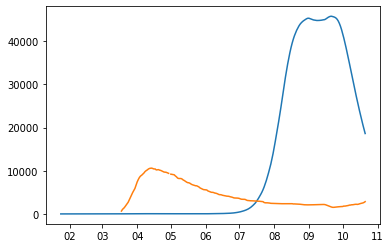

Deaths


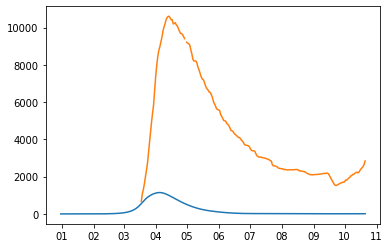

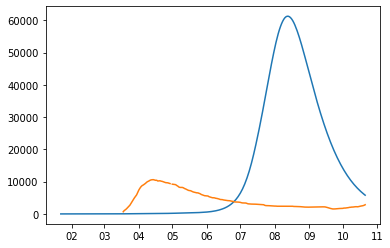

Deaths
Deaths


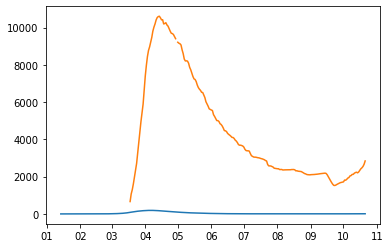

Deaths


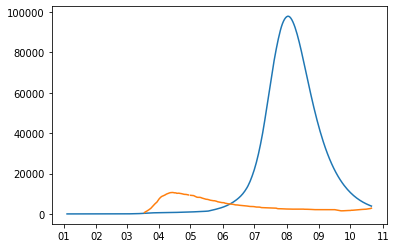

Deaths


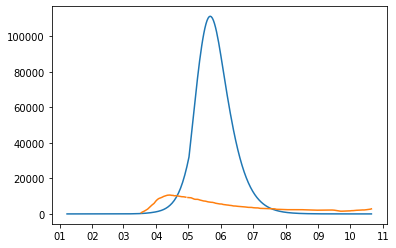

Deaths


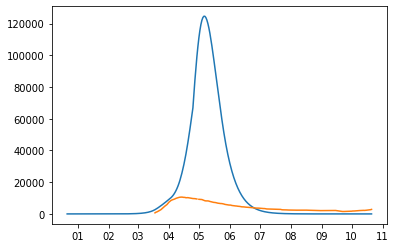

Deaths


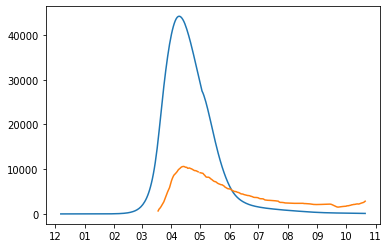

Deaths


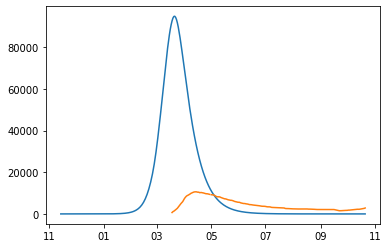

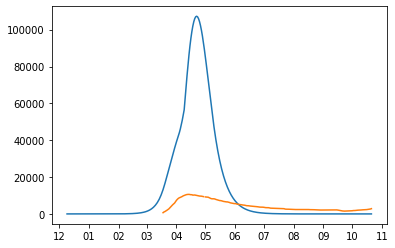

Deaths
Deaths


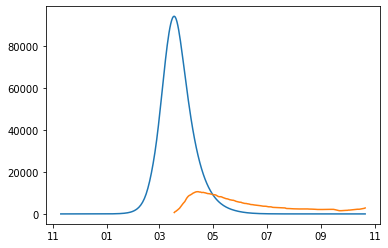

Deaths


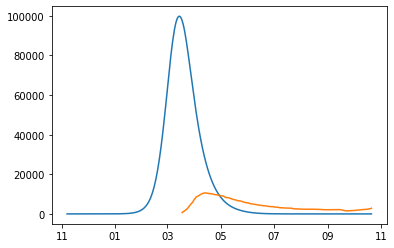

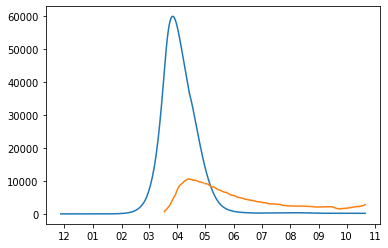

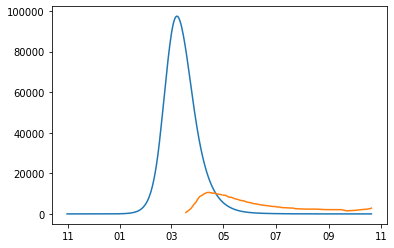

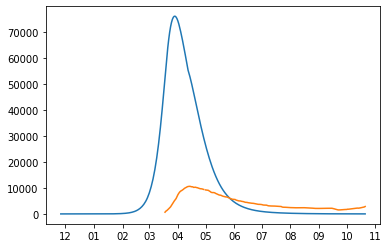

Deaths
Deaths
Deaths
Deaths


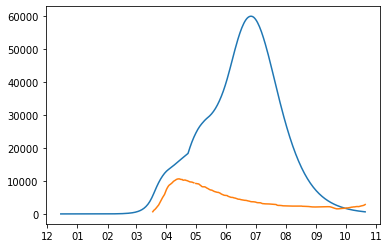

Deaths


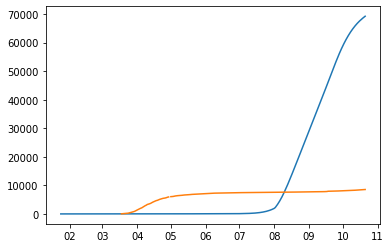

ICUs


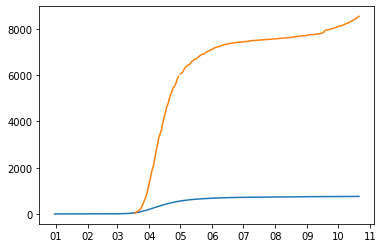

ICUs


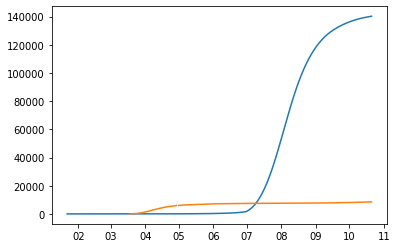

ICUs


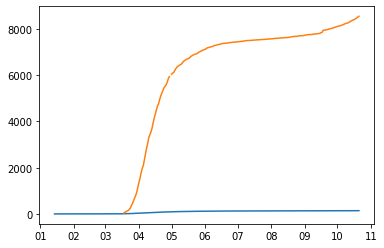

ICUs


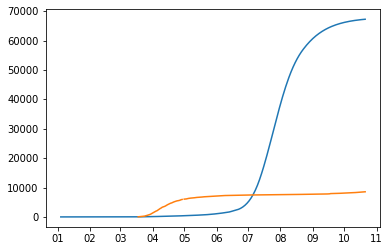

ICUs


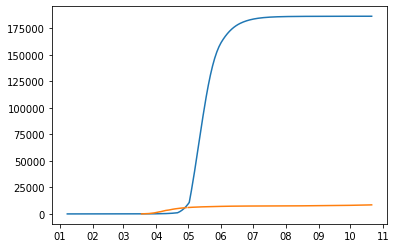

ICUs


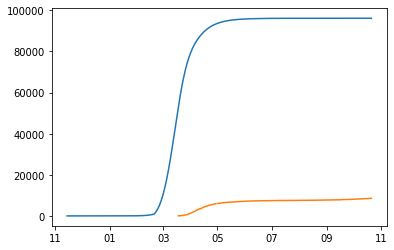

ICUs


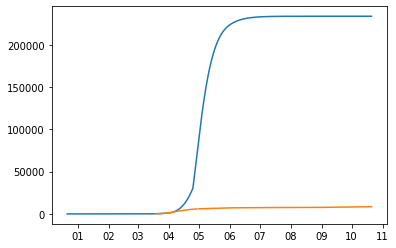

ICUs


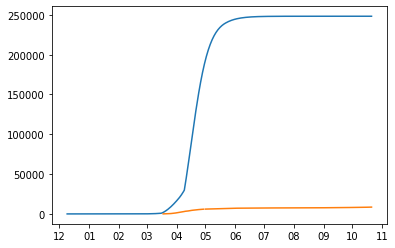

ICUs


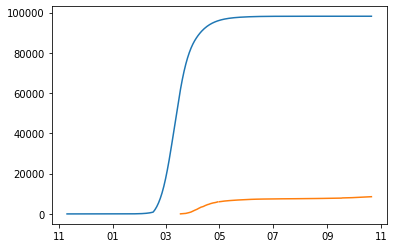

ICUs


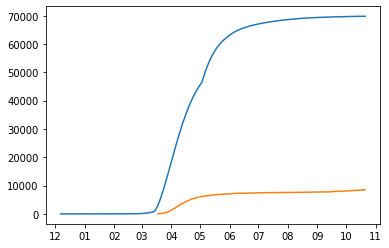

ICUs


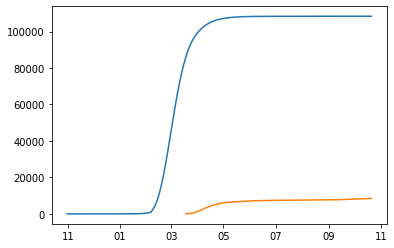

ICUs


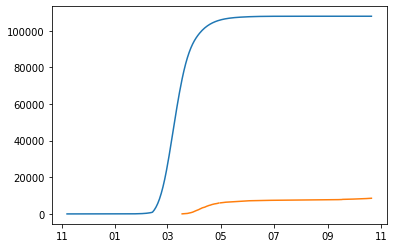

ICUs


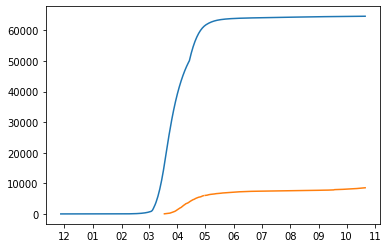

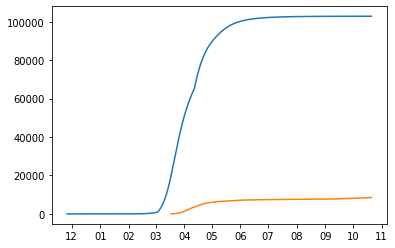

ICUs
ICUs


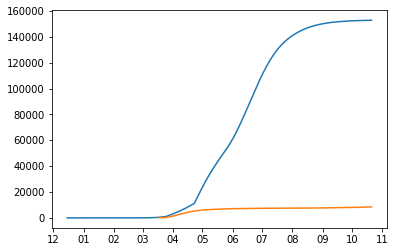

ICUs


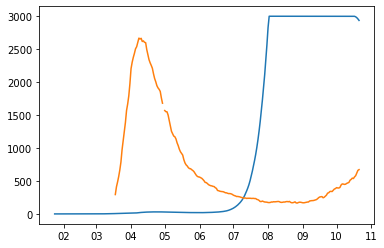

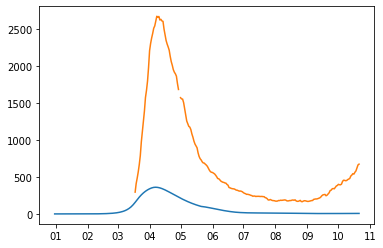

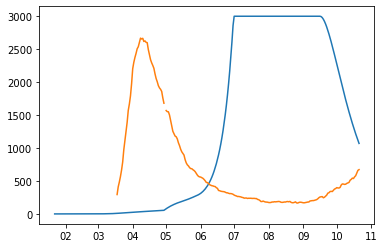

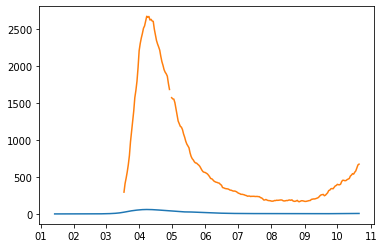

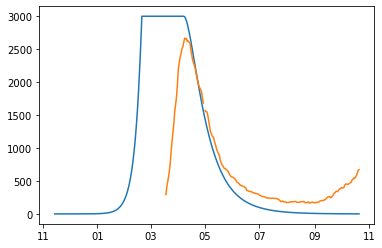

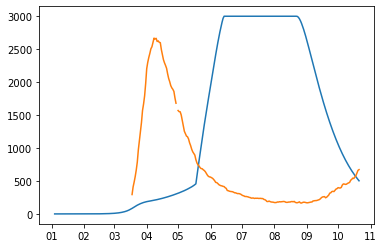

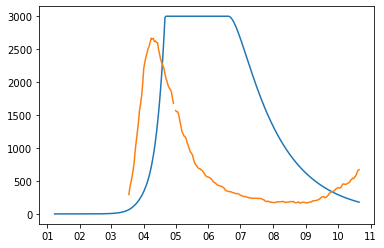

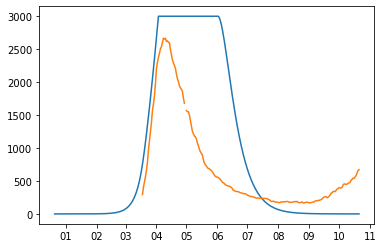

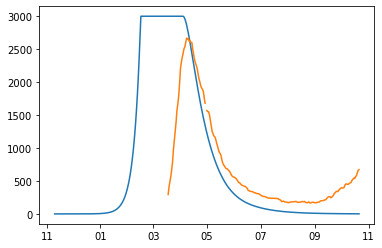

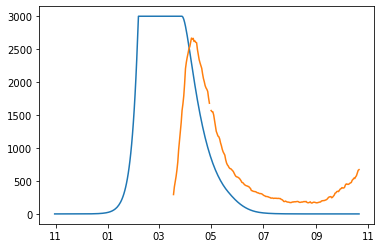

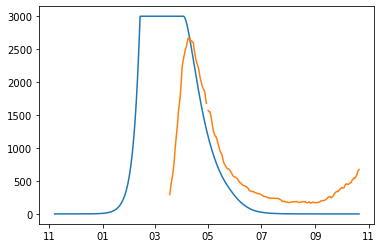

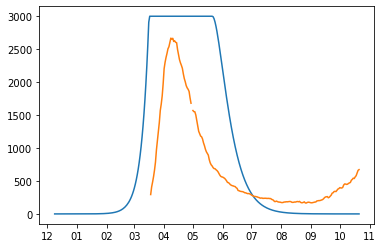

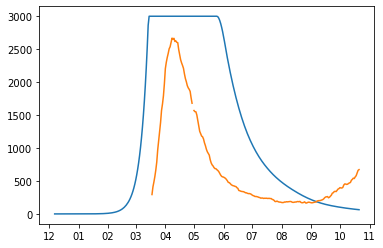

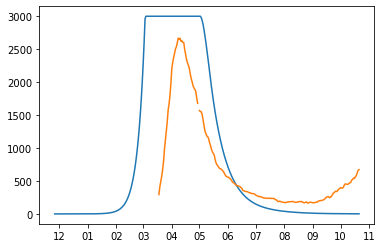

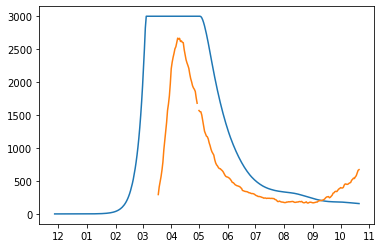

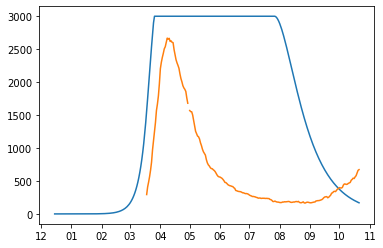

best_error: 20.787457608439425
vector: [20.787457608439425]
mean_deaths 3.933192509244037
[6.36256826e+01 1.70866091e+00 5.44794404e-01 8.71628604e-02
 1.79725103e-01 3.34588465e-02 9.56565482e-01 5.77074203e-02
 5.59396227e-01 1.21475416e+00 1.92221149e+00 1.63052467e+00
 1.44305738e+00 3.22720710e+01]
Beds
best_error: 150.38187394293453
vector: [150.38187394293453]
mean_deaths 61.46446153587623
[5.43676581e+01 5.87045128e-01 1.39296696e+00 8.12294114e-02
 5.20356619e-01 6.15832725e-02 2.32131316e-01 1.94179530e-02
 8.73814194e-01 1.72326660e+00 1.69862250e+00 7.52030234e-01
 1.52880252e+00 2.08010013e+01]
Beds
best_error: 20.20060283258331
best_error: 81.73330926204073
vector: [81.73330926204073]
mean_deaths 16.31535326548339
[9.19701266e+01 9.50426392e-01 1.10748502e+00 3.03688412e-01
 1.63480175e-01 1.07562866e-02 3.31249533e-01 1.94442317e-01
 9.55085157e-01 5.40580931e-01 1.59960259e+00 1.22299738e+00
 1.73074796e+00 4.71389696e+00]
Beds
vector: [20.20060283258331]
mean_deaths 3.

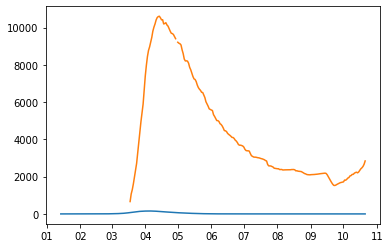

Deaths
best_error: 180.33660009568678
vector: [180.33660009568678]
mean_deaths 111.40736845631923
[1.08035001e+02 2.97231813e-01 1.37296911e+00 2.62347939e-01
 2.27302716e-01 7.19976452e-02 6.74359203e-01 4.92472296e-02
 5.25795083e-01 1.86130338e+00 5.26308513e-01 6.20817135e-01
 1.20311507e+00 2.37557187e+01]
Beds


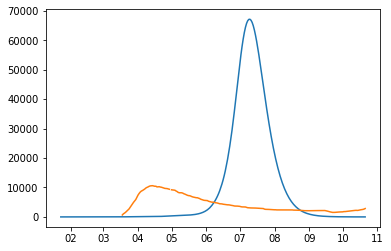

Deaths


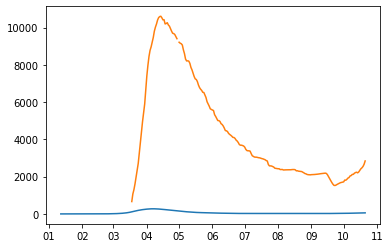

Deaths


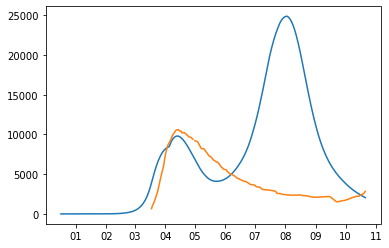

Deaths


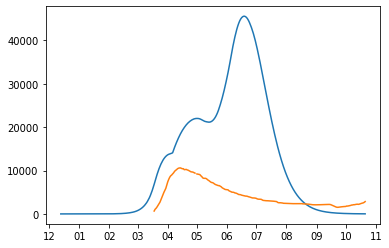

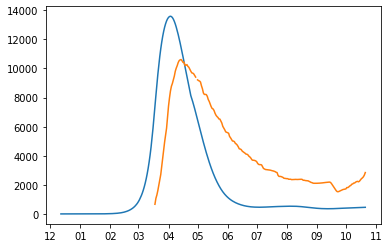

Deaths
Deaths


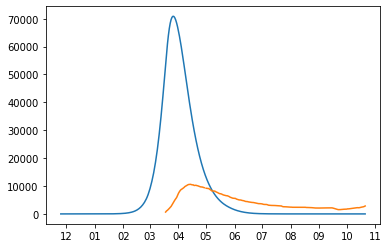

Deaths


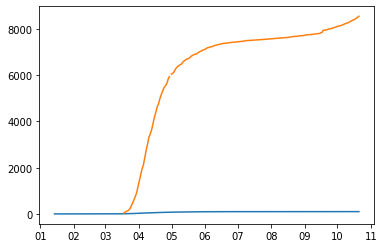

ICUs


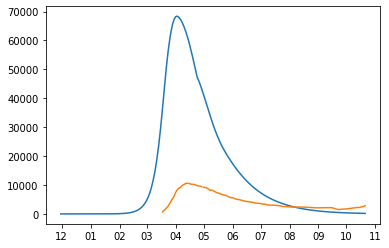

Deaths


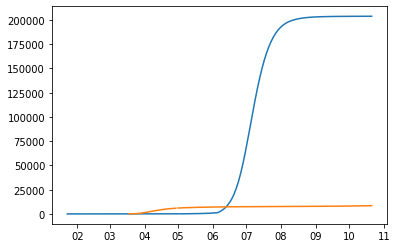

ICUs


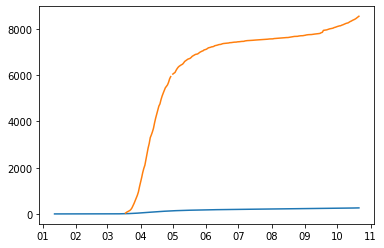

ICUs


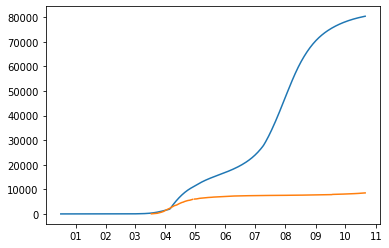

ICUs


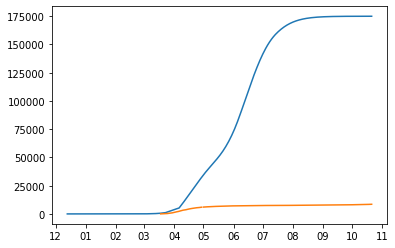

ICUs


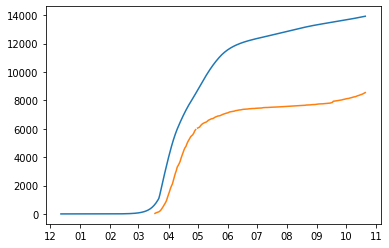

ICUs


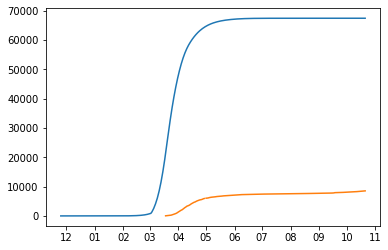

ICUs


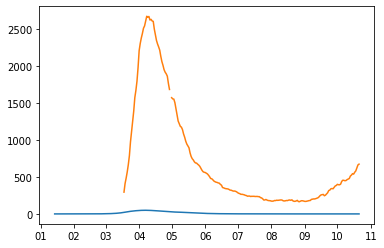

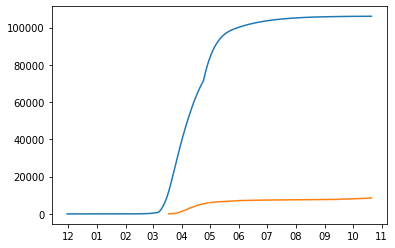

ICUs


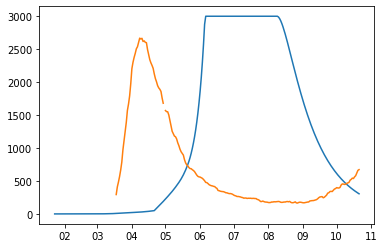

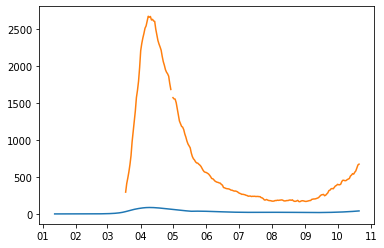

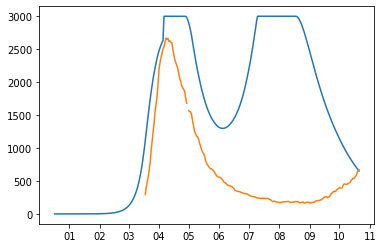

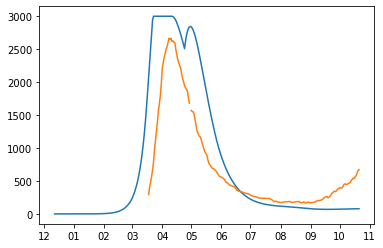

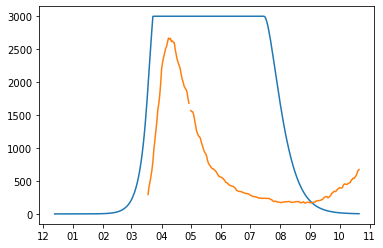

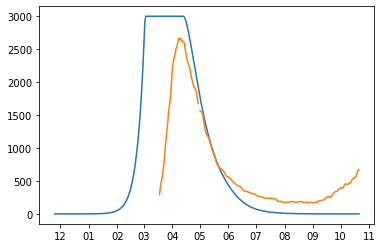

best_error: 19.899874933164263
vector: [19.899874933164263]
mean_deaths 3.9607310933035613
[52.58197765  1.9708788   0.82998243  0.11649963  0.7886509   0.05916046
  0.39573866  0.06263653  0.92724133  0.93869262  1.70612132  1.85178685
  1.14496342 48.90778721]
Beds


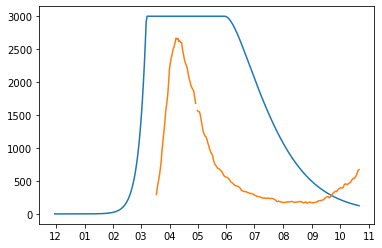

best_error: 12.581062727123463
vector: [12.581062727123463]
mean_deaths 1.9492832892220975
[9.48100226e+01 1.83299581e+00 7.13271276e-01 3.87899285e-01
 3.06867282e-01 7.81914978e-02 9.45138262e-01 3.23151822e-02
 8.00790653e-01 1.74830131e+00 8.88663932e-01 1.74198295e+00
 1.05696954e+00 3.26595253e+01]
Beds


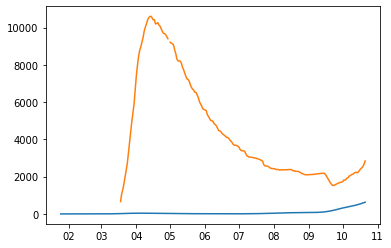

Deaths


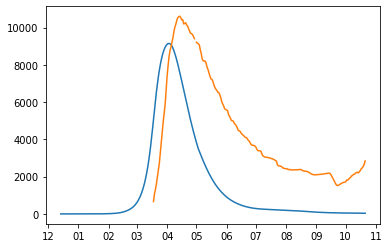

Deaths
best_error: 39.255913892554034


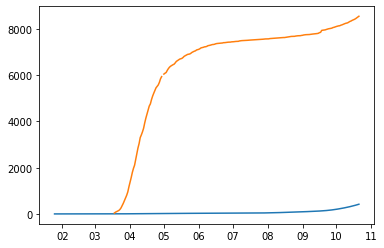

vector: [39.255913892554034]
ICUs
mean_deaths 2.7191189611412803
[7.87055705e+01 8.81794190e-01 7.21335661e-01 1.37063696e-03
 4.30852483e-01 6.58045383e-02 8.80707805e-01 5.20179686e-02
 8.53970524e-01 1.86828013e+00 1.23323922e+00 1.24914516e+00
 9.71172150e-01 3.69052479e+01]
Beds


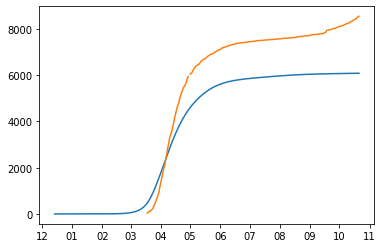

ICUs


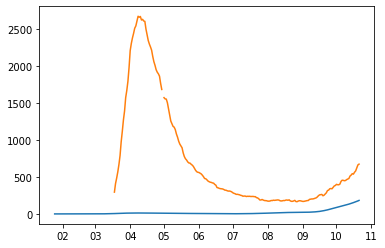

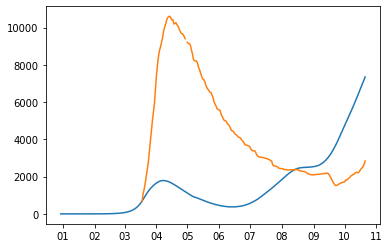

Deaths


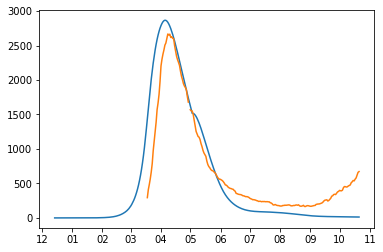

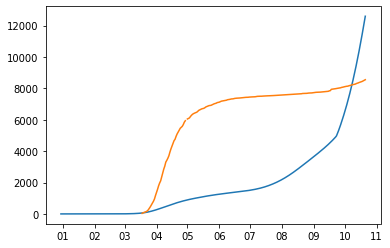

ICUs
best_error: 156.09590627821098
vector: [156.09590627821098]
mean_deaths 24.748739160716017
[7.55093916e+01 1.09990875e+00 1.21604025e+00 7.29142512e-01
 9.65077766e-01 2.06302922e-02 9.19898707e-02 1.39317733e-01
 9.36869109e-01 9.28058631e-01 5.34830442e-01 1.54182285e+00
 1.15891736e+00 1.07259725e+00]
Beds


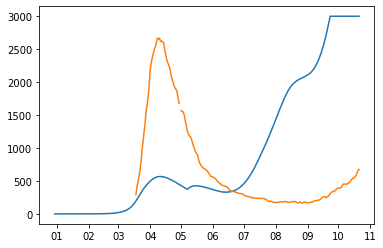

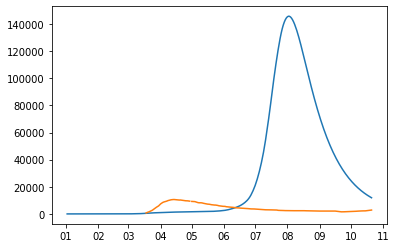

Deaths
best_error: 19.606615550831737
vector: [19.606615550831737]
mean_deaths 1.651846615134366
[8.62988778e+01 8.70525136e-01 8.15715505e-01 5.35904241e-01
 2.19070050e-02 8.25034097e-02 2.27494586e-01 1.83806555e-01
 5.40466262e-01 1.50301746e+00 1.29790561e+00 1.53311442e+00
 1.80179336e+00 2.19499605e+01]
Beds


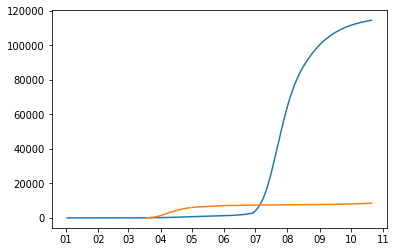

ICUs
best_error: 127.02664382515437
vector: [127.02664382515437]
mean_deaths 95.47448522882125
[1.11966178e+02 1.46967942e+00 1.06384340e+00 7.36024978e-01
 9.48297487e-01 4.79774158e-02 9.08021973e-01 1.70719196e-01
 6.39129292e-01 1.55403971e+00 1.44310657e+00 1.32021431e+00
 1.18769333e+00 3.78561257e+01]
Beds


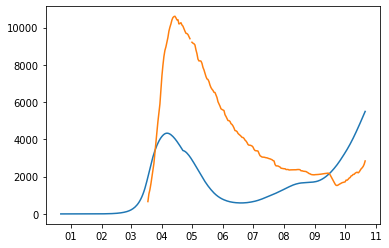

Deaths


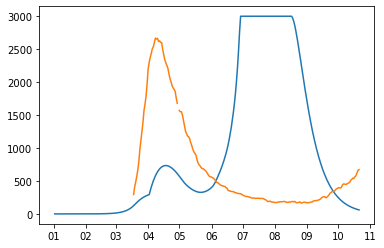

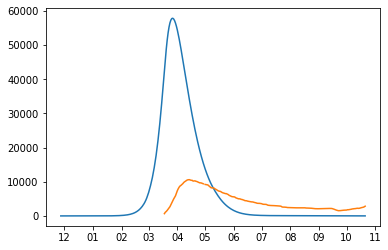

Deaths


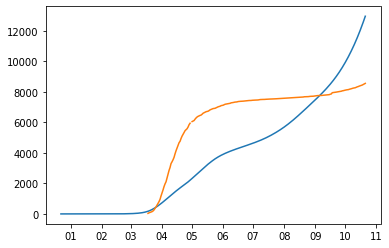

ICUs
best_error: 144.5526799620266
vector: [144.5526799620266]
mean_deaths 40.39140329438285
[9.86436441e+01 1.42557375e+00 1.81434059e+00 6.15836926e-01
 9.90144222e-02 7.97373357e-02 1.71283726e-01 1.24887339e-01
 5.94773557e-01 5.17591152e-01 5.70993417e-01 1.61745109e+00
 1.95329165e+00 4.20116097e+01]
Beds
best_error: 129.80433863265608
vector: [129.80433863265608]
mean_deaths 25.875904496107868
[8.75688209e+01 1.72565951e+00 1.45662056e+00 7.49435525e-01
 2.99856719e-01 6.71632090e-02 4.84243471e-01 6.78687414e-02
 6.87427559e-01 1.07652140e+00 7.71731342e-01 6.61360153e-01
 1.19449013e+00 4.93921610e+01]
Beds


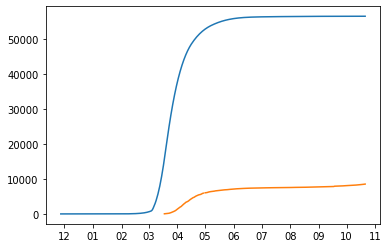

ICUs


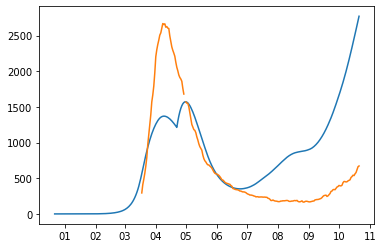

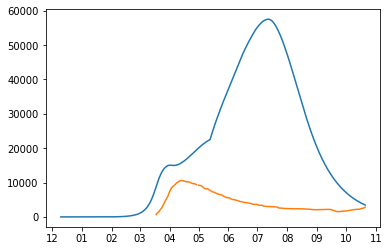

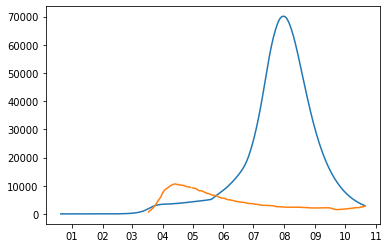

Deaths
Deaths
best_error: 164.97559837434903
vector: [164.97559837434903]
mean_deaths 99.20580470920524
[1.09334368e+02 6.46455084e-01 1.50294629e+00 1.99547623e-01
 7.31211945e-01 5.31563452e-02 3.64302280e-01 4.69027878e-02
 8.57681422e-01 1.05548961e+00 6.02033529e-01 5.75130984e-01
 1.96250918e+00 5.16389942e+01]
Beds


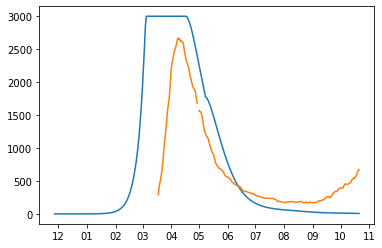

best_error: 163.6654395798809
vector: [163.6654395798809]
mean_deaths 74.02050131767784
[50.34773403  0.34629555  1.93007116  0.2193326   0.9223375   0.06107746
  0.34429729  0.14689588  0.94699968  1.19517571  1.04111292  0.64966383
  1.70919819  7.57440017]
Beds


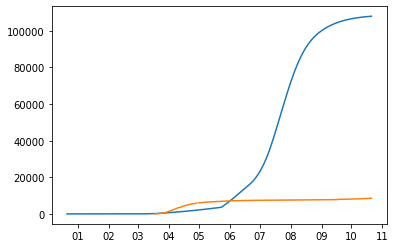

ICUs


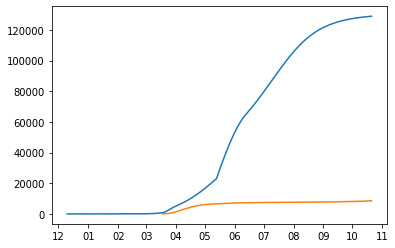

ICUs


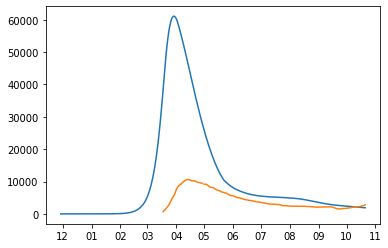

Deaths


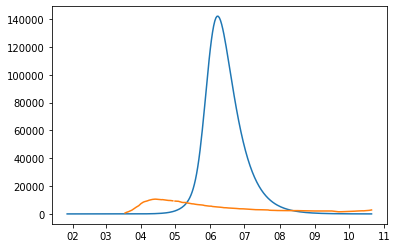

Deaths


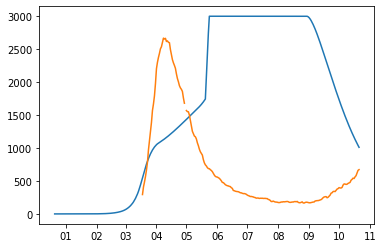

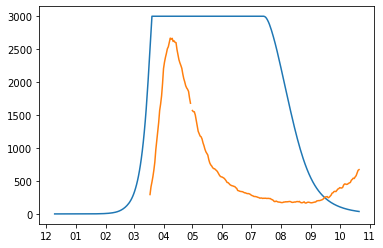

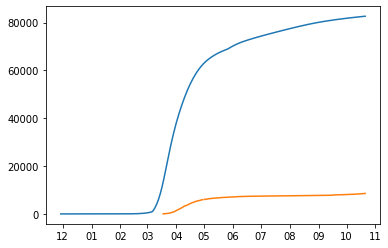

ICUs
best_error: 74.968315244474
vector: [74.968315244474]
mean_deaths 38.100558389089684
[1.04290845e+02 1.41320109e+00 1.18575147e+00 3.75111422e-01
 2.62815113e-01 9.16895488e-02 8.49369099e-01 1.87486359e-01
 7.64962043e-01 1.89949590e+00 9.74531726e-01 1.82300715e+00
 1.63390073e+00 4.42265909e+01]
Beds


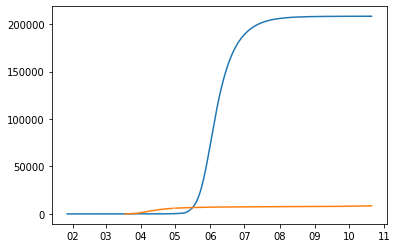

ICUs


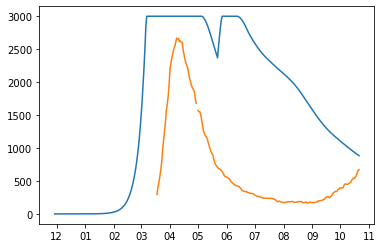

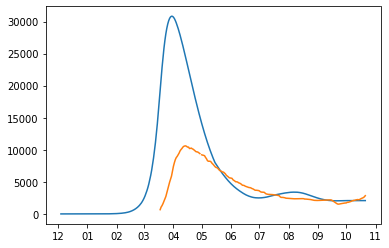

Deaths


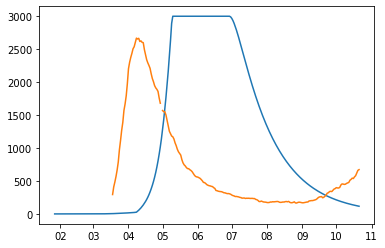

best_error: 11.937862675640261
vector: [11.937862675640261]
mean_deaths 1.4463614361446981
[9.02643682e+01 4.63135172e-01 5.63965186e-01 7.07936926e-01
 7.62438482e-01 4.37659524e-03 4.22516942e-01 8.44335917e-02
 9.16581405e-01 1.20529849e+00 6.80779942e-01 1.11721842e+00
 1.61906367e+00 3.82584054e+01]
Beds


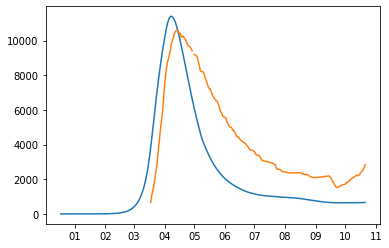

Deaths


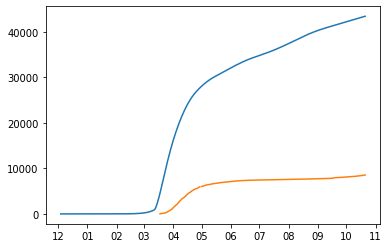

ICUs


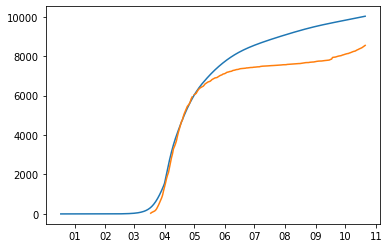

ICUs
best_error: 20.882987369266736
vector: [20.882987369266736]
mean_deaths 3.9683749362029883
[5.87892592e+01 1.71428458e+00 5.32747461e-01 2.17305299e-01
 2.55574809e-01 1.76300036e-02 7.79389872e-01 1.90328138e-01
 7.57916157e-01 1.15279992e+00 9.49599033e-01 8.54863287e-01
 8.72600031e-01 1.41408620e+01]
Beds


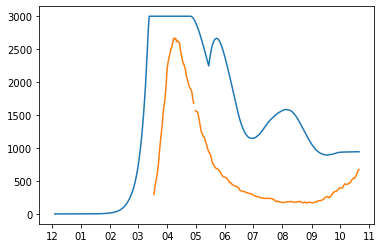

best_error: 129.6943025618941
vector: [129.6943025618941]
mean_deaths 59.371775712681284
[7.68845767e+01 1.17747585e-01 9.09661401e-01 4.70975806e-01
 3.71464786e-02 4.66388963e-02 4.71520173e-02 7.72255320e-02
 7.48791098e-01 1.43906224e+00 1.84783034e+00 1.14931712e+00
 9.13327180e-01 3.61102079e+01]
Beds


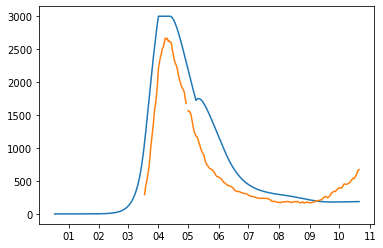

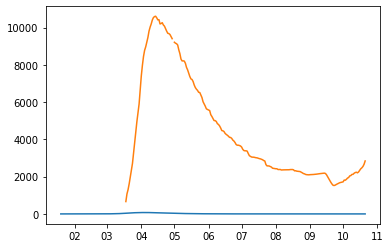

Deaths
best_error: 25.40986862286999
vector: [25.40986862286999]
mean_deaths 6.910813161117413
[9.32263469e+01 4.43880188e-01 6.27474473e-01 6.86205089e-01
 2.85863298e-01 3.44184721e-02 1.24526698e-01 3.98100929e-02
 9.80521110e-01 1.38136384e+00 1.39634037e+00 1.86727309e+00
 1.15461877e+00 2.08930470e+01]
Beds


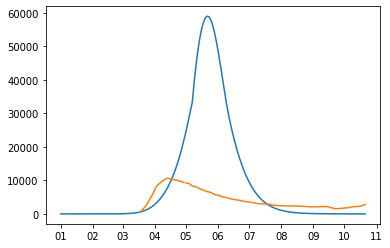

Deaths


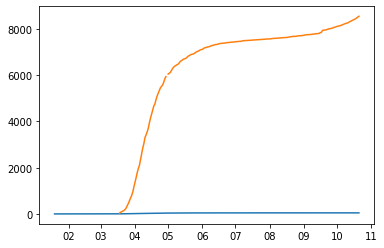

ICUs
best_error: 134.30611164101603
vector: [134.30611164101603]
mean_deaths 58.55732255984224
[9.72859072e+01 3.91016567e-01 1.19921879e+00 3.15075494e-01
 5.74594559e-01 6.23412509e-02 4.57298444e-01 9.75303942e-02
 7.71714057e-01 6.85714029e-01 1.24285766e+00 1.44690654e+00
 1.59916886e+00 9.82774628e+00]
Beds


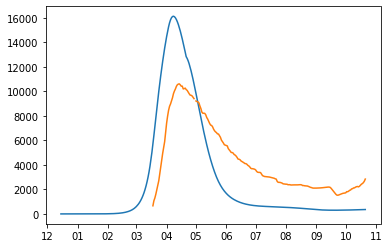

best_error: 77.65312698146224
vector: [77.65312698146224]
Deaths
mean_deaths 12.747407047230393
[8.12048759e+01 3.08757499e-01 7.89179712e-01 8.69624904e-01
 4.43549208e-01 9.61972033e-02 5.19942428e-01 5.99578877e-02
 5.81769207e-01 8.11640131e-01 1.22266618e+00 1.94896501e+00
 9.37808481e-01 4.64366970e+01]
Beds
best_error: 20.71365725528424
vector: [20.71365725528424]
mean_deaths 3.948934299206873
[5.82768126e+01 9.21322801e-01 6.46056272e-01 4.42197505e-02
 1.40163476e-01 6.91385664e-03 8.66767987e-01 2.23706910e-02
 8.16288700e-01 7.13337758e-01 9.42667991e-01 1.50131715e+00
 9.59650527e-01 1.57640236e+01]
Beds


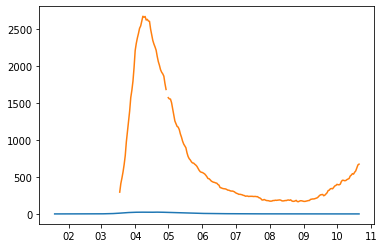

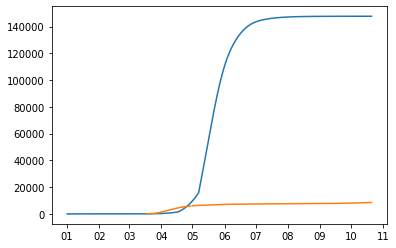

ICUs


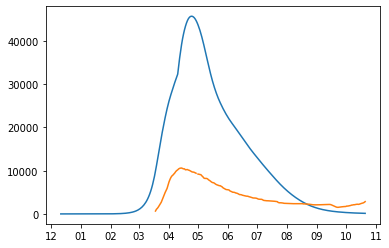

Deaths


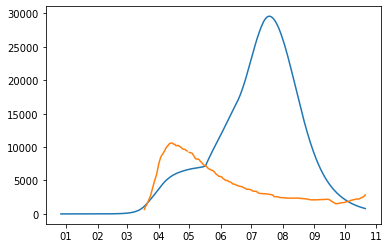

Deaths


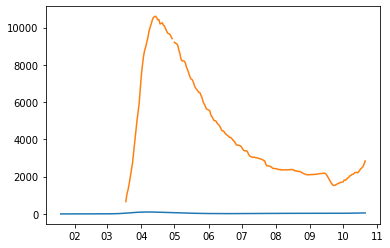

Deaths


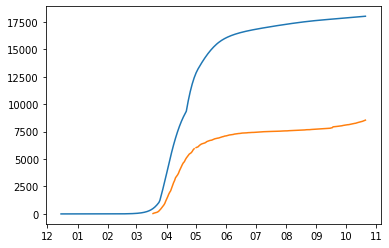

ICUs


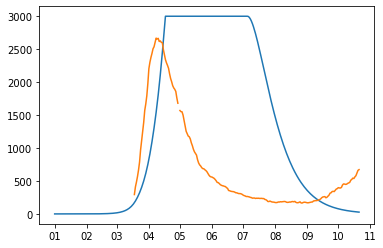

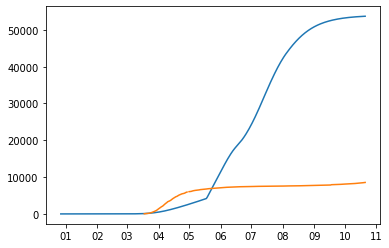

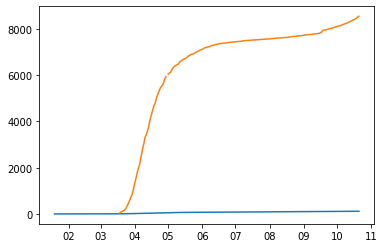

ICUs


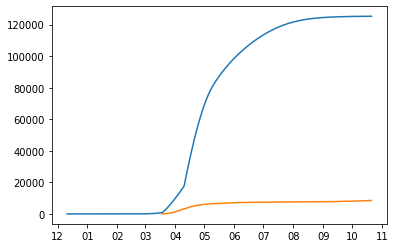

ICUs
ICUs


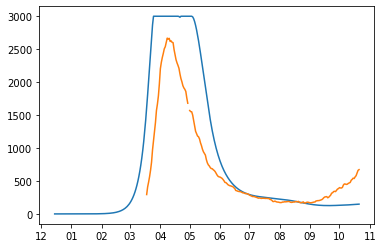

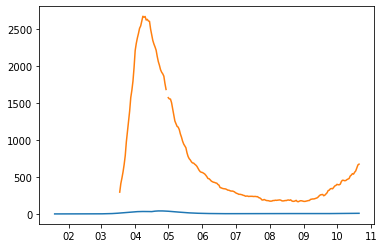

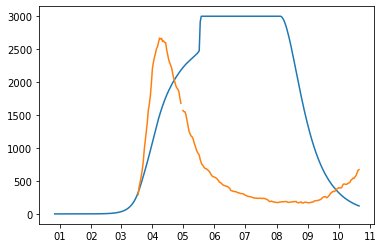

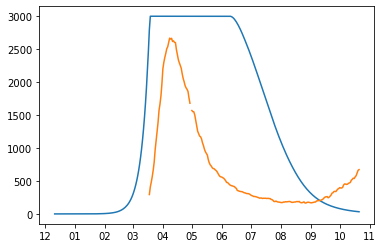

best_error: 107.47706538099999
vector: [107.47706538099999]
mean_deaths 63.306228884913715
[1.03447837e+02 2.48882520e-01 5.90715741e-01 7.83854425e-01
 7.27303364e-01 3.12310624e-03 2.21799351e-01 1.45343526e-01
 7.37214327e-01 1.65831376e+00 9.11269507e-01 7.14026778e-01
 6.87416934e-01 1.47415986e+01]
Beds


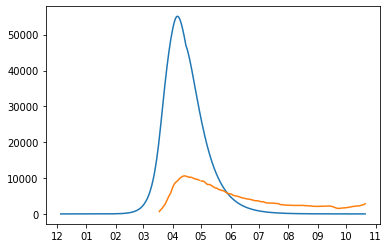

Deaths


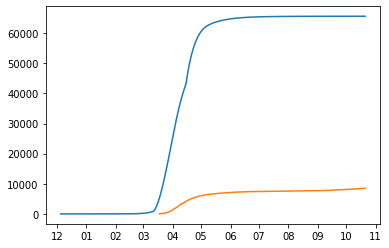

ICUs
best_error: 15.5016652952025
vector: [15.5016652952025]
mean_deaths 3.7142651688007904
[5.06896405e+01 1.50568033e-01 5.16267272e-01 5.06340809e-01
 4.05953238e-01 2.64752147e-02 5.94536298e-01 1.73898491e-02
 8.20365986e-01 1.04948110e+00 9.05121251e-01 1.66066713e+00
 1.55199961e+00 2.62199777e+01]
Beds


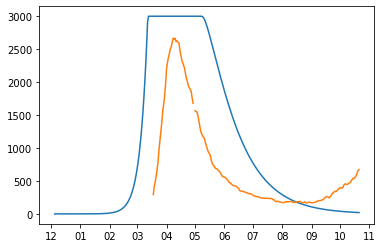

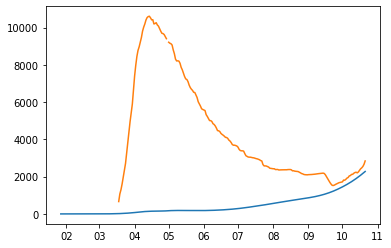

Deaths


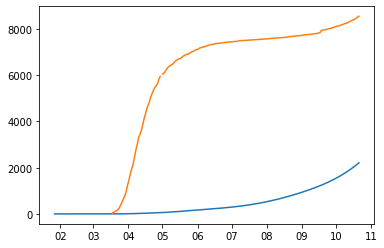

ICUs
best_error: 20.951018099134785
vector: [20.951018099134785]
mean_deaths 3.9846153640883273
[5.41354455e+01 1.96349035e+00 6.84542983e-01 7.15095700e-01
 1.86689894e-01 1.89571447e-02 6.43234508e-01 1.19832440e-01
 5.01758553e-01 1.58310641e+00 1.33610803e+00 1.93877785e+00
 5.48157209e-01 3.34823581e+01]
Beds


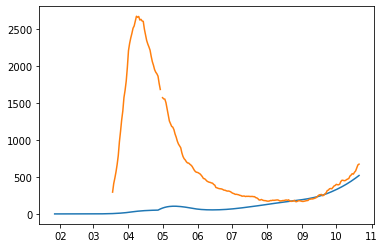

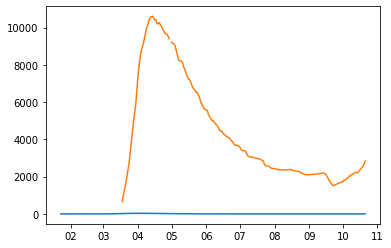

Deaths


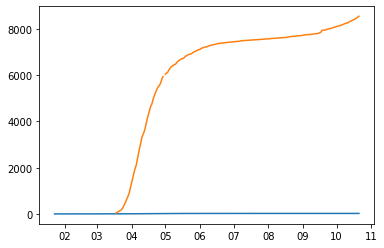

best_error: 37.34144012855283
ICUs
vector: [37.34144012855283]
mean_deaths 14.7274764560343
[1.01360669e+02 1.77990303e+00 8.61890562e-01 9.21756081e-01
 1.56964632e-02 5.69372159e-02 1.37409690e-01 1.25858894e-01
 8.99085551e-01 1.43168011e+00 1.40917266e+00 1.66761878e+00
 1.24124971e+00 9.41989242e+00]
Beds
best_error: 9.712419659031601
vector: [9.712419659031601]
mean_deaths 1.0963120555669068
[7.90105618e+01 2.88077078e-01 5.35902781e-01 8.45100672e-01
 6.08133562e-01 3.29648084e-02 8.40990408e-02 1.72344447e-01
 8.80633518e-01 8.27892452e-01 1.29275110e+00 1.05009844e+00
 1.79443130e+00 3.70750668e+00]
Beds


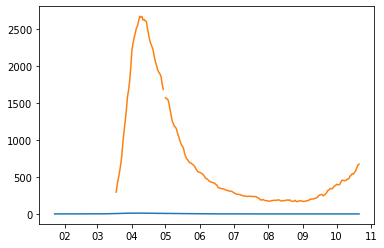

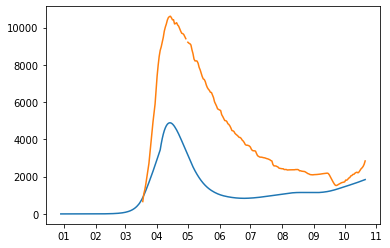

Deaths


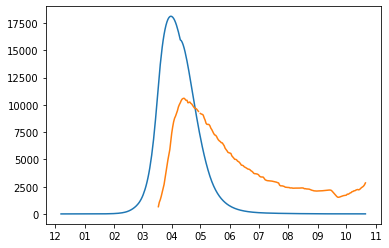

Deaths
best_error: 93.75139159680643
vector: [93.75139159680643]
mean_deaths 15.651439240905754
[9.82316872e+01 8.16568750e-01 8.94008702e-01 7.44886331e-01
 5.79287580e-01 2.90520224e-02 6.76760165e-01 3.84167338e-02
 5.52705458e-01 1.59139402e+00 5.14325075e-01 8.26362581e-01
 1.87648328e+00 3.55196207e+01]
Beds


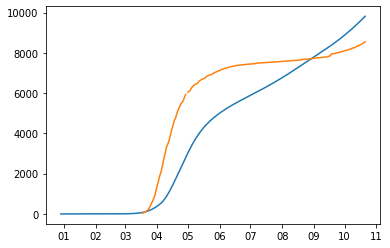

ICUs


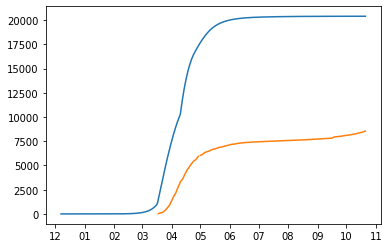

ICUs


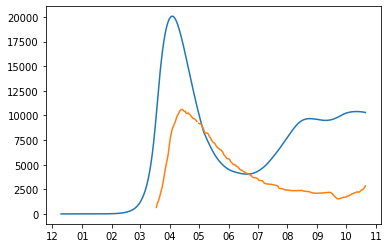

Deaths


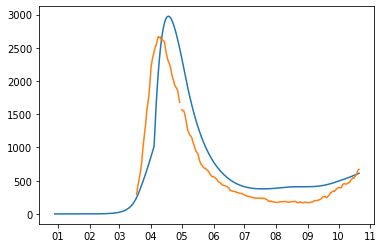

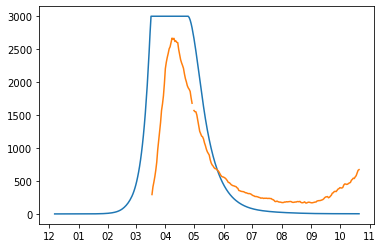

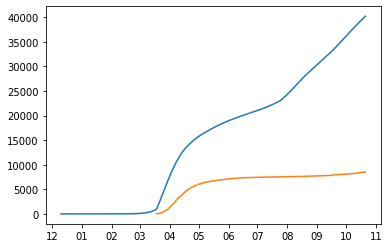

ICUs
best_error: 11.700447938727521
vector: [11.700447938727521]
mean_deaths 2.829638204737434
[8.06608297e+01 5.59562511e-01 6.14947751e-01 6.34747891e-01
 7.09006162e-01 1.19813856e-02 1.96909689e-01 1.63597023e-01
 7.67755450e-01 5.61926321e-01 1.16378143e+00 1.28226225e+00
 9.86435545e-01 5.90222101e+01]
Beds


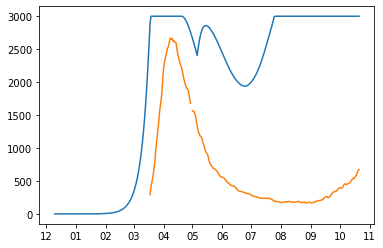

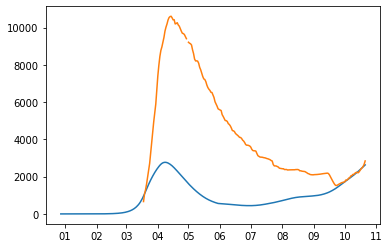

Deaths


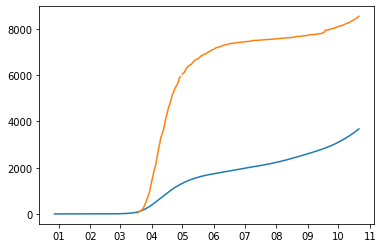

ICUs


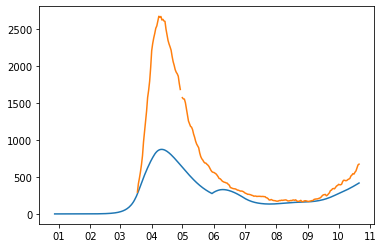

best_error: 19.19309828558095
vector: [19.19309828558095]
mean_deaths 3.933704639318361
[6.24380077e+01 1.82609031e+00 7.56497019e-01 8.98205468e-01
 9.47534270e-01 4.73038585e-02 1.61033605e-01 1.02083817e-01
 9.92504920e-01 1.70742000e+00 1.50189648e+00 6.53104518e-01
 5.63975511e-01 1.99165746e+01]
Beds
best_error: 12.82760627139249


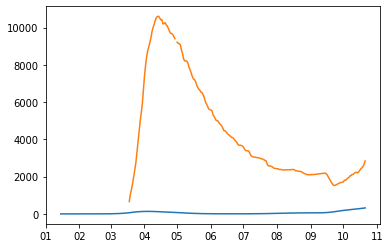

vector: [12.82760627139249]
Deaths
mean_deaths 3.0869669730297504
[77.21175394  0.52980394  0.59916133  0.54262241  0.37920437  0.09289592
  0.98081846  0.19160331  0.56318482  0.52489218  0.92263017  1.39928041
  0.83198725 26.75215198]
Beds


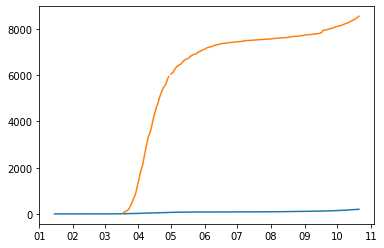

ICUs


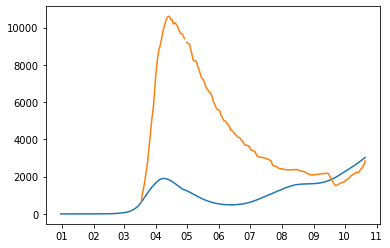

Deaths


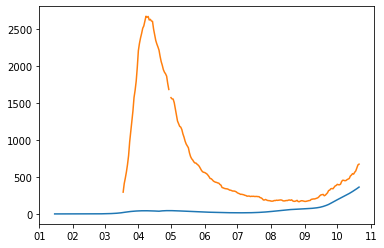

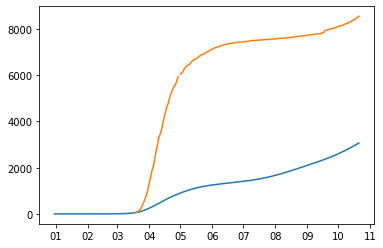

ICUs


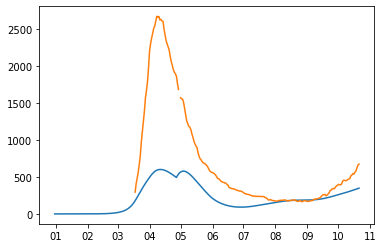

best_error: 29.309581926309107
vector: [29.309581926309107]
mean_deaths 8.66162418986384
[9.43213002e+01 5.98897603e-01 5.76158455e-01 5.56542994e-01
 9.00465470e-01 3.54837401e-02 3.67610283e-01 1.67229745e-01
 9.40638989e-01 7.48578872e-01 1.75863079e+00 1.95852710e+00
 9.35482100e-01 5.12963034e+00]
Beds
best_error: 20.56402616942024
vector: [20.56402616942024]
mean_deaths 3.973129582604464
[5.53445995e+01 1.76245723e+00 8.37564421e-01 5.83335454e-01
 6.12009754e-01 5.12365724e-02 3.16205654e-01 1.12024487e-01
 5.04907966e-01 8.96847022e-01 6.24353763e-01 7.00743514e-01
 8.90153055e-01 6.55402735e+00]
Beds


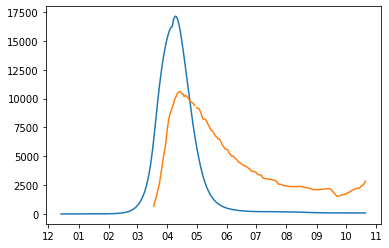

Deaths


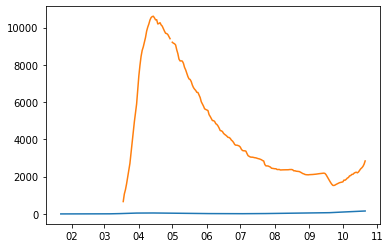

Deaths


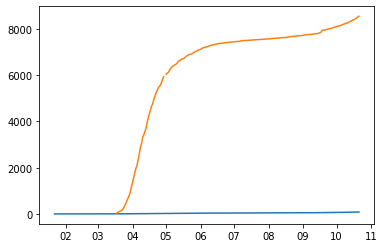

ICUs


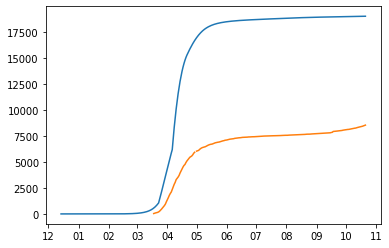

ICUs


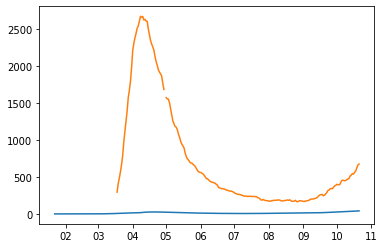

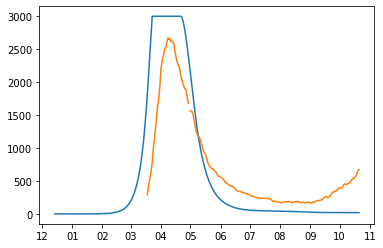

best_error: 14.646806740966833
vector: [14.646806740966833]
mean_deaths 2.8279080383229283
[8.31964694e+01 1.63525809e+00 7.93255649e-01 5.47937564e-02
 3.58574917e-01 9.39689044e-02 1.29874468e-01 9.96675408e-03
 6.47581671e-01 5.07359203e-01 1.49980081e+00 8.79961247e-01
 1.26830233e+00 2.13639079e+01]
Beds


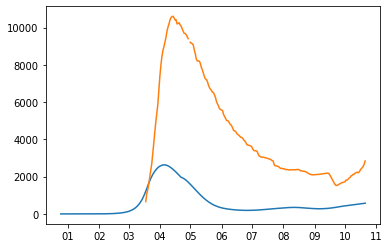

Deaths


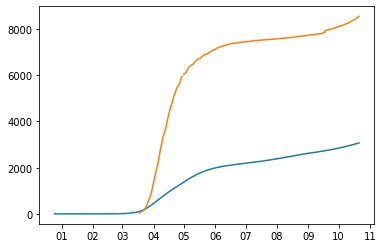

ICUs


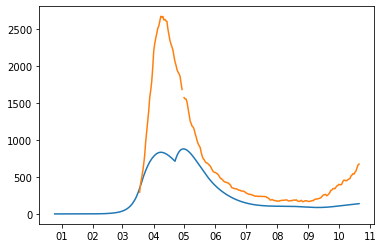

best_error: 13.42498360018111
vector: [13.42498360018111]
mean_deaths 2.5947349504048884
[6.55805302e+01 1.86287472e-01 5.22942835e-01 8.16839613e-01
 2.97646356e-01 8.12806172e-02 8.39665539e-01 3.42308911e-02
 8.67123444e-01 5.17064417e-01 1.89881236e+00 1.01270775e+00
 1.49698052e+00 8.00001937e+00]
Beds


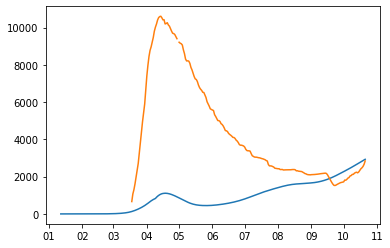

Deaths


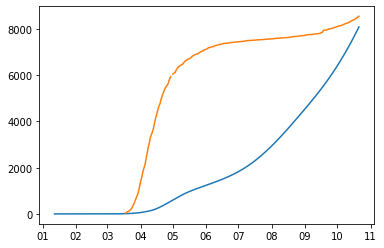

ICUs


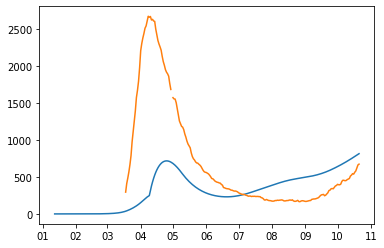

best_error: 12.507962879497107
vector: [12.507962879497107]
mean_deaths 1.6155643272282034
[9.24995615e+01 7.94214138e-01 5.44794404e-01 8.71923214e-01
 6.45857108e-01 2.53980296e-02 9.56565482e-01 5.77074203e-02
 5.59396227e-01 6.71248367e-01 1.44908100e+00 5.95351986e-01
 1.44305738e+00 3.22720710e+01]
Beds
best_error: 74.59945409834341
vector: [74.59945409834341]
mean_deaths 47.982615756188025
[1.06224476e+02 1.59775680e+00 6.01571980e-01 7.12876912e-01
 7.52543310e-01 7.59653964e-02 6.58935640e-02 1.88896277e-01
 7.83309970e-01 6.20189193e-01 1.46179130e+00 1.35878530e+00
 1.69529075e+00 1.94446488e+01]
Beds


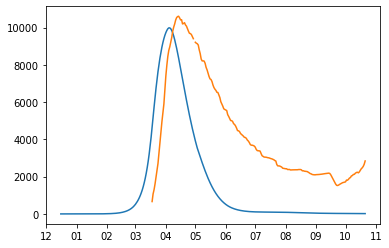

Deaths


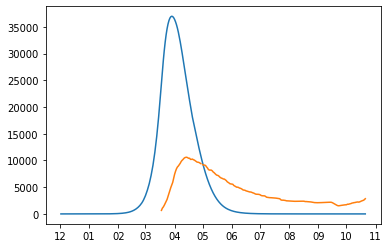

Deaths


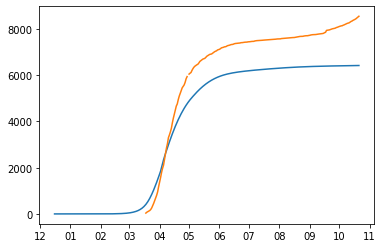

ICUs


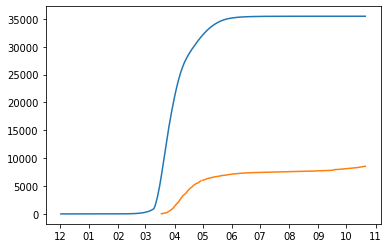

ICUs


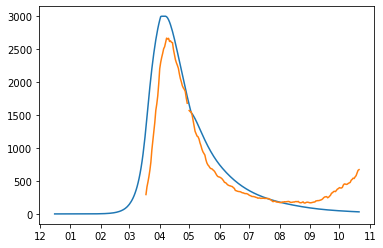

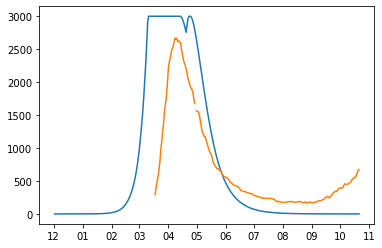

best_error: 20.81912667678411
vector: [20.81912667678411]
mean_deaths 3.9549497552801296
[57.14704424  1.1417453   0.70426411  0.66575517  0.17588476  0.06199153
  0.05718966  0.17941113  0.97810007  0.91722353  1.70093893  0.95166098
  1.80323399  0.97770395]
Beds
best_error: 16.79955462889798
vector: [16.79955462889798]
mean_deaths 3.6527838701235784
[7.28156655e+01 1.48504664e+00 7.80430700e-01 7.29206216e-01
 7.97119970e-01 2.46629176e-03 9.18236082e-01 1.68253593e-01
 8.73180930e-01 5.15479173e-01 1.67265090e+00 1.09087847e+00
 5.08913133e-01 2.42395159e+01]
Beds


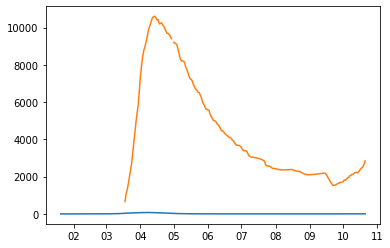

Deaths


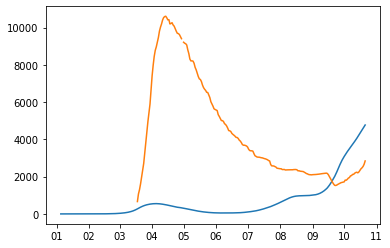

Deaths


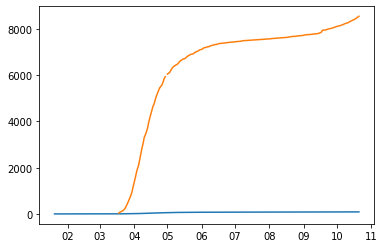

ICUs


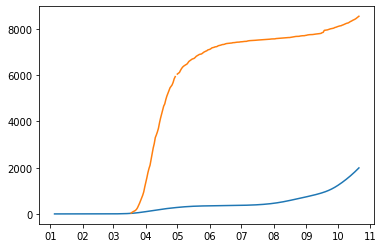

ICUs


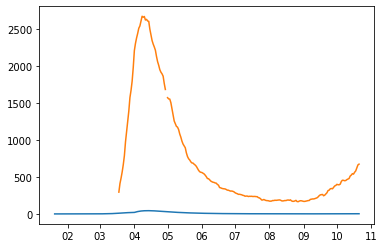

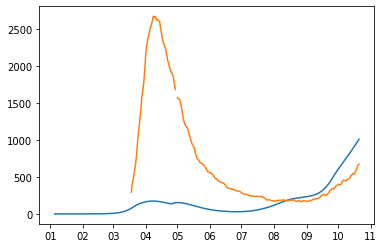

best_error: 15.554743996671167
vector: [15.554743996671167]
mean_deaths 2.731600426066393
[6.24727158e+01 2.06042795e-01 5.25294319e-01 1.99547623e-01
 6.68322372e-01 9.73920897e-02 3.64302280e-01 4.69027878e-02
 8.57681422e-01 1.05548961e+00 1.26220668e+00 1.57393202e+00
 1.96250918e+00 1.09390610e+01]
Beds


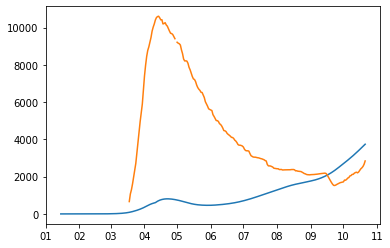

Deaths


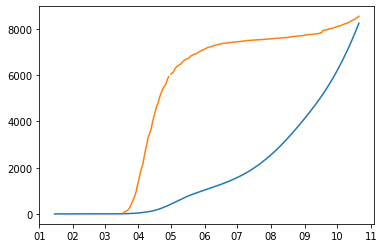

ICUs


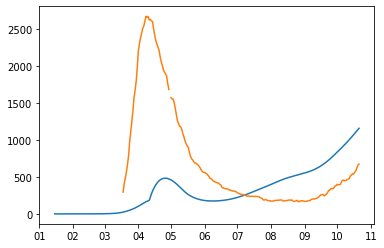

best_error: 18.02128638812333
vector: [18.02128638812333]
mean_deaths 3.539821869421913
[7.53608255e+01 9.56468218e-01 5.96384092e-01 3.93345075e-02
 7.29367382e-01 1.84131114e-03 4.25864964e-01 1.20475830e-01
 7.67067727e-01 5.91585821e-01 1.24645542e+00 5.85464065e-01
 6.44916776e-01 9.41542174e+00]
Beds


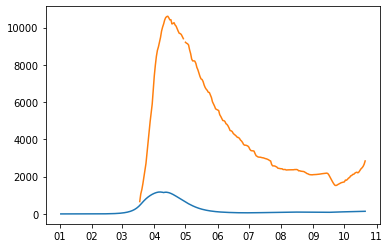

Deaths


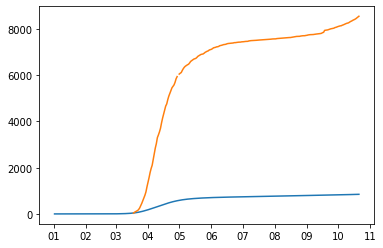

ICUs


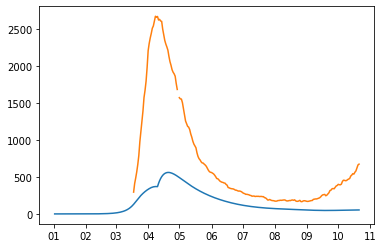

best_error: 19.909428832724412
vector: [19.909428832724412]
mean_deaths 3.7200215670099235
[7.22640888e+01 1.60356935e+00 5.73687471e-01 2.25677047e-01
 6.12103512e-01 1.93490245e-02 5.12564850e-02 4.61998312e-02
 7.28618120e-01 1.92516418e+00 1.22950638e+00 1.06988369e+00
 1.21148148e+00 2.06730491e+00]
Beds


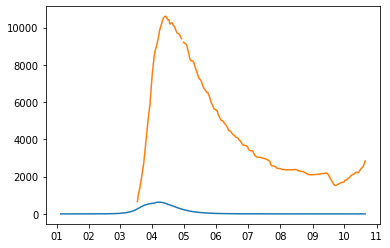

Deaths


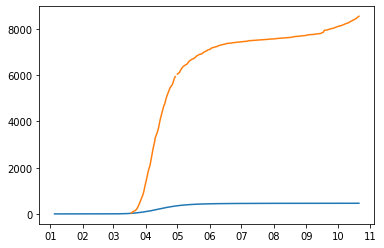

ICUs


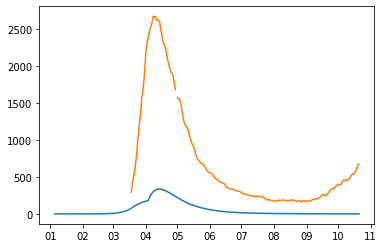

best_error: 12.811455986050351
vector: [12.811455986050351]
mean_deaths 1.8923370279418086
[8.92687928e+01 7.28216662e-01 5.20908085e-01 6.30220608e-01
 5.44754022e-01 3.89535477e-02 3.10673199e-01 1.17733319e-01
 6.33903762e-01 7.31547199e-01 1.41479561e+00 8.44663428e-01
 1.28226414e+00 1.47422588e+01]
Beds


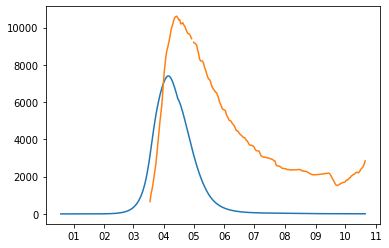

Deaths


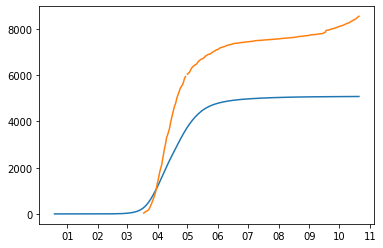

ICUs


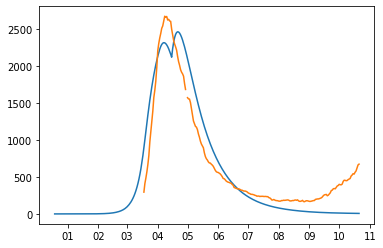

best_error: 15.976172258273118
vector: [15.976172258273118]
mean_deaths 3.6734660017852048
[6.45828476e+01 3.79586005e-01 5.76462424e-01 4.56796409e-01
 6.17059693e-01 1.01681126e-02 1.36281483e-01 1.70218532e-01
 7.88670892e-01 5.17782251e-01 9.04245781e-01 6.88144509e-01
 1.75040845e+00 5.83435202e+01]
Beds
best_error: 16.36980964022097
vector: [16.36980964022097]
mean_deaths 2.816881124145556
[8.20742042e+01 5.75586574e-01 5.17158333e-01 5.80918191e-01
 4.34744330e-01 1.72105740e-02 4.02342216e-01 1.72535691e-01
 5.07213335e-01 1.00222315e+00 1.67342554e+00 1.60231151e+00
 1.83347121e+00 3.94464961e+01]
Beds


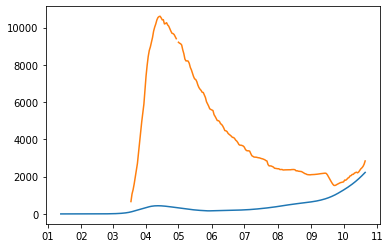

Deaths
best_error: 20.276643515267214
vector: [20.276643515267214]
mean_deaths 3.855071482951241
[6.42922714e+01 4.97006643e-01 5.29701998e-01 5.23876159e-02
 3.40587146e-01 3.26893350e-02 1.12151326e-01 1.74979714e-01
 9.98189113e-01 7.16022920e-01 1.83022997e+00 1.09350083e+00
 6.35693188e-01 3.54924030e+01]
Beds


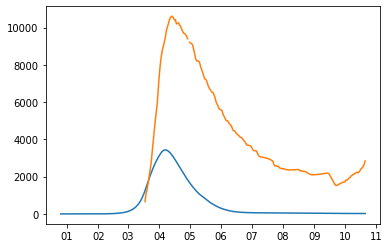

Deaths


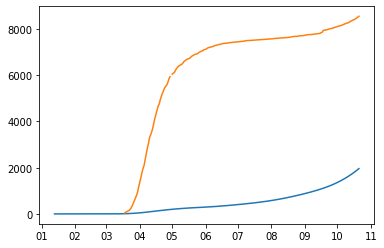

ICUs


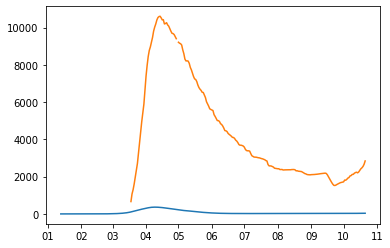

Deaths


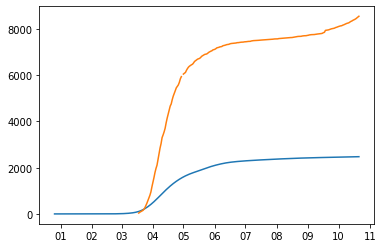

ICUs


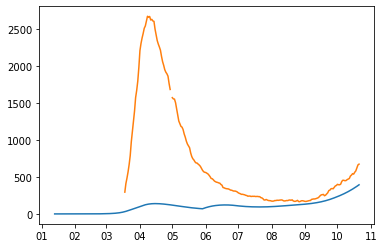

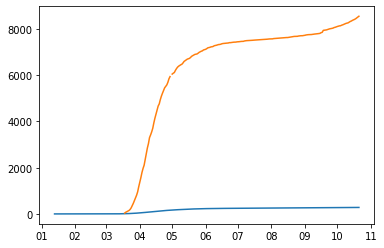

ICUs


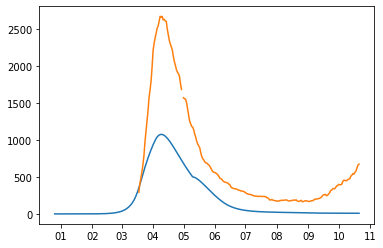

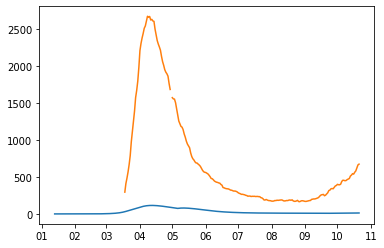

best_error: 18.724031809112212
vector: [18.724031809112212]
mean_deaths 3.8832670605132886
[6.24380077e+01 7.66490812e-01 7.56497019e-01 8.98205468e-01
 3.80141687e-01 4.56609838e-02 2.17903360e-01 1.60481992e-01
 9.92504920e-01 1.70742000e+00 9.82248765e-01 6.53104518e-01
 1.01065712e+00 4.54067513e+01]
Beds


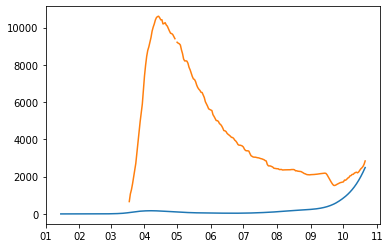

Deaths
best_error: 11.857247086582431
vector: [11.857247086582431]
mean_deaths 1.2505436017214506
[9.39061316e+01 1.59103816e+00 8.40734402e-01 8.55717579e-01
 5.25153132e-01 3.28271886e-02 3.88664464e-01 1.21640460e-01
 8.73905071e-01 5.08819863e-01 1.56237266e+00 1.24172948e+00
 1.44379999e+00 8.74078845e+00]

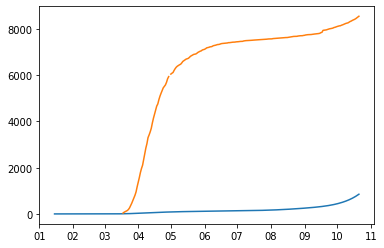


ICUs
Beds


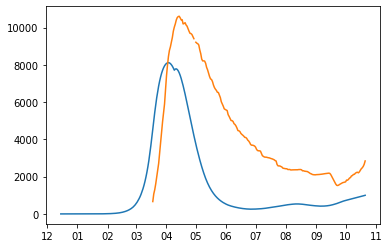

Deaths


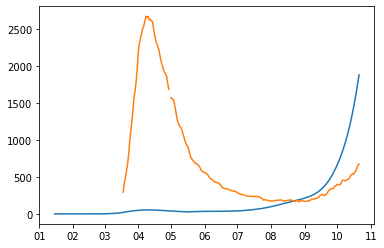

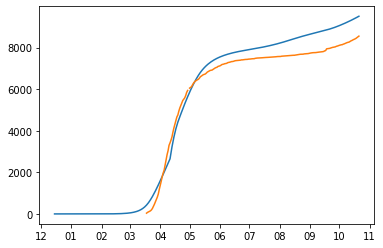

ICUs


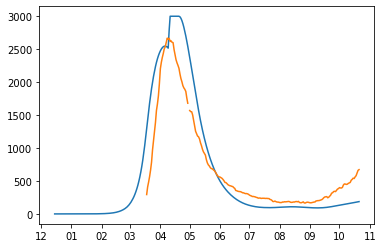

best_error: 17.227422423646278
vector: [17.227422423646278]
mean_deaths 3.0296003404903797
[8.66726236e+01 1.32315730e+00 5.17673312e-01 8.62861192e-01
 6.20896028e-02 4.27180646e-03 2.04146126e-01 1.77916967e-01
 9.51409807e-01 8.91545623e-01 7.45230290e-01 1.34005903e+00
 1.29646906e+00 2.27103925e+01]
Beds
best_error: 9.04590356307539
vector: [9.04590356307539]
mean_deaths 1.167908936425924
[8.54560226e+01 4.65655414e-01 5.82476615e-01 5.97380806e-01
 4.48796497e-01 5.02897477e-02 5.39680674e-01 5.80899677e-02
 9.08213853e-01 7.73313834e-01 9.39767697e-01 9.29441555e-01
 1.87465175e+00 1.93027069e+01]
Beds


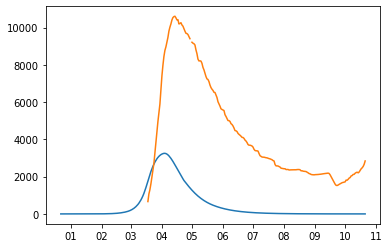

Deaths


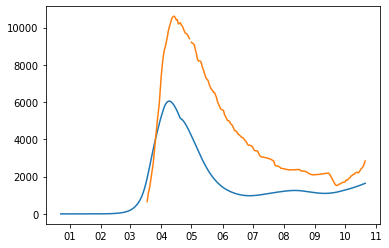

Deaths


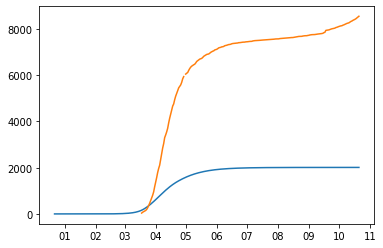

ICUs


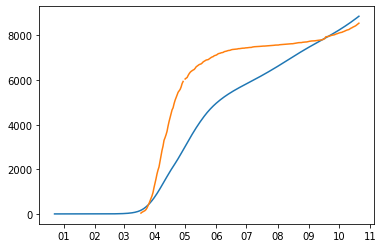

ICUs


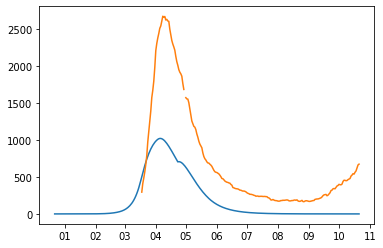

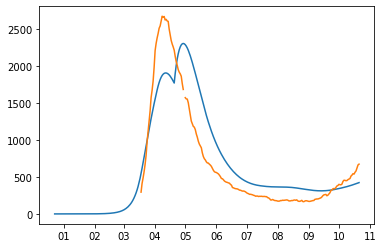

best_error: 12.243089234832066
vector: [12.243089234832066]
mean_deaths 2.3382158210723514
[7.98932130e+01 5.32873158e-01 6.16788565e-01 7.24125050e-01
 5.50994092e-01 6.06563752e-02 1.36474807e-01 1.81408577e-01
 9.66690785e-01 1.16007363e+00 1.59974622e+00 1.13368078e+00
 1.73857553e+00 3.83973442e+00]
Beds


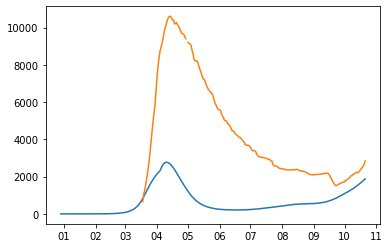

Deaths


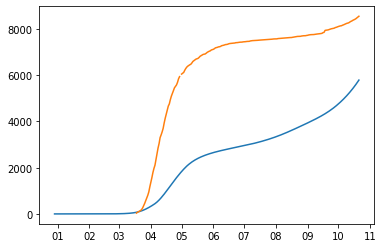

ICUs


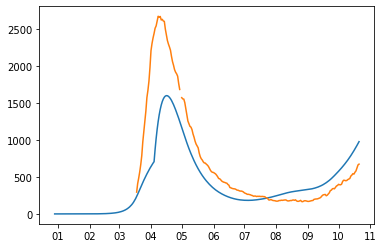

best_error: 10.639859773304888
vector: [10.639859773304888]
mean_deaths 2.6028503681944124
[8.16001736e+01 5.29803942e-01 5.99161328e-01 6.47532384e-01
 7.05066789e-01 4.02438085e-02 4.56180225e-01 1.91603314e-01
 8.97866542e-01 9.00521529e-01 9.22630166e-01 1.34979958e+00
 1.15584762e+00 5.77562880e+01]
Beds


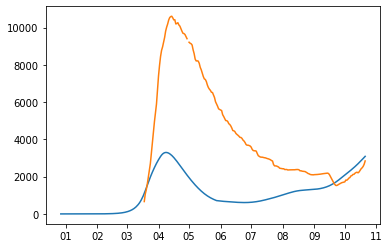

Deaths


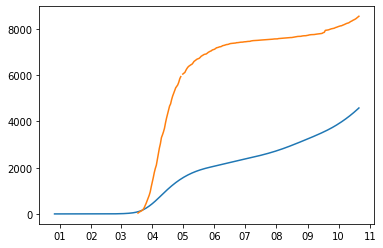

ICUs


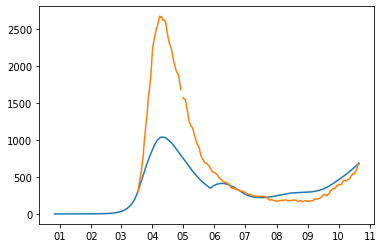

best_error: 11.758733237987032
vector: [11.758733237987032]
mean_deaths 2.439127975972619
[8.18435131e+01 5.98897603e-01 6.42858915e-01 5.56542994e-01
 2.44169485e-01 7.63694931e-02 6.31390972e-02 8.89936250e-03
 8.55027900e-01 9.71120272e-01 1.35110972e+00 1.11679280e+00
 1.56824173e+00 1.13186342e+01]
Beds


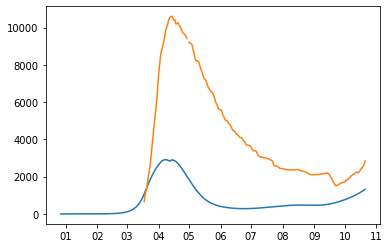

Deaths


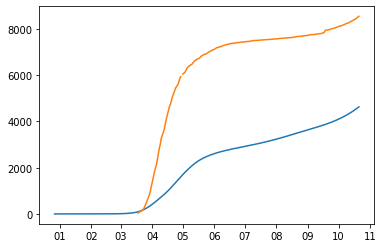

ICUs


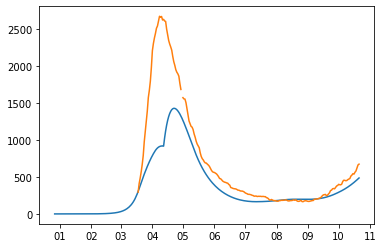

best_error: 13.09926821648342
vector: [13.09926821648342]
mean_deaths 2.6505676974616654
[8.49241307e+01 8.05295360e-01 6.32744939e-01 4.80528802e-01
 5.75411013e-01 2.78740288e-02 1.07735605e-01 1.58246840e-01
 8.14155341e-01 8.08161170e-01 8.97519668e-01 7.26093643e-01
 1.47523863e+00 3.25180308e+01]
Beds


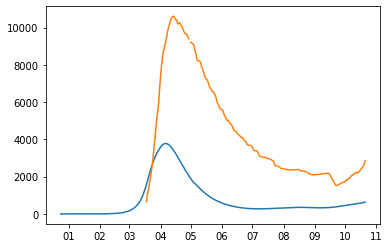

Deaths


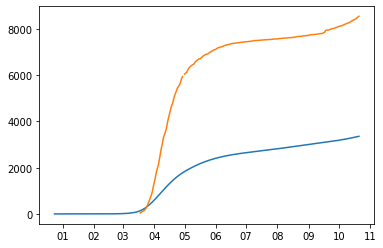

ICUs


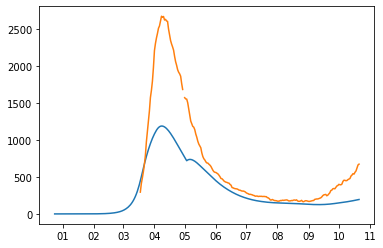

best_error: 11.868217846840837
vector: [11.868217846840837]
mean_deaths 2.2065816617143845
[8.47979168e+01 1.06337718e+00 7.92642412e-01 6.33437084e-01
 2.73607484e-01 5.54933320e-02 4.46851286e-01 9.94935623e-02
 8.68968544e-01 1.00625473e+00 1.23461930e+00 1.25459386e+00
 1.91026637e+00 1.23214422e+01]
Beds


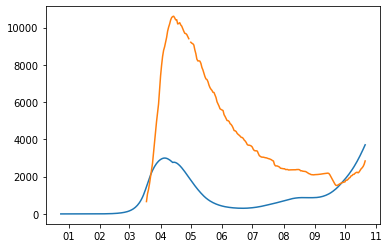

Deaths


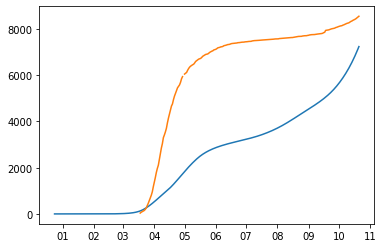

ICUs


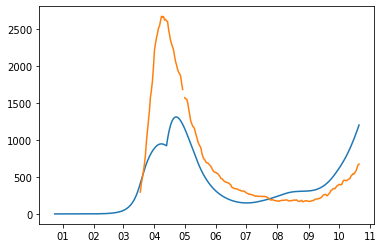

best_error: 12.264533470094173
vector: [12.264533470094173]
mean_deaths 2.3310110370011214
[8.85151780e+01 1.07219827e+00 6.60544936e-01 6.50367837e-01
 7.38174117e-01 6.02870000e-02 5.91002764e-01 1.96307430e-01
 8.58468341e-01 5.18647569e-01 7.87414005e-01 8.63300308e-01
 1.24530908e+00 2.39131559e+01]
Beds


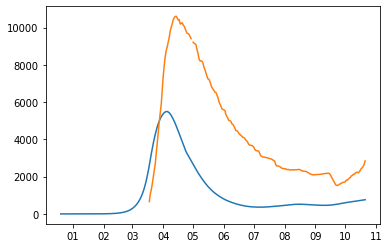

Deaths


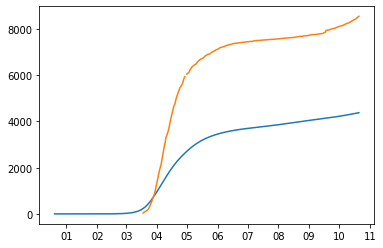

ICUs


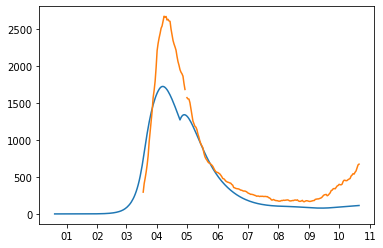

best_error: 8.512684775207541
vector: [8.512684775207541]
mean_deaths 1.8289182488541849
[8.16056475e+01 5.49079676e-01 6.11970483e-01 2.69194869e-02
 1.02580190e-01 6.79048433e-02 6.12540921e-01 1.26409796e-01
 9.34377183e-01 5.12130546e-01 9.31790993e-01 9.41188895e-01
 1.56087521e+00 4.67197704e+00]
Beds


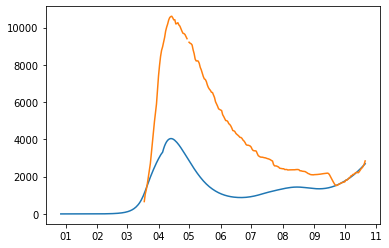

Deaths


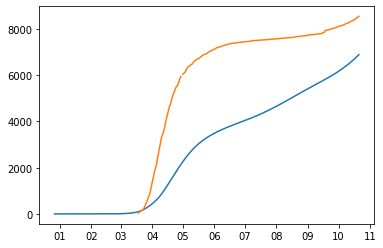

ICUs


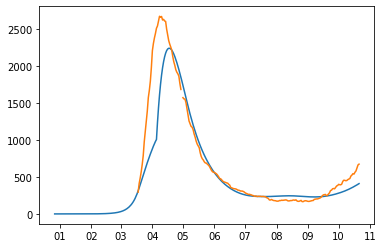

best_error: 12.11997566052309
vector: [12.11997566052309]
mean_deaths 1.4426028418081285
[9.16808884e+01 1.02215352e+00 8.79548522e-01 5.49291947e-01
 2.76213324e-03 5.44527594e-02 2.05251460e-02 6.77931350e-02
 6.30838643e-01 1.25117164e+00 1.10096406e+00 1.90076542e+00
 1.12820328e+00 3.60487153e+01]
Beds


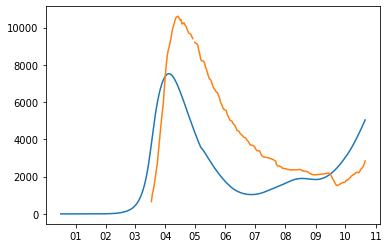

Deaths


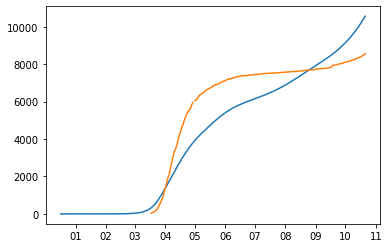

ICUs


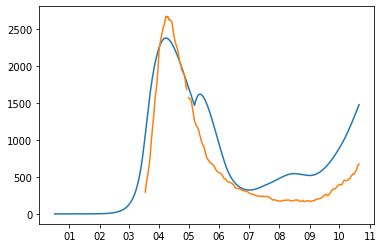

best_error: 11.652073708960561
vector: [11.652073708960561]
mean_deaths 1.2367737150935516
[92.49956146  0.76327203  0.68203715  0.4805966   0.19146815  0.09499146
  0.3164042   0.13396813  0.63044919  1.35787272  0.54060557  0.80259967
  0.76120432 58.62636133]
Beds


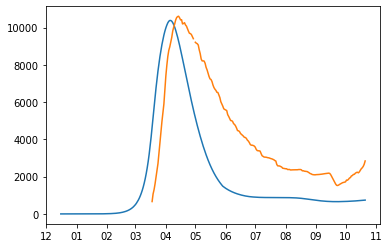

Deaths


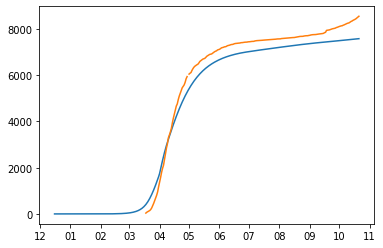

ICUs


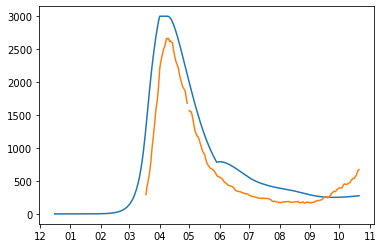

best_error: 7.8362984024486
vector: [7.8362984024486]
mean_deaths 1.6327878379965814
[8.52778513e+01 4.65390592e-01 5.63965186e-01 7.07936926e-01
 7.62438482e-01 6.69976575e-02 6.66010784e-01 1.22487568e-01
 6.99226859e-01 7.90553793e-01 6.80779942e-01 1.56163133e+00
 1.61906367e+00 3.82584054e+01]
Beds


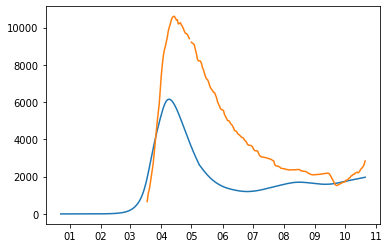

Deaths


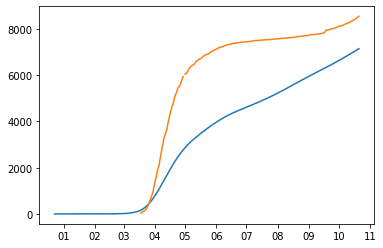

ICUs


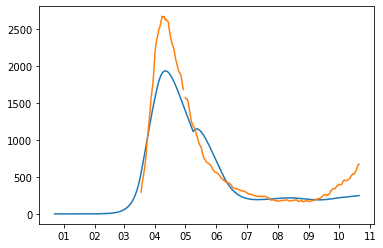

best_error: 9.629782529785015
vector: [9.629782529785015]
mean_deaths 1.649816698761905
[85.23897117  0.63213199  0.63918361  0.19563206  0.43270677  0.09204815
  0.28128835  0.12066263  0.80588242  1.03357527  0.92409268  1.04884367
  1.9629306  40.82322031]
Beds


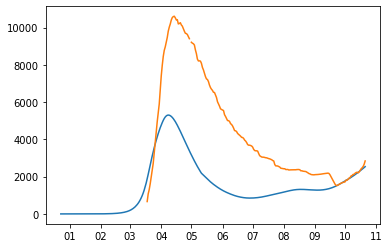

Deaths


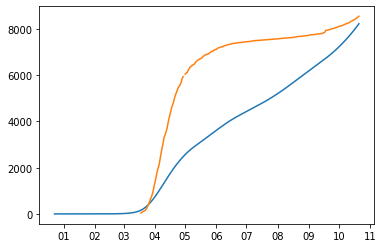

ICUs


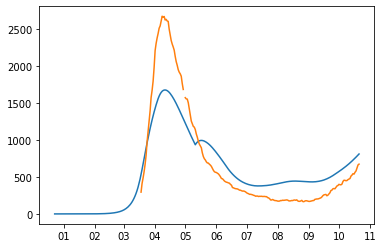

best_error: 9.506512559368831
vector: [9.506512559368831]
mean_deaths 1.2449279719725366
[89.58624008  0.98900062  0.72071947  0.47593097  0.55305868  0.09140734
  0.64500246  0.19336551  0.66131641  1.49983603  0.67980657  1.38606485
  1.81372504 10.06724625]
Beds


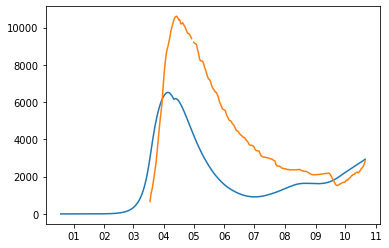

Deaths


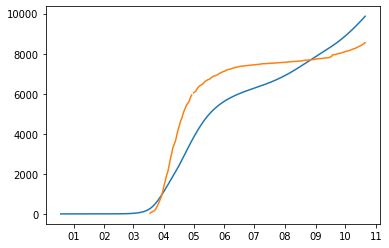

ICUs


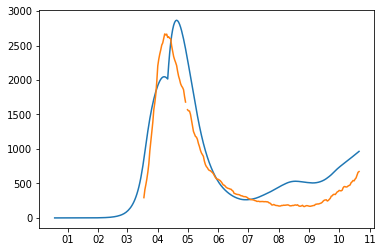

best_error: 11.219339391271793
vector: [11.219339391271793]
mean_deaths 2.671714776259039
[8.03555271e+01 8.45474690e-01 7.31919578e-01 1.11016878e-01
 3.33141744e-02 5.21218014e-02 3.37831030e-01 1.70528349e-01
 5.94910208e-01 5.48078747e-01 9.48330070e-01 8.91296279e-01
 1.45278790e+00 1.16357439e+01]
Beds


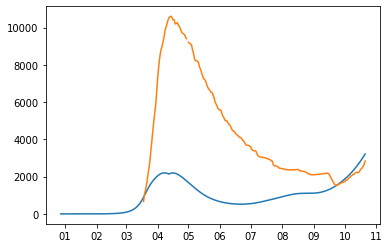

Deaths


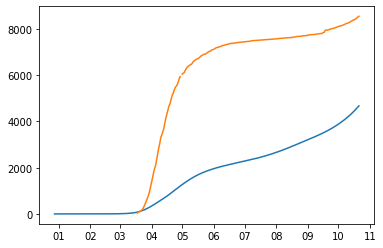

ICUs


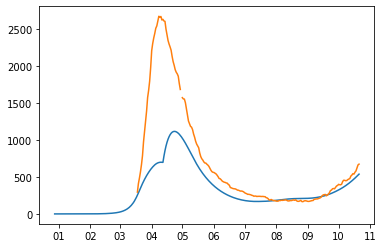

best_error: 13.121563756608227
vector: [13.121563756608227]
mean_deaths 1.6779386606630715
[9.16808884e+01 1.19843320e+00 8.79548522e-01 8.65769392e-01
 3.22445146e-01 3.45201703e-02 4.60832024e-01 1.18339283e-01
 7.29582032e-01 1.25117164e+00 1.93700916e+00 1.80696722e+00
 1.03053339e+00 4.95107635e+01]
Beds


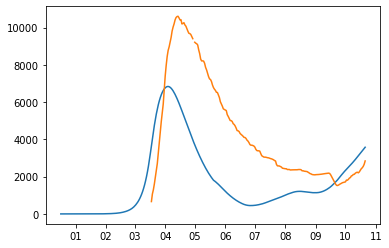

Deaths


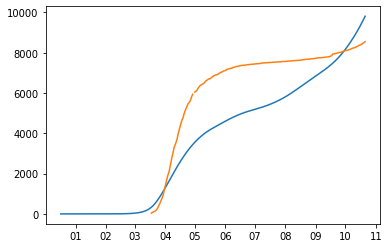

ICUs


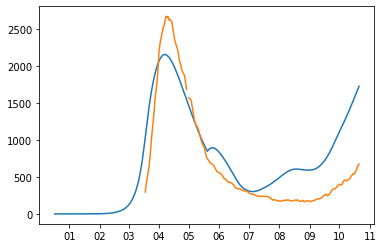

best_error: 11.087256659008078
vector: [11.087256659008078]
mean_deaths 1.3142925120908306
[9.24995615e+01 7.63272027e-01 6.82037145e-01 4.80596598e-01
 1.91468151e-01 5.32587487e-02 9.66135513e-01 9.35216819e-02
 6.30449190e-01 7.19606193e-01 1.36833103e+00 1.96592594e+00
 1.12604411e+00 2.07897608e+01]
Beds


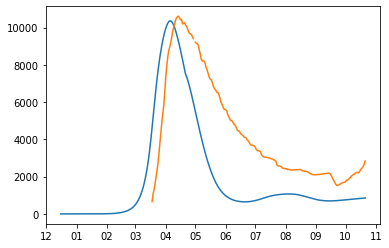

Deaths


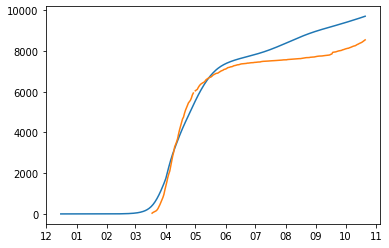

ICUs


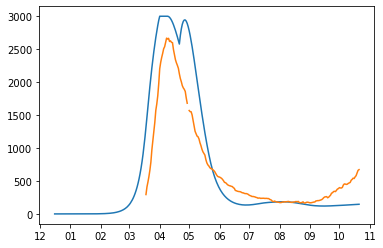

best_error: 10.006401439288076
vector: [10.006401439288076]
mean_deaths 1.4973574047769822
[8.61589681e+01 7.78015066e-01 5.96447453e-01 4.79868362e-01
 8.80898044e-01 7.51558316e-02 7.67889696e-01 1.00018353e-01
 7.42863621e-01 1.02366640e+00 6.86237768e-01 1.60839790e+00
 1.90992717e+00 6.90515322e+00]
Beds
best_error: 11.583036352209179
vector: [11.583036352209179]
mean_deaths 0.7353686890846919
[8.74219395e+01 3.60450481e-01 5.12257497e-01 2.68359998e-01
 6.90570004e-01 1.32651343e-02 3.12237507e-01 1.33971308e-01
 5.63712094e-01 1.84208870e+00 8.13852233e-01 1.28681457e+00
 1.15819702e+00 3.97544732e+01]
Beds


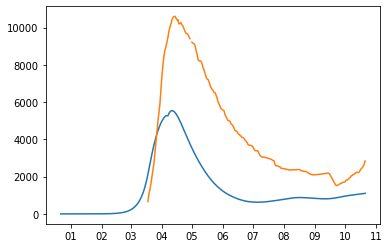

Deaths


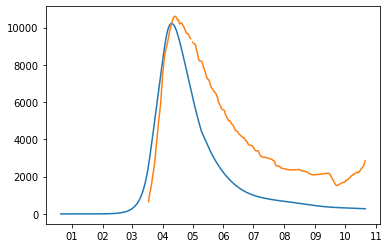

Deaths


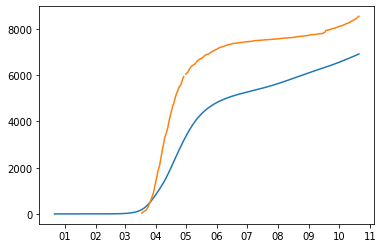

ICUs


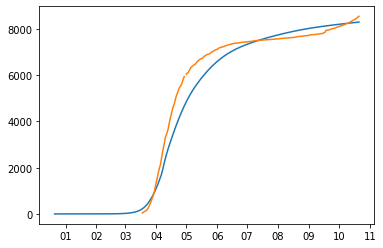

ICUs


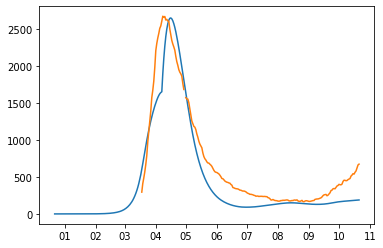

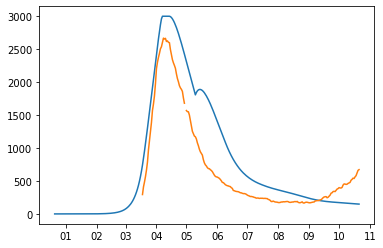

best_error: 8.095155293387679
vector: [8.095155293387679]
mean_deaths 1.1136845064061671
[8.97510148e+01 7.46440974e-01 6.71127494e-01 8.65329025e-02
 2.64586644e-01 5.09933368e-02 1.37948808e-01 1.90892112e-01
 7.92279184e-01 1.37165449e+00 9.64980103e-01 1.93176197e+00
 1.98118502e+00 2.21272815e+01]
Beds


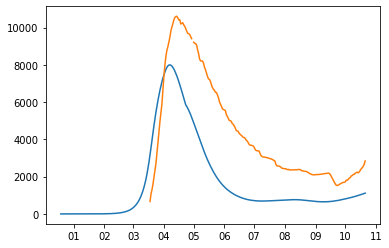

Deaths


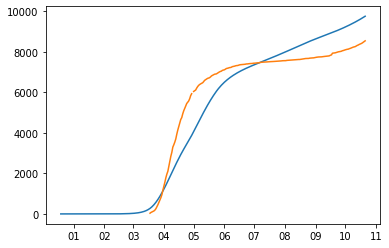

ICUs
best_error: 12.969075102314326
vector: [12.969075102314326]
mean_deaths 2.356429370813425
[85.45311628  0.63213199  0.56582161  0.98291434  0.96486681  0.09204815
  0.58490413  0.15325343  0.57849191  1.09917166  1.36172815  1.20605701
  1.72230365 33.28341452]
Beds


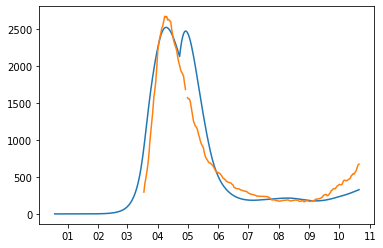

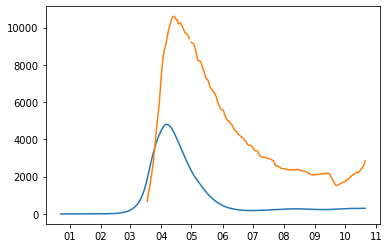

Deaths


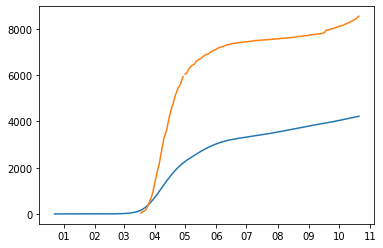

ICUs


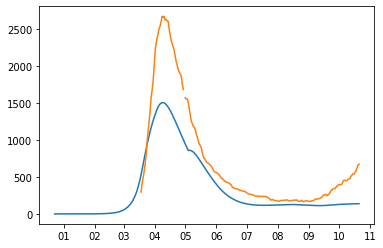

best_error: 11.72215894103561
vector: [11.72215894103561]
mean_deaths 1.6771263173524436
[9.09804290e+01 6.38583519e-01 5.44175591e-01 4.75976117e-01
 1.61897841e-01 4.11004230e-02 1.90973534e-01 1.78152278e-01
 6.77402779e-01 1.76772085e+00 1.67837373e+00 1.01171824e+00
 1.32675669e+00 3.65383253e+01]
Beds


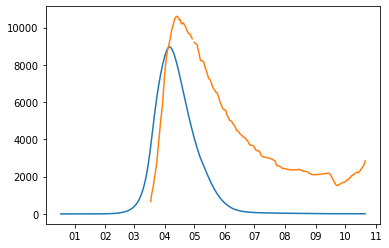

Deaths


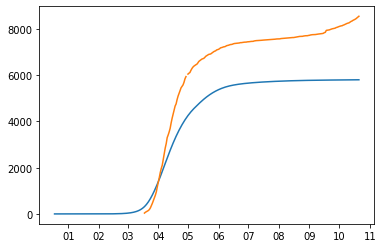

ICUs


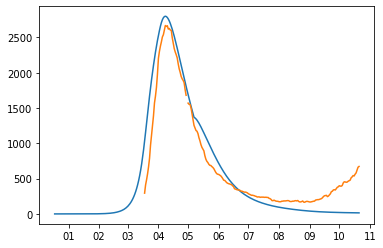

best_error: 11.410907965138986
vector: [11.410907965138986]
mean_deaths 1.3074612695438035
[9.24995615e+01 7.63272027e-01 6.82037145e-01 9.41918262e-01
 9.77836042e-01 5.73270599e-02 2.99118013e-01 3.66648041e-02
 7.42006249e-01 1.35515310e+00 1.86580128e+00 1.54455353e+00
 1.12604411e+00 3.97649606e+01]
Beds


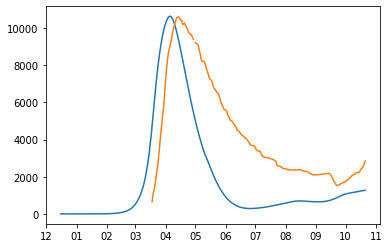

Deaths


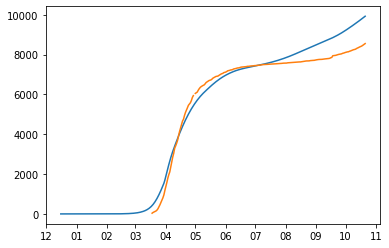

ICUs


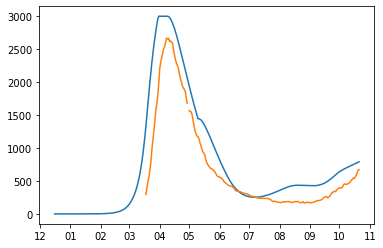

best_error: 11.548996309702655
vector: [11.548996309702655]
mean_deaths 1.3768952036543487
[8.52039818e+01 3.60450481e-01 5.12257497e-01 7.16229443e-01
 8.12090622e-01 9.14070417e-02 9.69985517e-01 5.53261895e-02
 6.44835526e-01 1.77575636e+00 8.67012903e-01 1.28681457e+00
 1.19670546e+00 5.55384586e+01]
Beds
best_error: 8.583541846703184
vector: [8.583541846703184]
mean_deaths 1.6277512043123752
[9.15515098e+01 1.31566499e+00 6.68203853e-01 1.44416245e-01
 9.91217997e-01 4.38055588e-02 6.82138182e-01 1.19434867e-01
 6.22817635e-01 1.29682780e+00 7.59098778e-01 1.35767898e+00
 9.85407042e-01 4.47175814e+01]
Beds


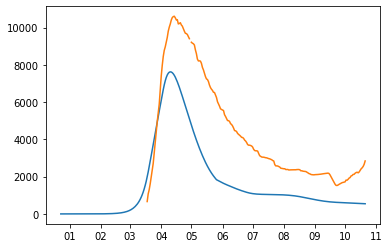

Deaths


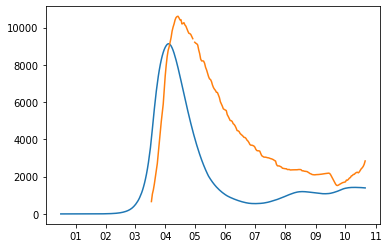

Deaths


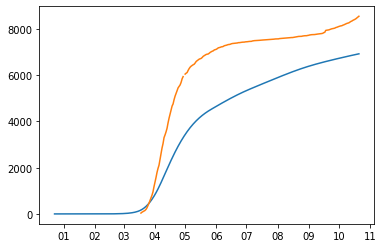

ICUs


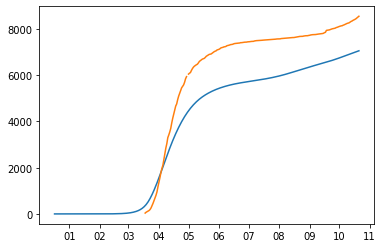

ICUs


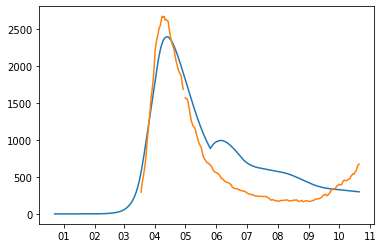

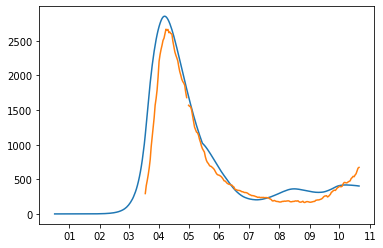

best_error: 12.854659976763724
vector: [12.854659976763724]
mean_deaths 2.5323161094575406
[8.31868878e+01 9.40706513e-01 7.09848275e-01 6.28101452e-01
 4.92572483e-01 5.03824215e-02 8.40468627e-01 1.00707439e-01
 8.55530258e-01 1.35187150e+00 1.62262913e+00 1.83604512e+00
 1.76520155e+00 4.87488686e+01]
Beds


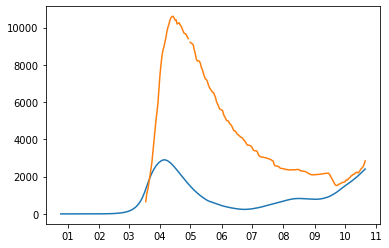

Deaths


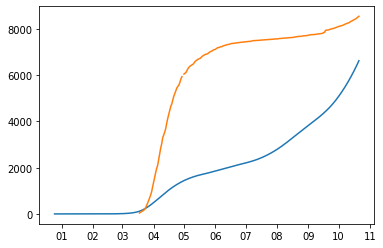

ICUs


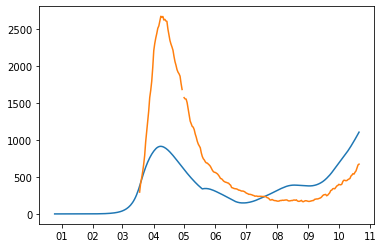

best_error: 12.655221148580832
vector: [12.655221148580832]
mean_deaths 2.2788390470044924
[82.3001575   0.74644097  0.65915465  0.0865329   0.75314733  0.09034108
  0.13794881  0.15904923  0.62854375  1.05836706  0.78347929  1.93176197
  1.35235916 25.2427596 ]
Beds


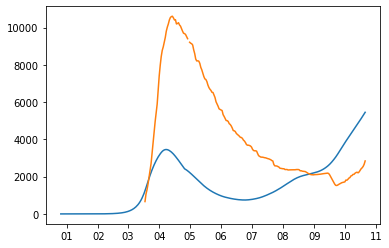

Deaths


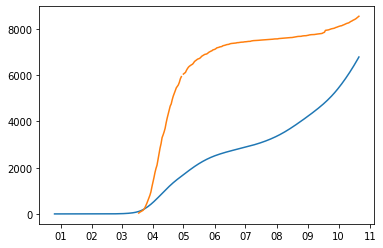

ICUs


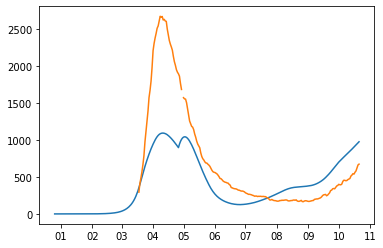

best_error: 12.011363489977583
vector: [12.011363489977583]
mean_deaths 2.921828396652907
[7.82213088e+01 4.75006793e-01 5.94787132e-01 7.21409828e-01
 4.48758765e-01 5.57108424e-02 8.13763227e-01 8.62688186e-02
 8.27197620e-01 6.18192543e-01 1.26194388e+00 1.98295266e+00
 8.18864452e-01 5.83089013e+01]
Beds


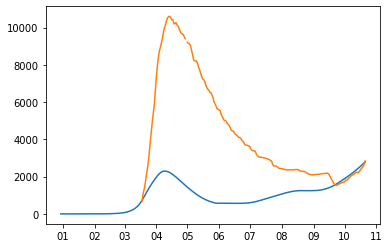

Deaths


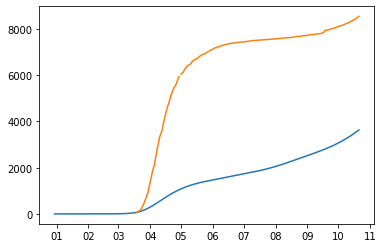

ICUs


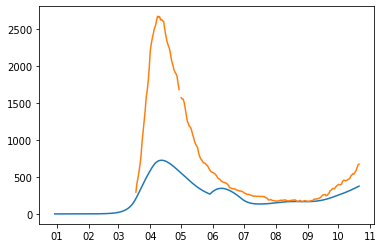

best_error: 12.698490337909227
vector: [12.698490337909227]
mean_deaths 2.295882083975637
[7.35561190e+01 2.19477617e-01 5.10653636e-01 8.46774003e-01
 7.65390589e-01 4.51252972e-02 3.74026174e-01 8.60506317e-02
 8.56493519e-01 6.50760135e-01 1.11280605e+00 9.57498905e-01
 1.59935390e+00 4.45757217e+01]
Beds


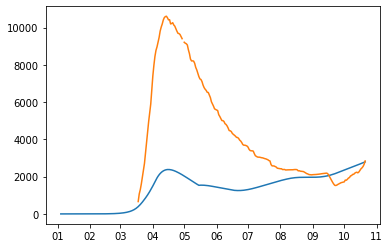

Deaths


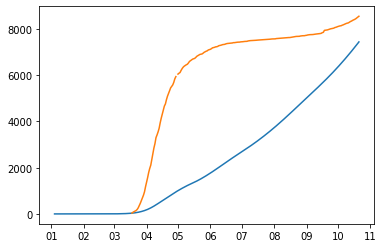

ICUs


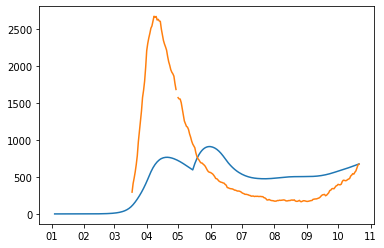

best_error: 10.015264998142705
vector: [10.015264998142705]
mean_deaths 2.240434706750225
[8.54560226e+01 7.63450898e-01 6.63933400e-01 9.81221122e-01
 7.44883856e-01 9.52592974e-02 5.39680674e-01 5.80899677e-02
 8.16380355e-01 8.57072619e-01 9.39767697e-01 9.29441555e-01
 1.57952926e+00 1.93027069e+01]
Beds


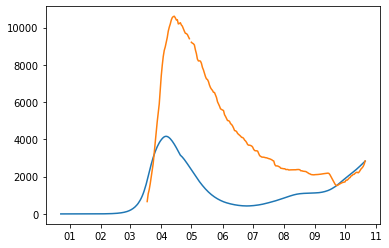

Deaths


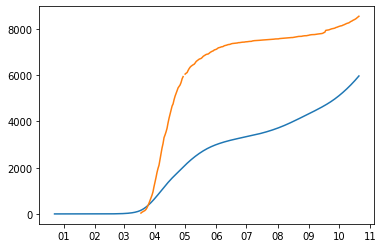

ICUs


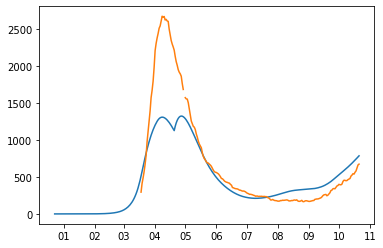

best_error: 7.868689642348864
vector: [7.868689642348864]
mean_deaths 1.0132595038324945
[8.32759432e+01 2.84792760e-01 5.16296420e-01 7.78089362e-01
 7.88650903e-01 5.91604595e-02 2.82151362e-01 1.44634338e-01
 7.30047012e-01 7.48882865e-01 1.00991384e+00 1.65523138e+00
 1.32740893e+00 3.01445124e+01]
Beds


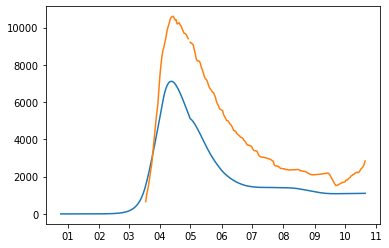

Deaths


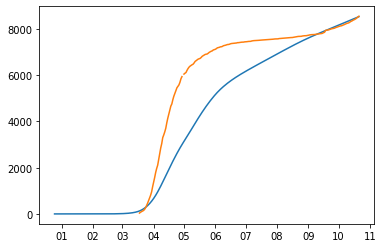

ICUs


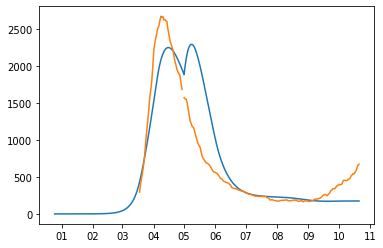

best_error: 9.21190436082737
vector: [9.21190436082737]
mean_deaths 1.404771550001004
[9.22031560e+01 9.84012723e-01 7.07202304e-01 5.50693608e-01
 5.66260115e-01 6.95506341e-02 7.34638912e-01 1.33027002e-01
 6.98534195e-01 1.29470979e+00 1.04738413e+00 1.15128082e+00
 1.73832160e+00 4.12592368e+01]
Beds


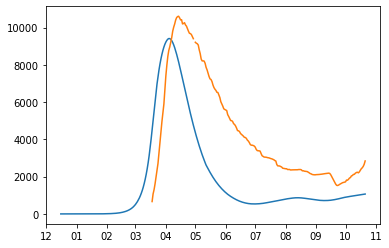

Deaths


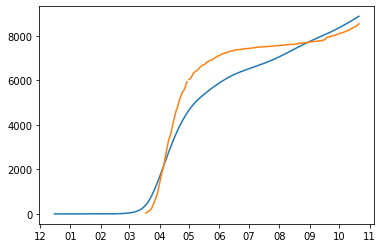

ICUs


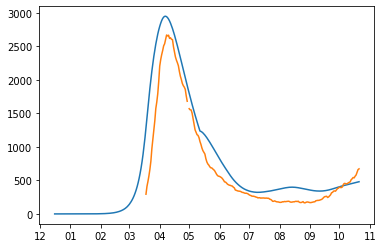

best_error: 10.387675352409701
vector: [10.387675352409701]
mean_deaths 1.4324034251772104
[9.10742571e+01 5.68878994e-01 6.71737042e-01 6.12517486e-01
 1.90638619e-01 5.61039535e-02 5.44635115e-01 1.19243730e-01
 7.72263019e-01 9.82049774e-01 7.87450566e-01 1.62378616e+00
 1.22347620e+00 5.56876555e+01]
Beds


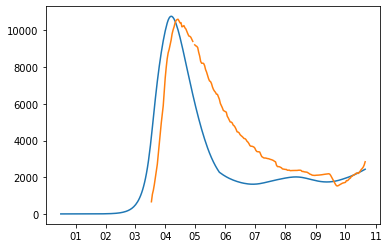

Deaths


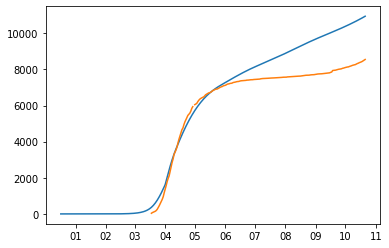

ICUs


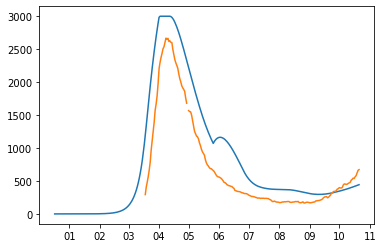

best_error: 11.328369728237902
vector: [11.328369728237902]
mean_deaths 2.0022136230374517
[8.52778513e+01 4.65390592e-01 5.45985960e-01 8.98770691e-01
 5.80102039e-01 4.97722860e-02 7.18680037e-01 1.22487568e-01
 6.31191394e-01 7.90553793e-01 6.12816906e-01 1.73410031e+00
 1.52199803e+00 3.41157942e+01]
Beds


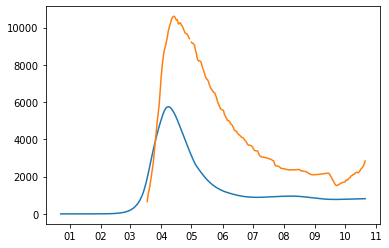

Deaths


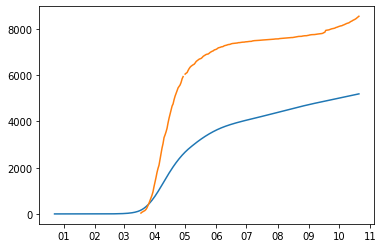

ICUs


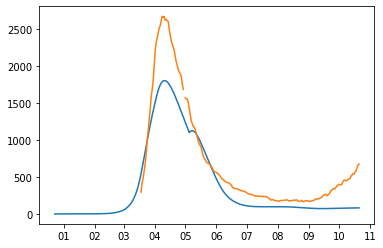

best_error: 10.726269866166401
vector: [10.726269866166401]
mean_deaths 1.3013660823220514
[8.61605400e+01 5.25186354e-01 6.10241689e-01 3.46446410e-01
 5.98522211e-01 7.75541261e-02 6.05163691e-01 7.42158362e-02
 6.21229840e-01 7.60625146e-01 5.96383827e-01 1.28450003e+00
 1.64214613e+00 6.62284540e+00]
Beds


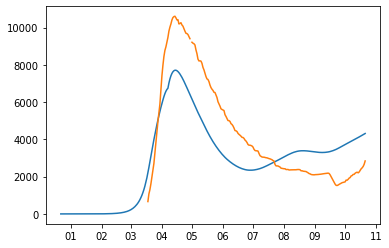

Deaths


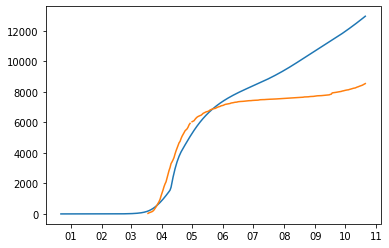

ICUs


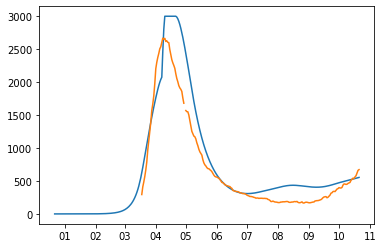

best_error: 9.499242733591913
vector: [9.499242733591913]
mean_deaths 1.7452969903197064
[8.88454675e+01 6.52764208e-01 5.99559069e-01 8.64819392e-01
 8.43876908e-01 6.53519773e-02 7.34109817e-01 1.35591215e-01
 6.41918949e-01 5.07707370e-01 5.20759703e-01 1.65827758e+00
 1.82498567e+00 3.54702343e+01]
Beds


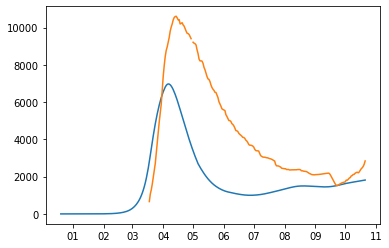

Deaths


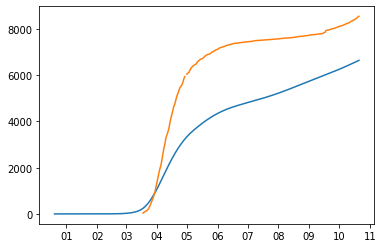

ICUs


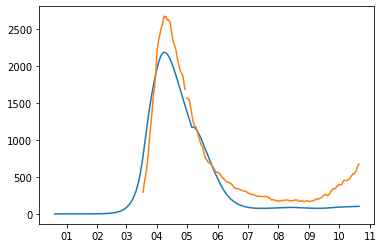

best_error: 11.014973347636877
vector: [11.014973347636877]
mean_deaths 1.7352008017178253
[9.10984293e+01 6.17781020e-01 6.12745340e-01 3.84656988e-01
 8.00493026e-01 7.84885269e-02 5.45364747e-01 1.31585303e-01
 7.11433193e-01 1.04591315e+00 7.36374344e-01 1.90925672e+00
 1.37893029e+00 3.32624266e+01]
Beds


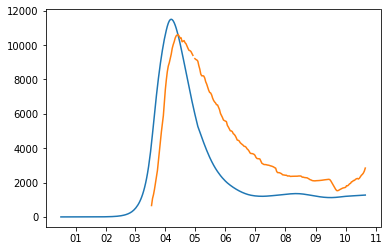

Deaths


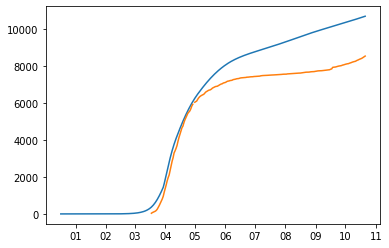

ICUs


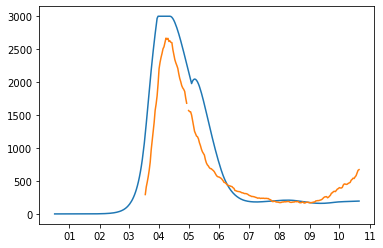

best_error: 10.507146404151289
vector: [10.507146404151289]
mean_deaths 1.7828856395623303
[9.08671751e+01 8.29084005e-01 6.05336352e-01 5.57118743e-01
 7.32634903e-01 6.89727500e-02 8.80503638e-01 8.05007605e-02
 5.60747684e-01 1.23673855e+00 6.14749169e-01 1.96492328e+00
 1.64814079e+00 5.21591034e+01]
Beds
best_error: 9.404495642848932
vector: [9.404495642848932]
mean_deaths 1.1731123073587888
[89.39400184  0.48882394  0.56124717  0.92887926  0.7894689   0.09545031
  0.55901413  0.13945432  0.70253556  0.63592998  0.95129184  1.23927203
  1.42270953 39.73799926]
Beds


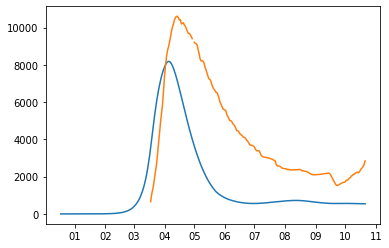

Deaths


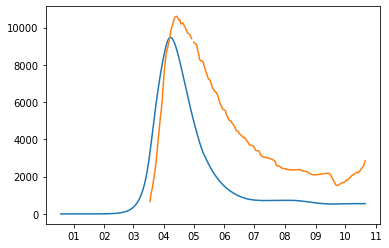

Deaths


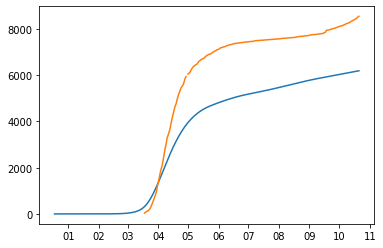

ICUs


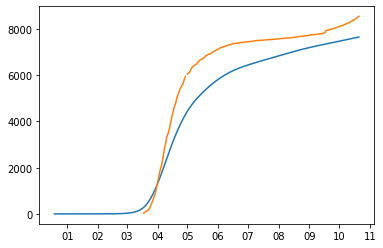

ICUs


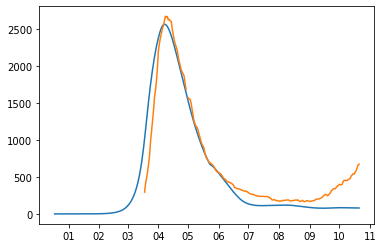

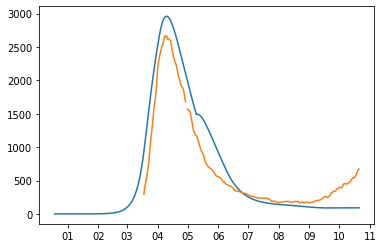

best_error: 10.17471184394891
vector: [10.17471184394891]
mean_deaths 1.5315518739643952
[9.14733727e+01 7.67372716e-01 6.46551582e-01 5.94309797e-01
 4.78007508e-01 4.50433322e-02 7.29476411e-01 4.61185205e-02
 7.56723946e-01 9.36511783e-01 5.12466524e-01 1.24999490e+00
 1.57926312e+00 9.46586461e+00]
Beds


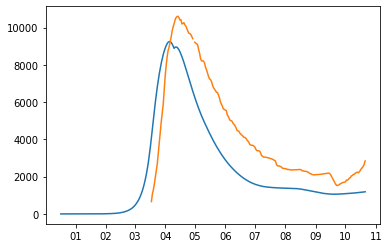

Deaths


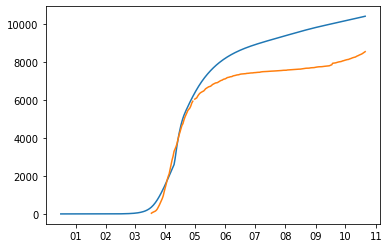

ICUs


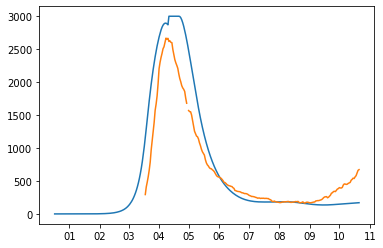

best_error: 9.184727280371554
vector: [9.184727280371554]
mean_deaths 1.7877876192557316
[8.80966761e+01 5.92248370e-01 6.08271872e-01 9.88982519e-01
 5.70984073e-01 4.60967145e-02 6.66784883e-01 1.29640349e-01
 9.37427450e-01 1.00210101e+00 8.79746663e-01 1.40294882e+00
 1.51482884e+00 4.11914340e+01]
Beds


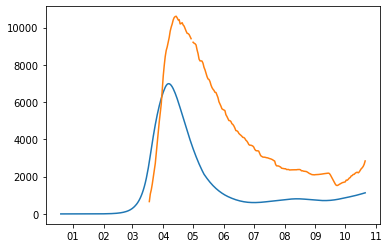

Deaths


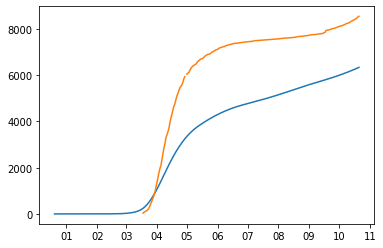

ICUs


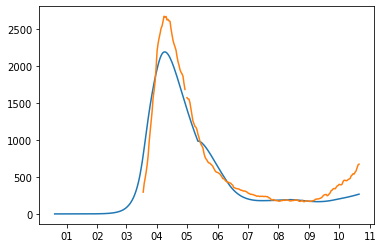

best_error: 9.245106966178337
vector: [9.245106966178337]
mean_deaths 1.2527406651795987
[8.54560226e+01 4.65655414e-01 6.05242843e-01 8.10433703e-01
 6.94587511e-01 6.43849088e-02 4.40478803e-01 1.19128217e-01
 6.47880575e-01 7.73313834e-01 1.03424015e+00 1.16959363e+00
 1.67547430e+00 1.93027069e+01]
Beds


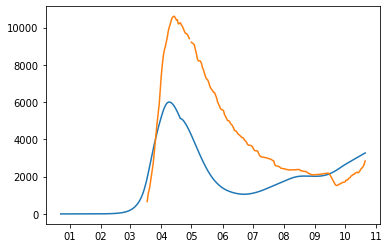

Deaths


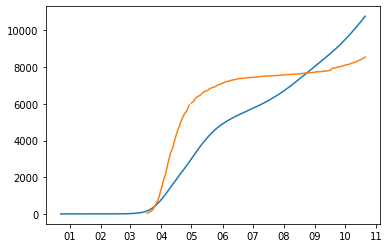

ICUs


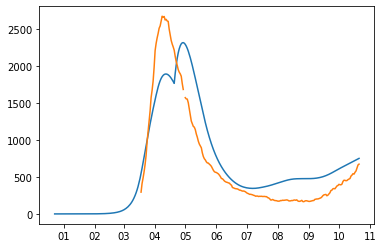

best_error: 9.313409217005448
vector: [9.313409217005448]
mean_deaths 1.0362930173315
[8.75875206e+01 6.64077210e-01 6.36077753e-01 5.88728576e-01
 4.93116747e-01 7.33154206e-02 7.98769984e-01 1.61135951e-01
 8.20753225e-01 1.03007312e+00 1.58011088e+00 1.99423068e+00
 1.94952294e+00 7.44597249e+00]
Beds


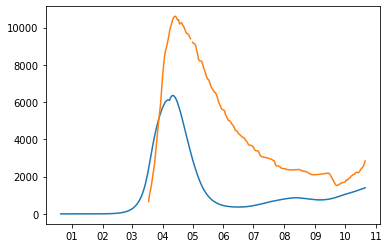

Deaths


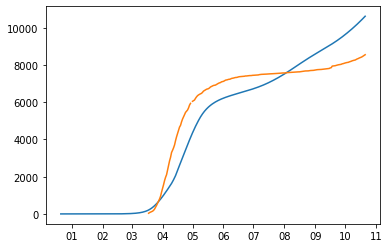

ICUs


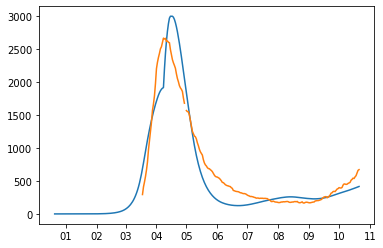

best_error: 7.304324218469338
vector: [7.304324218469338]
mean_deaths 1.4141234615858809
[8.75782647e+01 5.22385889e-01 6.11970483e-01 2.69194869e-02
 5.80640649e-01 7.07894118e-02 7.70839355e-01 7.42215775e-02
 9.84135904e-01 5.12130546e-01 1.49533623e+00 1.92503097e+00
 1.53225172e+00 3.80716843e+01]
Beds


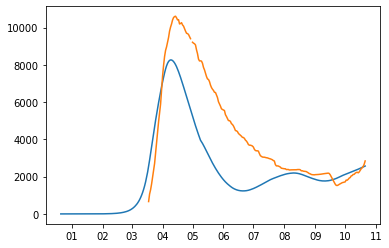

Deaths


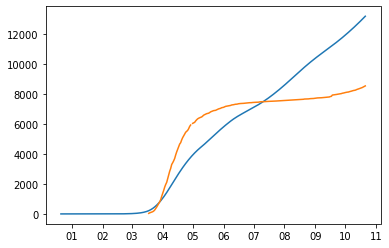

ICUs


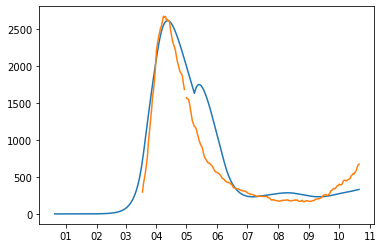

best_error: 9.624177965980241
vector: [9.624177965980241]
mean_deaths 1.3417560717171404
[8.59177042e+01 4.79630110e-01 5.59351027e-01 3.29635035e-01
 7.11066500e-01 5.90506855e-02 9.57736706e-01 1.14878451e-01
 7.30952457e-01 1.39173039e+00 8.62898972e-01 1.42987245e+00
 1.70502370e+00 3.64610223e+01]
Beds


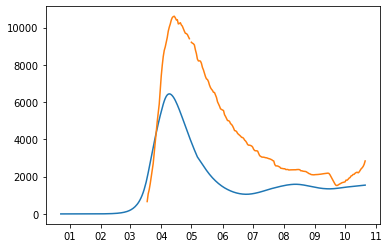

Deaths


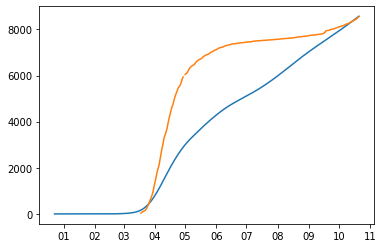

ICUs


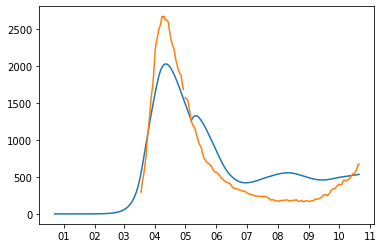

best_error: 10.484371110353498
vector: [10.484371110353498]
mean_deaths 2.3838058784480283
[79.28469729  0.30980878  0.52285752  0.93252966  0.39583507  0.09258491
  0.55691907  0.12544469  0.60792581  0.97932874  0.66817647  1.37036712
  0.96915345 15.49587227]
Beds


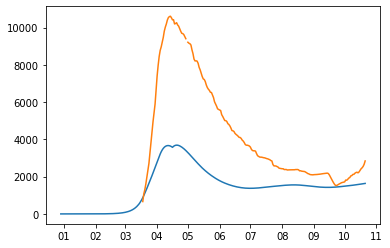

Deaths


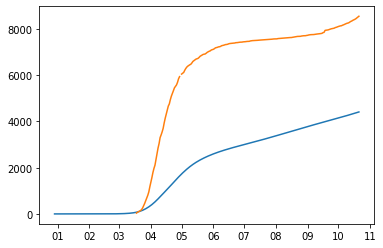

ICUs


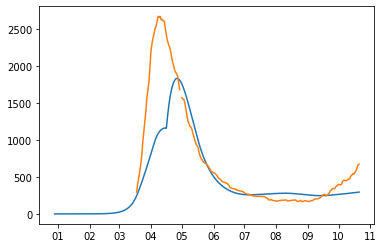

best_error: 8.754632357650685
vector: [8.754632357650685]
mean_deaths 1.3734664601760775
[9.08671751e+01 7.23982812e-01 6.72718533e-01 5.57118743e-01
 7.32634903e-01 7.67279115e-02 5.69061095e-01 1.05223307e-01
 5.60747684e-01 5.01838537e-01 6.14749169e-01 1.18603306e+00
 1.86231220e+00 5.21591034e+01]
Beds


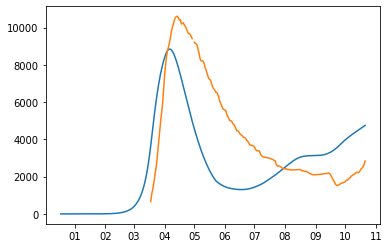

Deaths


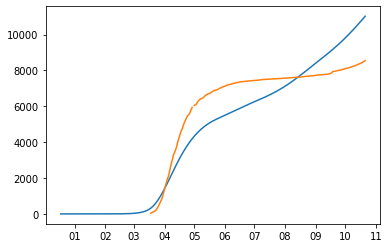

ICUs


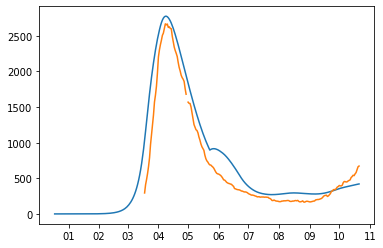

best_error: 9.915790138932145
vector: [9.915790138932145]
mean_deaths 1.7365723636156871
[8.39568735e+01 3.48983206e-01 5.04616997e-01 6.98722639e-01
 5.52976003e-01 8.21747244e-02 5.17172150e-01 1.18911835e-01
 6.65307987e-01 1.36237713e+00 5.11663387e-01 1.85621802e+00
 1.27655573e+00 2.12911906e+01]
Beds


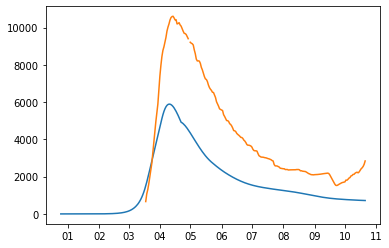

Deaths


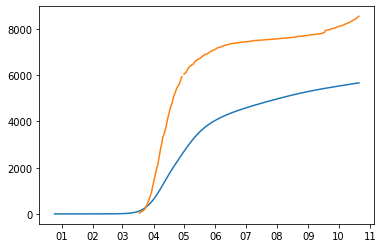

ICUs


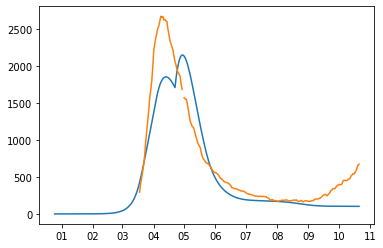

best_error: 8.415392500105337
vector: [8.415392500105337]
mean_deaths 1.5675288180028355
[8.86602071e+01 7.71069465e-01 7.38592884e-01 5.21701569e-01
 2.85610201e-01 6.08395602e-02 2.32065178e-02 9.38843450e-02
 5.44035871e-01 8.40394696e-01 7.69751443e-01 1.67971946e+00
 1.75357803e+00 5.19472310e+01]
Beds


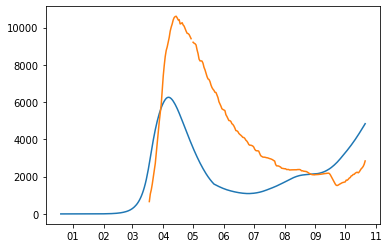

Deaths


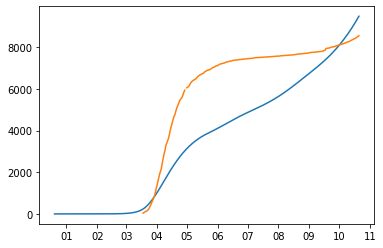

ICUs


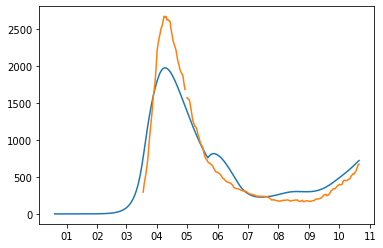

best_error: 6.9245888254097
vector: [6.9245888254097]
mean_deaths 1.3533649567742823
[8.71970484e+01 5.08769470e-01 6.02228452e-01 8.99863284e-01
 3.22838178e-01 7.13629955e-02 9.87965444e-01 1.98908072e-01
 7.89733713e-01 7.09303901e-01 7.11970065e-01 1.99409946e+00
 1.76429631e+00 3.23134822e+01]
Beds


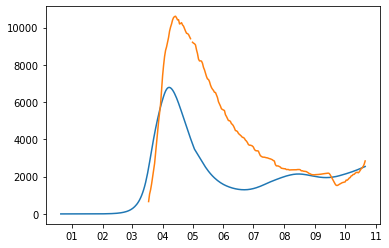

Deaths


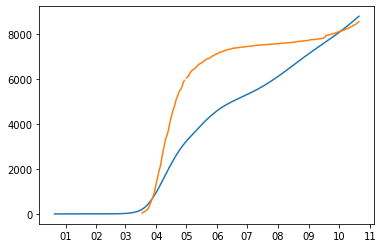

ICUs


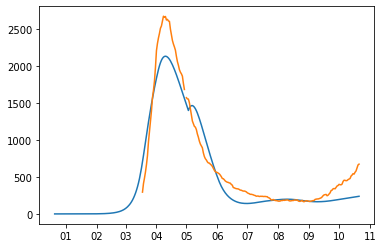

best_error: 8.787421400428725
vector: [8.787421400428725]
mean_deaths 1.489686008912461
[8.87288075e+01 1.04020632e+00 7.15818252e-01 7.00830463e-01
 7.72489929e-01 7.65456069e-02 4.82264473e-01 4.73358283e-02
 5.49426765e-01 7.93581730e-01 1.41211783e+00 1.62181816e+00
 1.97802542e+00 1.34260756e+01]
Beds


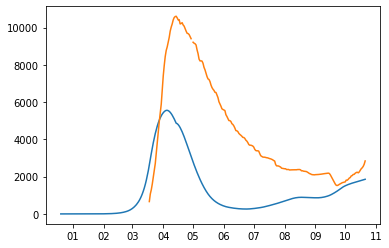

Deaths


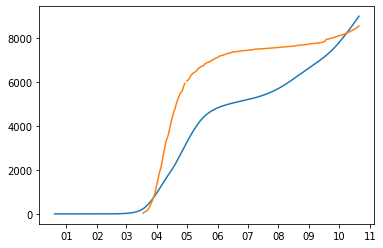

ICUs


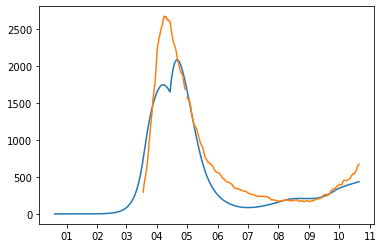

best_error: 9.795468960925879
vector: [9.795468960925879]
mean_deaths 1.3384480754229275
[8.98561478e+01 5.55162906e-01 5.87440439e-01 7.67391687e-01
 3.62352830e-01 9.76818515e-02 8.14288680e-01 4.29103299e-02
 7.43124072e-01 6.75811060e-01 1.12672394e+00 1.60313912e+00
 1.99766364e+00 5.05946165e+01]
Beds


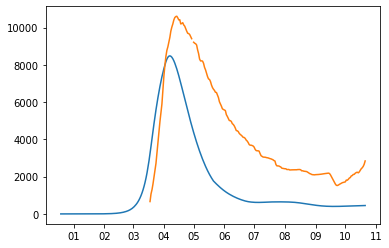

Deaths


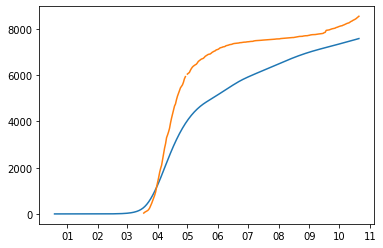

ICUs


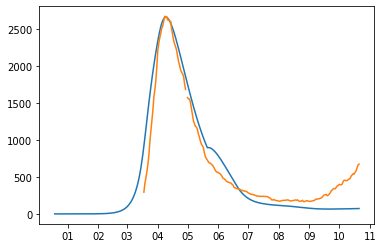

best_error: 8.389429589880125
vector: [8.389429589880125]
mean_deaths 1.5102994698733379
[8.49571431e+01 4.53108132e-01 5.85603627e-01 4.97803674e-01
 1.73663751e-01 2.99361292e-02 8.33621524e-01 8.95152621e-02
 6.78629970e-01 9.95668111e-01 9.26576657e-01 1.92783401e+00
 1.44168150e+00 1.95054646e+01]
Beds


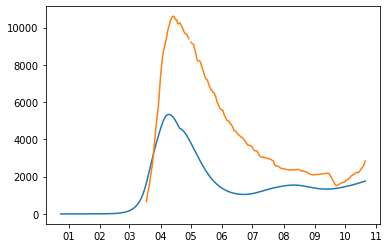

Deaths


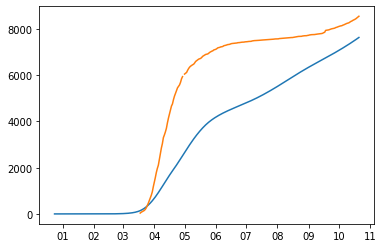

ICUs


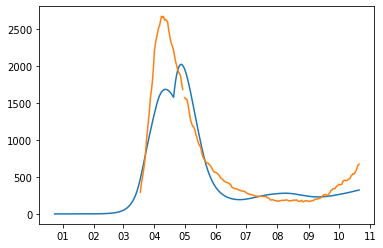

best_error: 10.655834902524356
vector: [10.655834902524356]
mean_deaths 1.9083804101460635
[8.36477824e+01 5.57440540e-01 6.25911516e-01 2.72106099e-01
 4.95885741e-01 5.56663418e-02 3.97082427e-01 1.66920446e-01
 6.49459981e-01 9.50499711e-01 6.06183759e-01 1.61494697e+00
 1.64774828e+00 4.27053573e+01]best_error: 7.942903269502748

Beds
vector: [7.942903269502748]
mean_deaths 1.0773021421737439
[84.43563185  0.5102879   0.58032809  0.87021131  0.78634847  0.09501073
  0.7698588   0.15619005  0.79235475  0.95945549  0.67930221  1.25415436
  1.91733582  3.8306554 ]
Beds


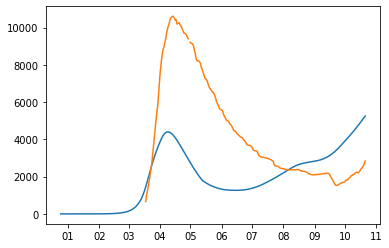

Deaths


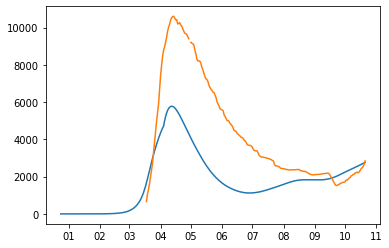

Deaths


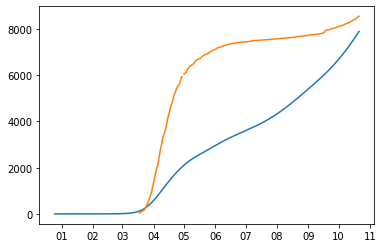

ICUs


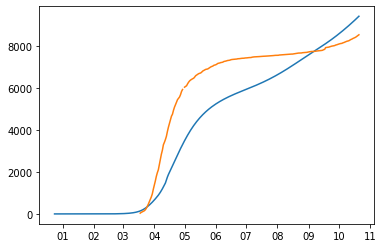

ICUs


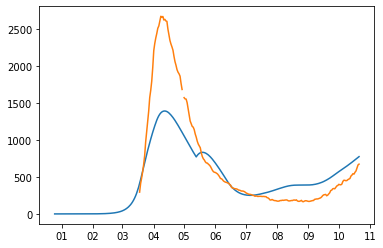

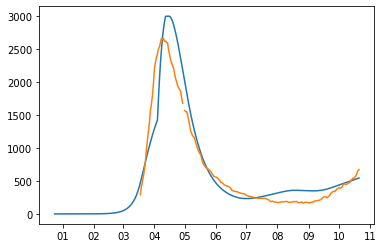

best_error: 8.659099365881486
vector: [8.659099365881486]
mean_deaths 1.1267790201688292
[8.79210146e+01 4.26111943e-01 5.82952235e-01 8.28408519e-01
 6.74074843e-01 8.58882697e-02 2.97523885e-01 6.91587904e-02
 7.23564454e-01 6.00529700e-01 8.07357244e-01 1.74692276e+00
 1.53038875e+00 1.54025080e+01]
Beds


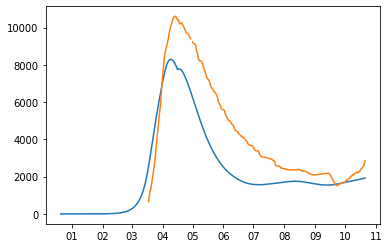

Deaths


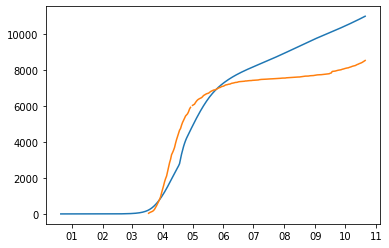

ICUs


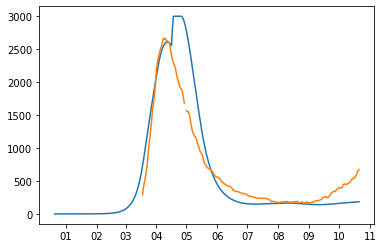

best_error: 7.488295024650045
vector: [7.488295024650045]
mean_deaths 1.8544605785779777
[8.75999349e+01 4.99200857e-01 6.03729202e-01 8.46359619e-01
 5.55251639e-01 8.28679267e-02 4.34582176e-01 1.57807919e-01
 8.82980647e-01 1.07982840e+00 5.75815363e-01 1.63186098e+00
 5.29770011e-01 3.03130035e+01]
Beds


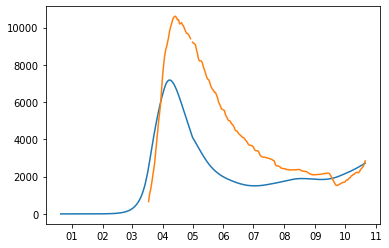

Deaths


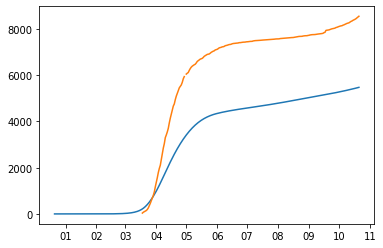

ICUs


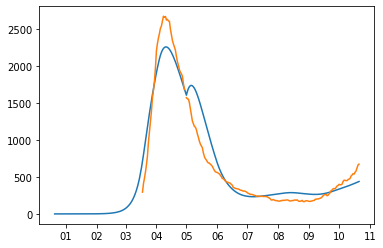

best_error: 9.093320349144703
vector: [9.093320349144703]
mean_deaths 1.4888322325896395
[8.71390525e+01 6.49002777e-01 6.32417275e-01 6.61425892e-01
 5.84839740e-01 8.03890911e-02 8.05214277e-01 5.25204039e-02
 7.16700021e-01 6.33742392e-01 1.96339359e+00 1.75661194e+00
 1.58913625e+00 2.57360209e+01]
Beds
best_error: 7.401413410754444
vector: [7.401413410754444]
mean_deaths 1.5916406585242844
[8.80615996e+01 5.68878994e-01 6.43787675e-01 9.65842172e-01
 2.15686721e-01 7.88490386e-02 9.79811470e-01 1.89368573e-01
 7.26649765e-01 6.00806096e-01 7.87450566e-01 1.62378616e+00
 1.14341591e+00 3.99958101e+01]
Beds
best_error: 7.051482614062589
vector: [7.051482614062589]
mean_deaths 1.2865137358198575
[8.75782647e+01 5.38315583e-01 6.11970483e-01 2.69194869e-02
 1.51758738e-01 7.25112722e-02 8.78641421e-01 1.96639416e-01
 9.84135904e-01 5.12130546e-01 7.95979150e-01 1.47173517e+00
 1.89058508e+00 3.80716843e+01]
Beds
best_error: 6.982087686010473
vector: [6.982087686010473]
mean_deaths 1.1

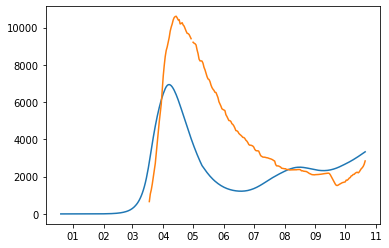

Deaths


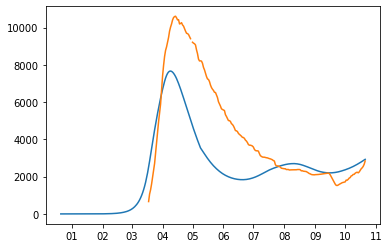

Deaths


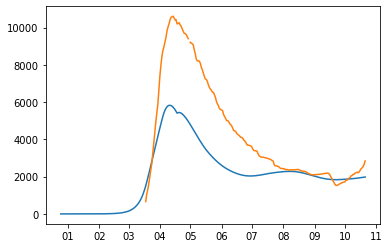

Deaths


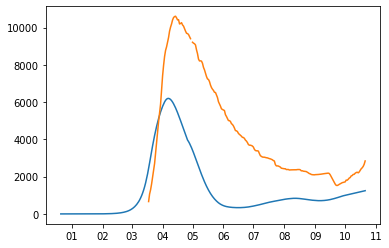

Deaths


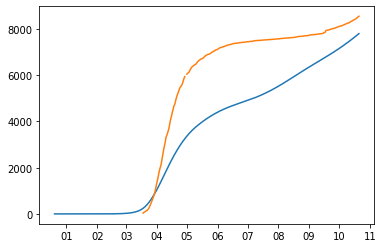

ICUs


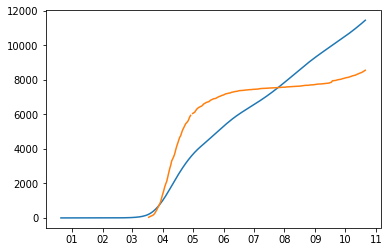

ICUs


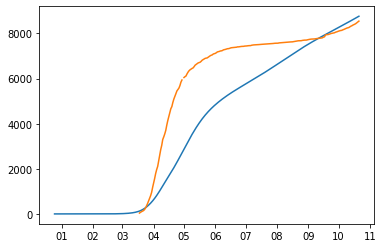

ICUs


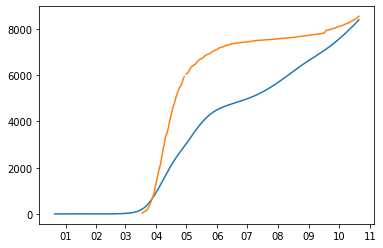

ICUs


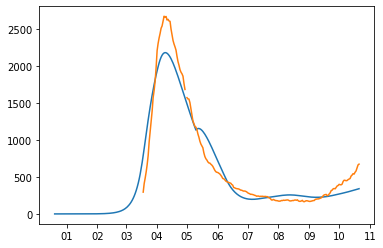

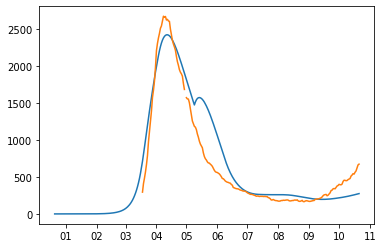

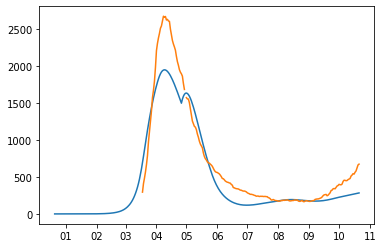

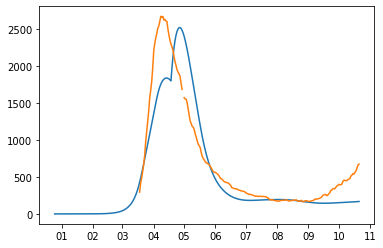

best_error: 9.31882742616025
vector: [9.31882742616025]
mean_deaths 1.79881752328944
[8.64525429e+01 8.33760660e-01 6.74499903e-01 8.69609030e-01
 5.51676273e-01 6.55156032e-02 9.49696265e-01 2.33087984e-02
 9.15566267e-01 7.33200856e-01 7.69311421e-01 1.92305179e+00
 1.91503138e+00 1.32914516e+01]
Beds


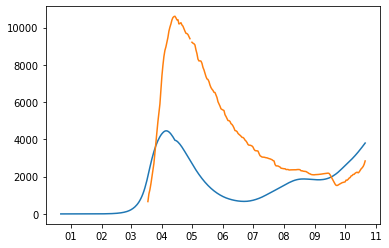

Deaths


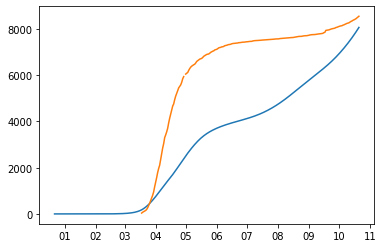

ICUs


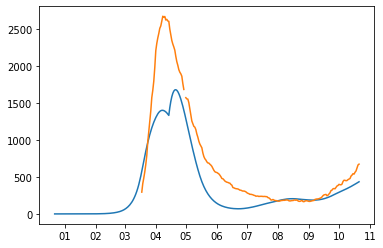

best_error: 9.047309051304019
vector: [9.047309051304019]
mean_deaths 1.0321150131738497
[8.67783890e+01 3.81390958e-01 5.16369238e-01 6.27815306e-01
 6.65064465e-01 4.33732579e-02 6.94150564e-01 7.91332962e-02
 9.61295539e-01 1.11604378e+00 1.06610535e+00 1.75429811e+00
 1.69797840e+00 3.11944494e+01]
Beds


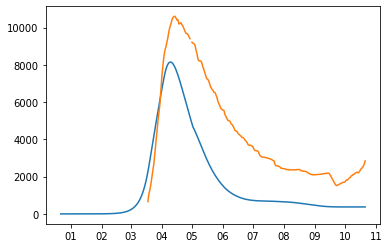

Deaths


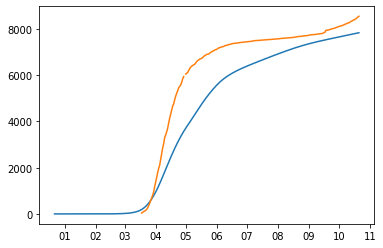

ICUs


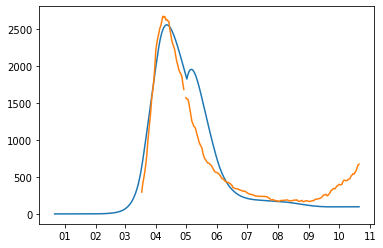

best_error: 8.047332970527245
vector: [8.047332970527245]
mean_deaths 1.6392730202367618
[8.45733180e+01 4.71545835e-01 5.65827540e-01 3.47243620e-01
 4.16577250e-01 8.01640119e-02 8.49758146e-01 1.51239156e-01
 7.42499536e-01 8.51786545e-01 7.08772510e-01 1.67168712e+00
 1.66497411e+00 3.51999556e+01]
Beds


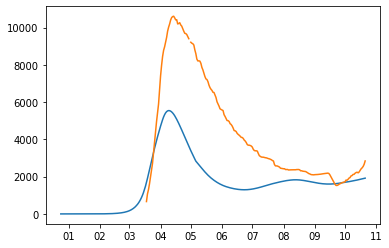

Deaths


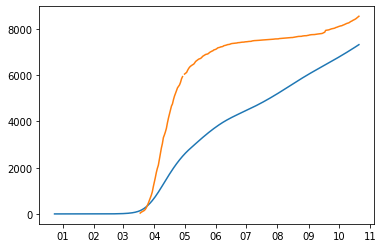

ICUs


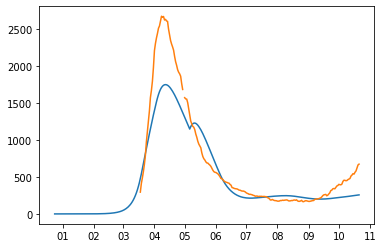

best_error: 9.17159979124778
vector: [9.17159979124778]
mean_deaths 1.8799489044573945
[8.94407525e+01 9.08935749e-01 7.07152844e-01 9.67933916e-01
 3.20603260e-01 7.03283717e-02 9.87965444e-01 1.70227983e-01
 8.13615347e-01 1.14582270e+00 1.10880879e+00 1.72221627e+00
 1.82872674e+00 4.49240932e+01]
Beds


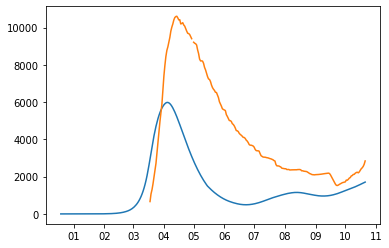

Deaths


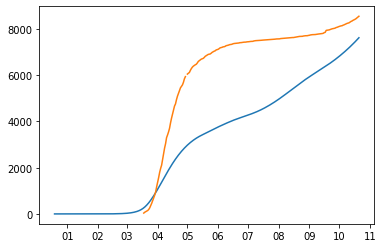

ICUs


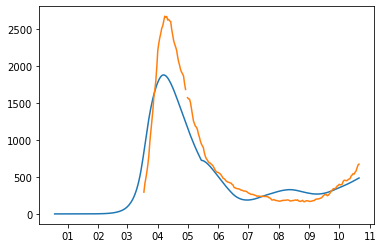

best_error: 7.36073360874323
vector: [7.36073360874323]
mean_deaths 1.5083970868098953
[8.50934321e+01 4.85294232e-01 5.99143108e-01 8.02712319e-01
 3.23759339e-01 7.28031909e-02 9.49211098e-01 2.20170193e-04
 7.81287770e-01 5.97191374e-01 8.43875326e-01 1.34588642e+00
 1.83351083e+00 3.42855622e+01]
Beds


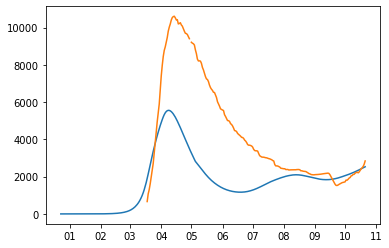

Deaths


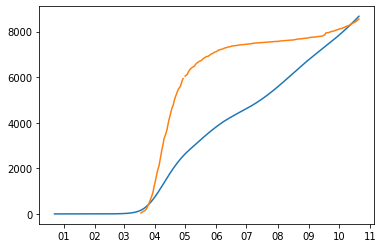

ICUs


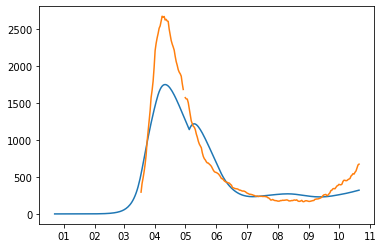

best_error: 8.706829307344597
vector: [8.706829307344597]
mean_deaths 0.972175611735409
[8.72255441e+01 4.51878466e-01 5.81168610e-01 9.06734318e-01
 3.38097735e-01 5.15246118e-02 6.70022501e-01 1.83301455e-01
 8.71911728e-01 1.43068211e+00 1.68551867e+00 1.98078585e+00
 1.75184165e+00 1.75480898e+01]
Beds
best_error: 7.742795280748967
vector: [7.742795280748967]
mean_deaths 1.7335191970900865
[8.78688817e+01 5.73531483e-01 6.34487613e-01 8.57137553e-01
 4.61053819e-01 1.91092595e-03 6.11075591e-01 1.16014002e-01
 8.10541153e-01 5.58905511e-01 8.65944919e-01 1.16676943e+00
 1.11617154e+00 2.07914460e+01]
Beds


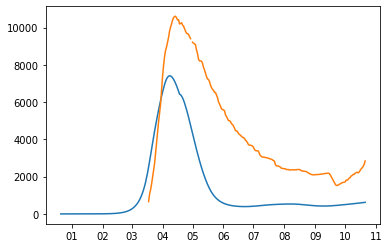

Deaths


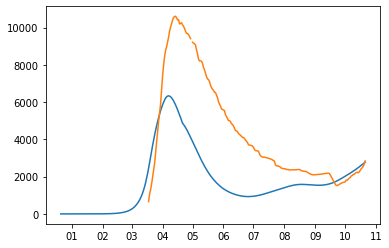

Deaths


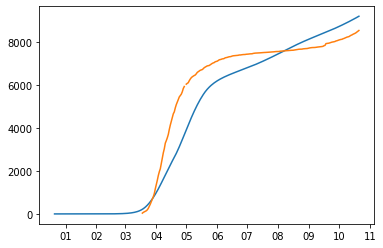

ICUs


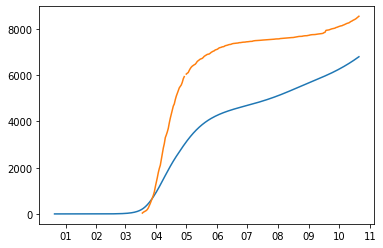

ICUs


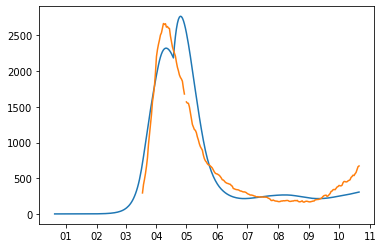

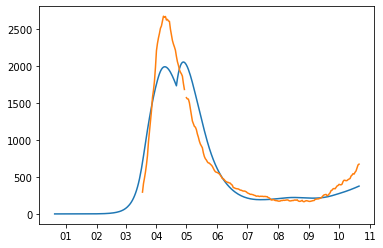

best_error: 6.9211528474242225
vector: [6.9211528474242225]
mean_deaths 1.270699439780318
[8.89082973e+01 6.58939749e-01 6.48497403e-01 6.05586102e-01
 5.37350692e-01 5.33396914e-02 6.14571365e-01 1.90398726e-01
 9.42612109e-01 9.51941412e-01 9.74531726e-01 1.73381726e+00
 1.69573897e+00 2.20464485e+01]
Beds


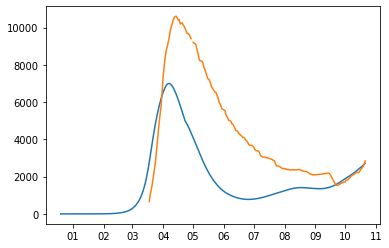

Deaths


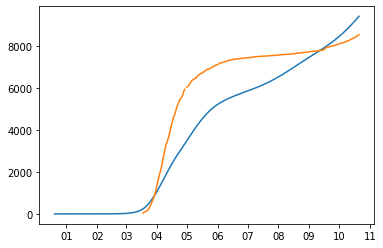

ICUs


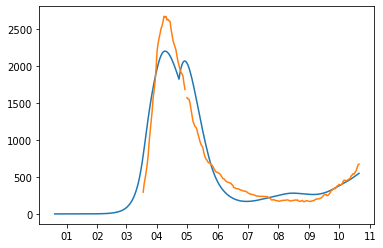

best_error: 9.172752498460863
vector: [9.172752498460863]
mean_deaths 1.9274191693405016
[8.71390525e+01 6.49002777e-01 6.32417275e-01 9.48487357e-01
 4.37318785e-01 7.65203535e-02 7.61627208e-01 1.11350692e-01
 7.16700021e-01 6.33742392e-01 7.01171398e-01 1.14746313e+00
 1.77497326e+00 3.27020183e+01]
Beds
best_error: 8.32764537490183
vector: [8.32764537490183]
mean_deaths 1.4234314949239841
[8.80615996e+01 5.68878994e-01 6.43787675e-01 8.12002792e-01
 4.74699409e-01 7.81601662e-02 9.67461734e-01 5.43157396e-02
 6.54801079e-01 7.39025679e-01 9.09497401e-01 1.98277167e+00
 1.61204954e+00 3.99958101e+01]
Beds


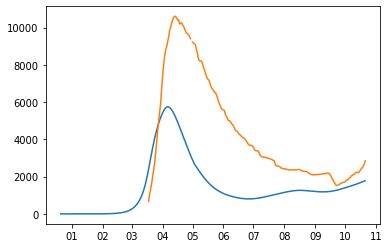

Deaths


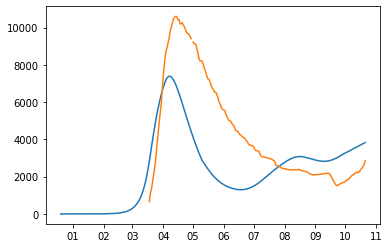

Deaths


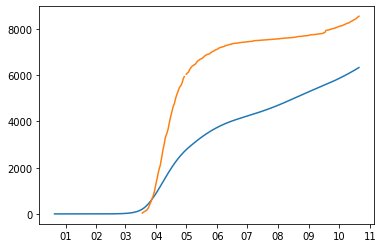

ICUs


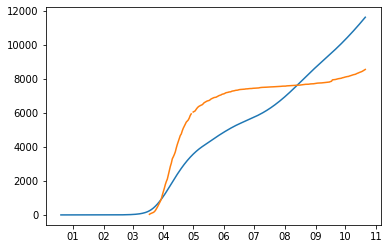

ICUs


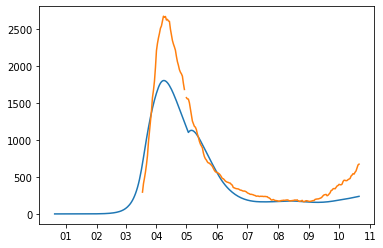

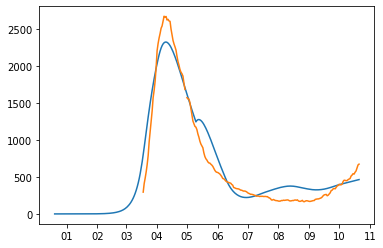

In [ ]:
from scipy.optimize import minimize, Bounds, shgo, differential_evolution, dual_annealing
epsilon = 0.1
result = differential_evolution(error, [(50,140)]+[windows['alpha_mixing']]*1+[windows['transmission']]+[[0,1]]*2+[windows['school_l'],[0,1],[0,0.2],[0.5,1]]+[[0.50,2.0]]+[[0.50,2.0]]*3+[[0,60]],workers = -1)

#windows["mu"],windows["sigma"],windows["p_ICU"],windows["p_H"],windows["lambda_H_R"],windows["lambda_H_D"],windows["lambda_ICU_R"],windows["lambda_ICU_D"]
